## Compare models

### Basic Parameter

IMPORTANT: Do not rename any variables in this section — they are externally referenced in the GitHub action `Train Model`.

* `Input_Dir`: Path to the input directory containing training images
* `Output_Dir`: Path to the output directory where results (models, logs, etc.) will be saved
* `Save_Evaluation_Images`: Save model accuracy divergation graphs to specified folder
* `Input_Shape`: Tuple specifying the image dimensions (width, height, channels)

In [1]:
Input_Dir  = 'data_raw_all'
Output_Dir = 'models'
Save_Evaluation_Images = False

# Input image size [x, y, channels]
Input_Shape = (32, 32, 3)


In [2]:
# Parameters
Input_Dir = "data_raw_all"


### Load Libraries

In [3]:
import os
import glob
from pathlib import Path
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from src.utils.plot_functions import plot_dataset_analog_result, plot_divergence


%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)


2025-08-25 17:34:06.094891: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-25 17:34:06.097959: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-25 17:34:06.106518: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756143246.120833   14566 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756143246.125029   14566 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-25 17:34:06.140417: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

### Load files

In [4]:
files = glob.glob(Input_Dir + '/*.jpg') # + glob.glob(Input_Dir + '/duplicates/*.jpg') # Add this to check duplicates as well

# Prepare data container
f_data = np.empty((len(files)), dtype="<U250")
x_data = np.empty((len(files),Input_Shape[0],Input_Shape[1],Input_Shape[2]), dtype="float32")
y_data = np.empty((len(files)))

# Process files
for i, file in enumerate(files):
    # Load and resize image
    image_bytes = tf.io.read_file(file)
    image = tf.image.decode_image(image_bytes, channels=Input_Shape[2], expand_animations=False)
    
    # Resize image (if required)
    if image.shape[0] != Input_Shape[0] or image.shape[1] != Input_Shape[1]:
        image = tf.image.resize(image, [Input_Shape[0], Input_Shape[1]], method=tf.image.ResizeMethod.MITCHELLCUBIC)
        image = tf.clip_by_value(tf.cast(image, tf.float32), 0.0, 255.0)
    else:
        image = tf.cast(image, tf.float32)

    # Extract truth value from filename and save as category [0.0 .. 9.9]
    base = Path(file).name
    category = float(base[:3])

    # Save data
    f_data[i] = file
    x_data[i] = image.numpy()
    y_data[i] = category

    if i % 500 == 0:
        print(f"{i} files processed...")

# Shuffle data
x_data, y_data, f_data = shuffle(x_data, y_data, f_data)


print("Data count: ", len(y_data))  
print(x_data.shape)
print(np.expand_dims(y_data, axis=1).shape)


2025-08-25 17:34:08.263905: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


0 files processed...


500 files processed...


1000 files processed...


1500 files processed...


Data count:  1838
(1838, 32, 32, 3)
(1838, 1)


### Helper functions

In [5]:
def plot_dataset_analog_result_sorted(false_predicted_images, false_predicted_plt_labels, false_predicted_dev_values):

    if (len(false_predicted_dev_values) == 0):
        return
    
    # Sort by deviation (largest first)
    sorted_items = sorted(
        zip(false_predicted_images, false_predicted_plt_labels, false_predicted_dev_values),
        key=lambda item: item[2],  # Sort by false_predicted_dev_values
        reverse=True
    )
    
    false_predicted_images, false_predicted_plt_labels, false_predicted_dev_values = zip(*sorted_items)
    false_predicted_images = list(false_predicted_images)
    false_predicted_plt_labels = list(false_predicted_plt_labels)
    false_predicted_dev_values = list(false_predicted_dev_values)
    
    # Plot results
    print("False Predictions (Sorted by largest deviation, max. 49 images)")
    plot_dataset_analog_result(false_predicted_images, false_predicted_plt_labels, columns=7, rows=7, figsize=(18,18))


def evaluate_model_accuracy(model_path, x_data, y_data, f_data, title, accepted_deviation = 0.1, save_images=False):
    false_predicted_images = []
    false_predicted_plt_labels = []
    false_predicted_dev_values = []

    # Prepare interpreter and load model
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    
    # Ignore models with other than defined shape (default: 32, 32, 3)
    if ((interpreter.get_input_details()[0]["shape"] != (1, Input_Shape[0], Input_Shape[1], Input_Shape[2])).any()):
        print("Input dimension not supported")
        return

    for x, y, f in zip(x_data, y_data, f_data):
        
        interpreter.set_tensor(input_index, np.expand_dims(x, axis=0))
        interpreter.invoke() # Run inference
        
        # Post-processing: Remove batch dimension and find the result with highest probability
        output = interpreter.get_tensor(output_index)

        # Calculate prediction value depending on model type (ana-cont, ana-class100)
        if (len(output[0])==2): # ana-cont
            out_sin = output[0][0]  
            out_cos = output[0][1]
            predicted_val = np.round(((np.arctan2(out_sin, out_cos) / (2 * math.pi)) % 1) * 10, 1)
        elif (len(output[0])==100): # ana-class100
            predicted_val = (np.argmax(output, axis=1).reshape(-1) / 10)[0]
        else:
            print("Output dimension not supported")
            return

        deviation_val = np.round(min(abs(predicted_val - y), abs(predicted_val - (10 - y))) * 10) / 10

        # Round values
        predicted_val = np.round(predicted_val, 1)
        expected_val = np.round(y, 1)
        deviation_val = np.round(deviation_val, 1)
        
        if deviation_val > accepted_deviation:
            false_predicted_images.append(x)
            false_predicted_plt_labels.append(
                "Expected: " + str(expected_val) + 
                "\n Predicted: " + str(predicted_val) + 
                "\n" + str(os.path.basename(f)[:-4][:20])
            )
            false_predicted_dev_values.append(deviation_val)
            #print(predicted_val, y, deviation_val)
    
    accuracy = "{:.2f}%".format((1-len(false_predicted_dev_values)/len(y_data))*100)
    title = f"Model: {os.path.basename(model_path)}  |  Images: {len(y_data)}\nAccuracy: {accuracy} (False Predicted: {len(false_predicted_dev_values)}) With Accepted Deviation: {accepted_deviation}"
    
    if save_images:
        filename = os.path.join(Output_Dir, os.path.basename(model_path) + ".png")
    else:
        filename = None

    
    # Plot the deviation divergence (max deviation: 5.0)
    plot_divergence(np.bincount(np.array(np.array(false_predicted_dev_values) * 10).astype(int), minlength=51), title, filename)


    # Plot the dataset of false predictions (Use first 49 entries, sorted by deviation (largest first)
    # plot_dataset_analog_result_sorted(false_predicted_images, false_predicted_plt_labels, false_predicted_dev_values)


### Evaluate Model Accuracy (Accepted Deviation: 0.1)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


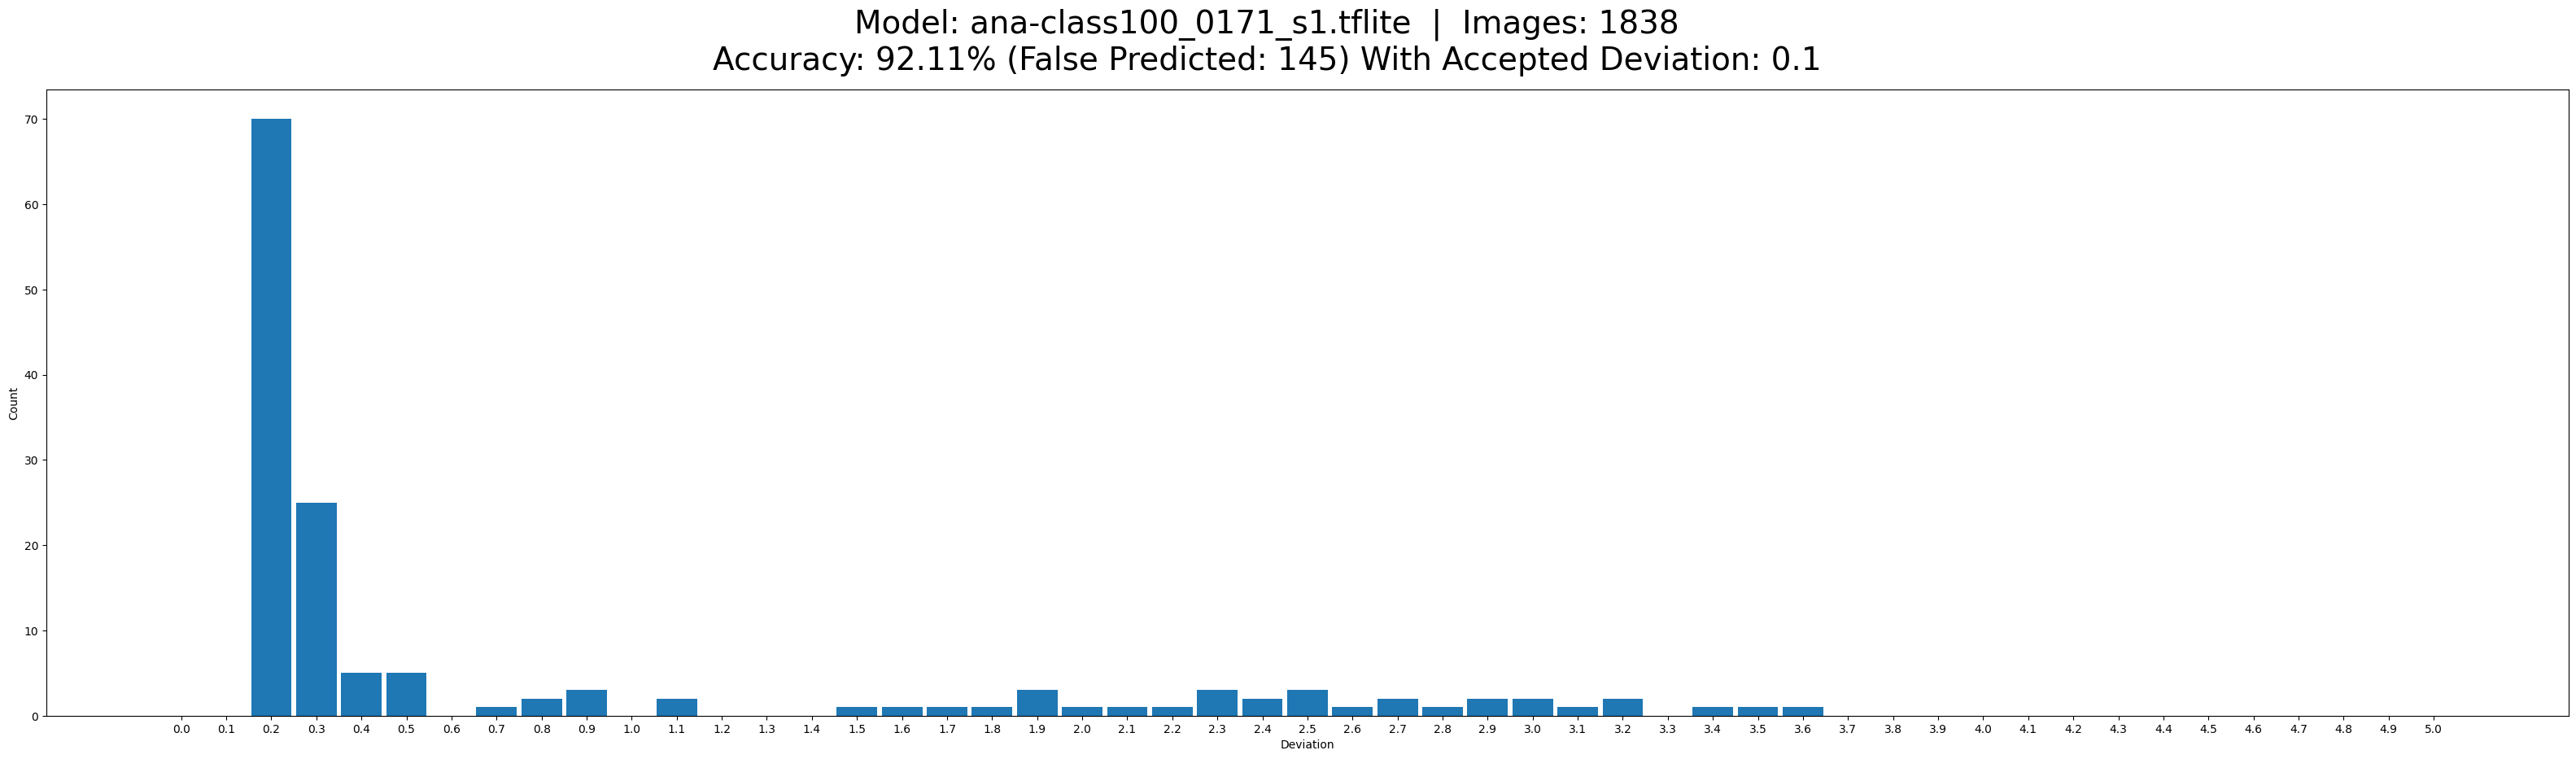

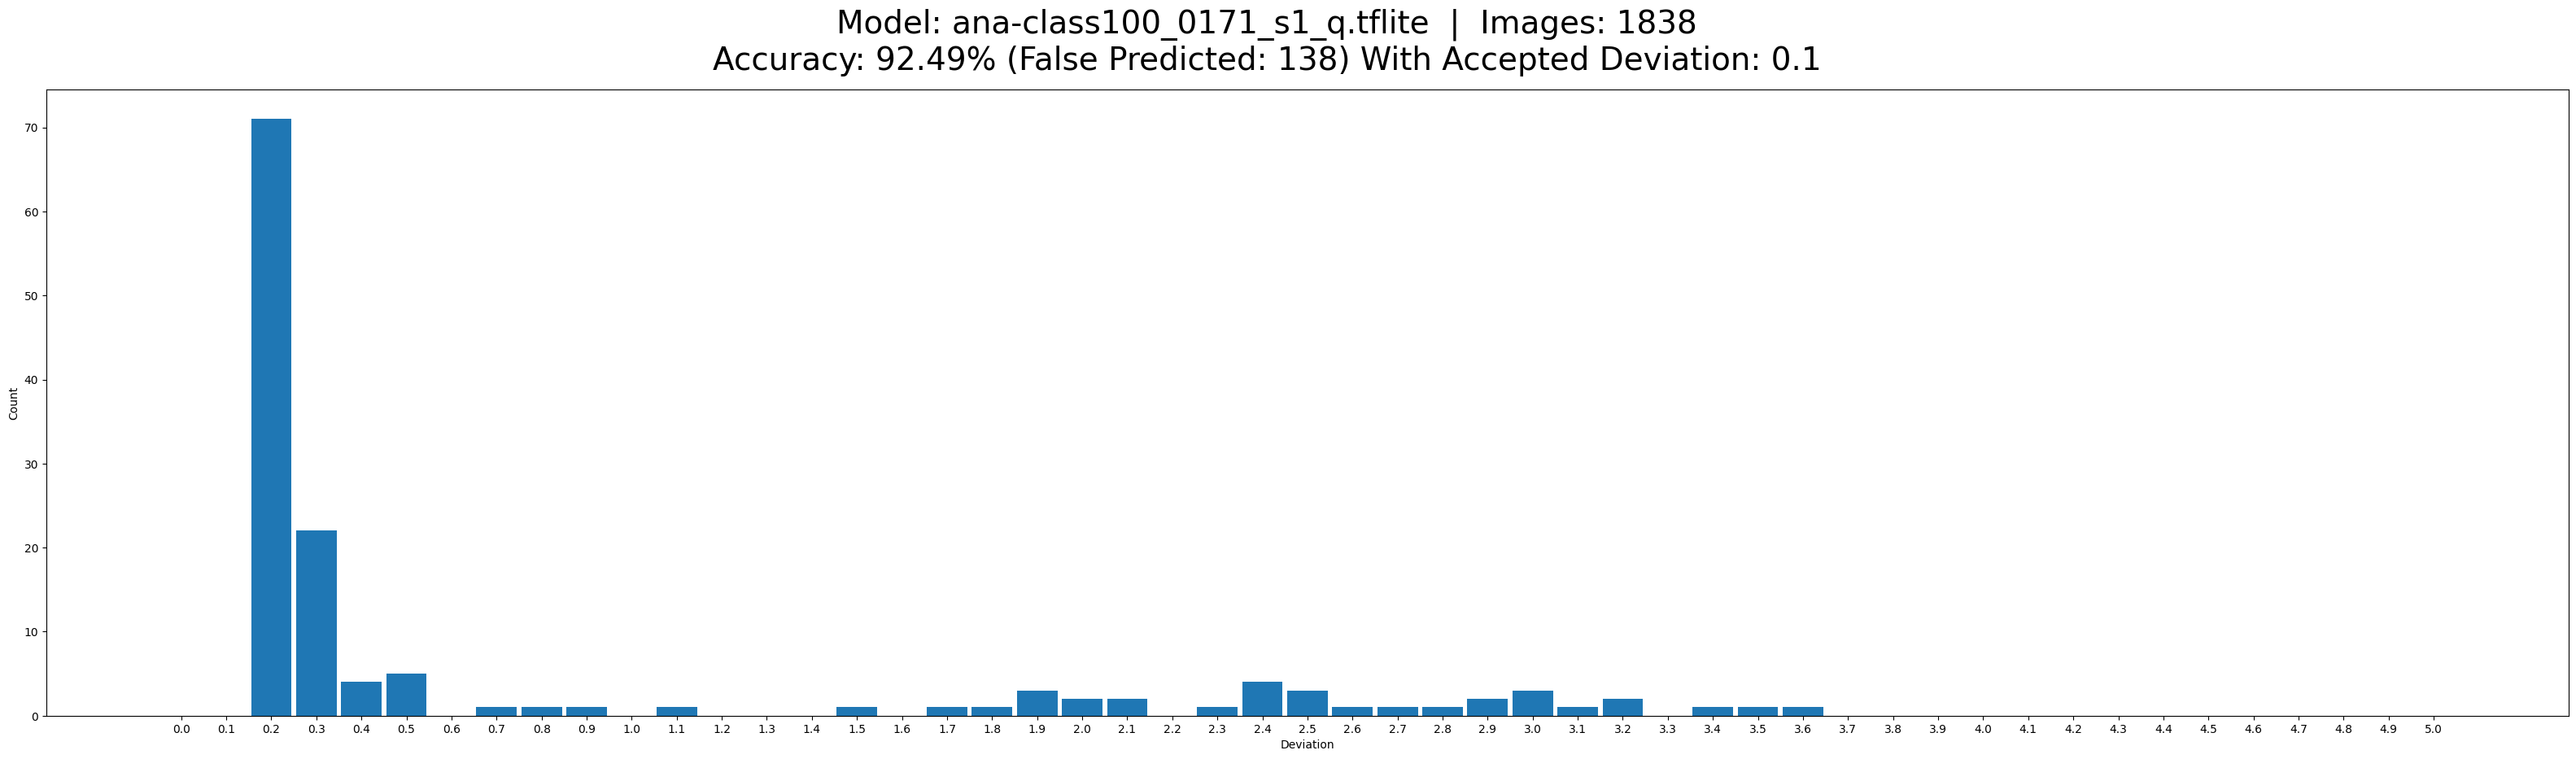

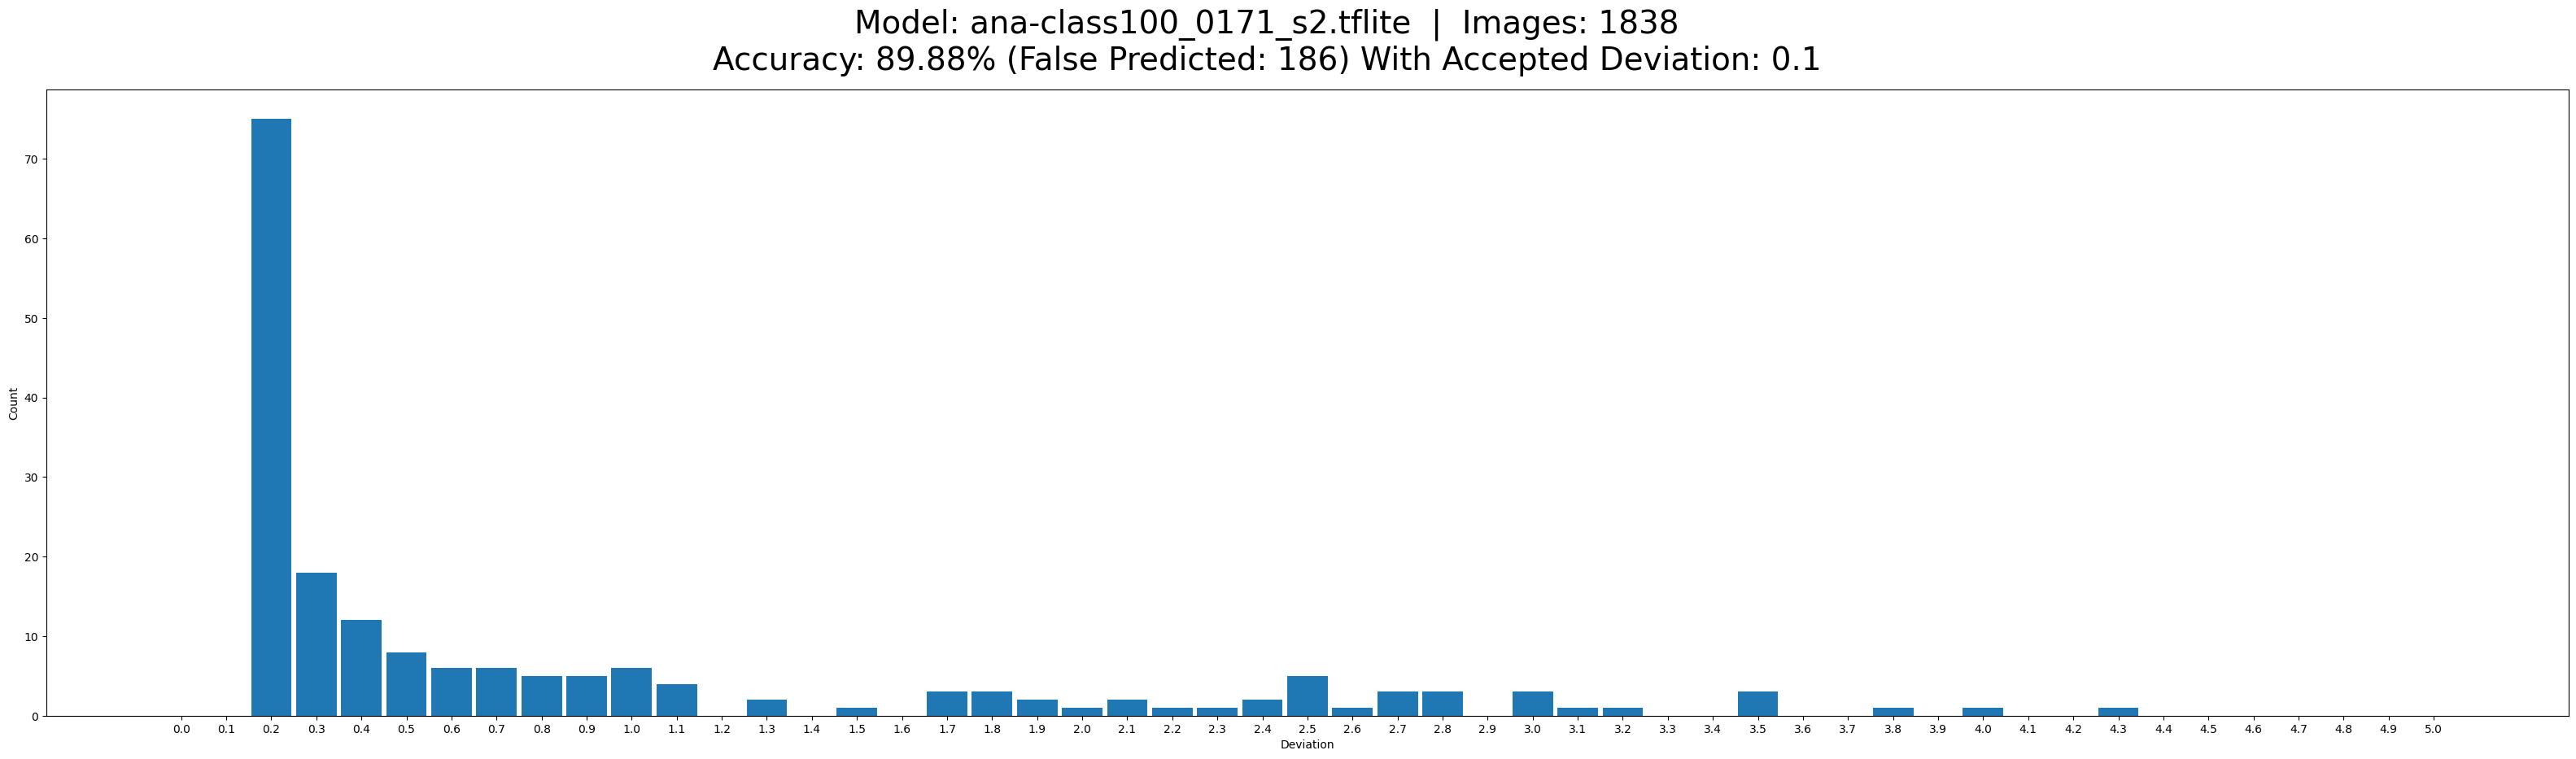

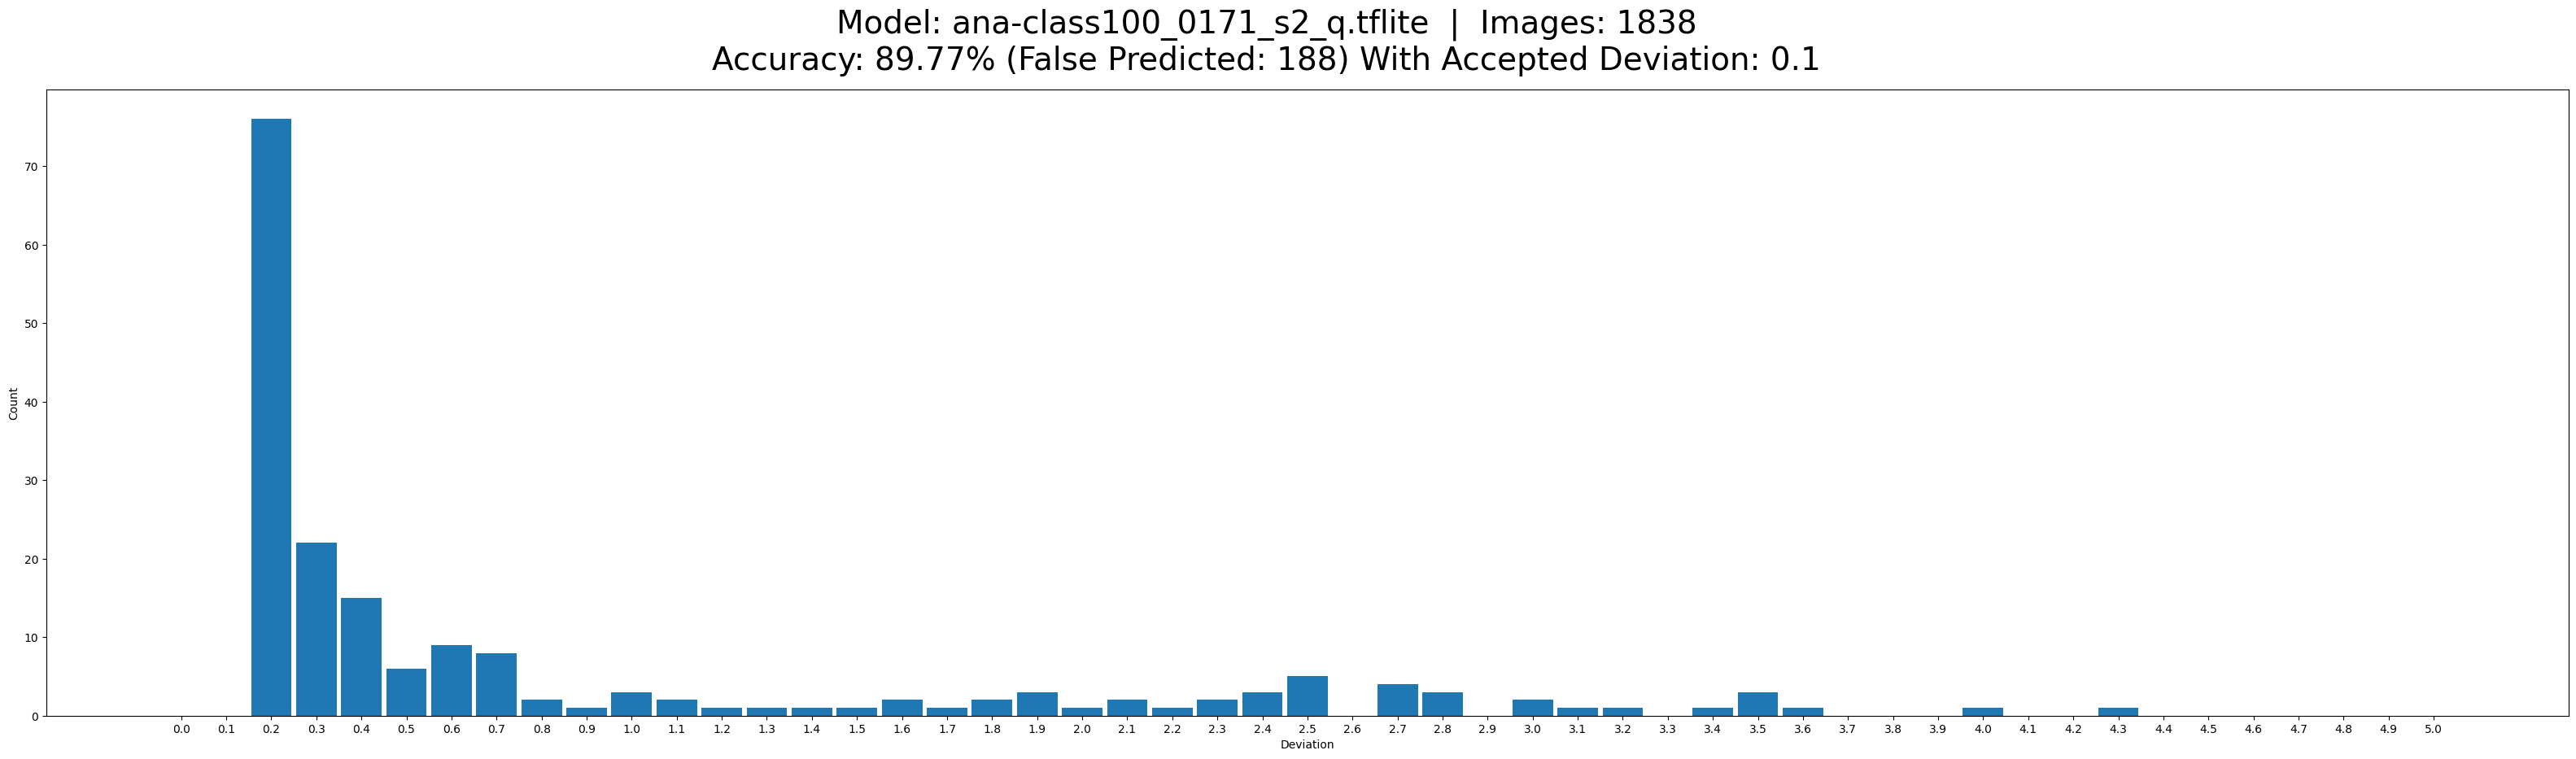

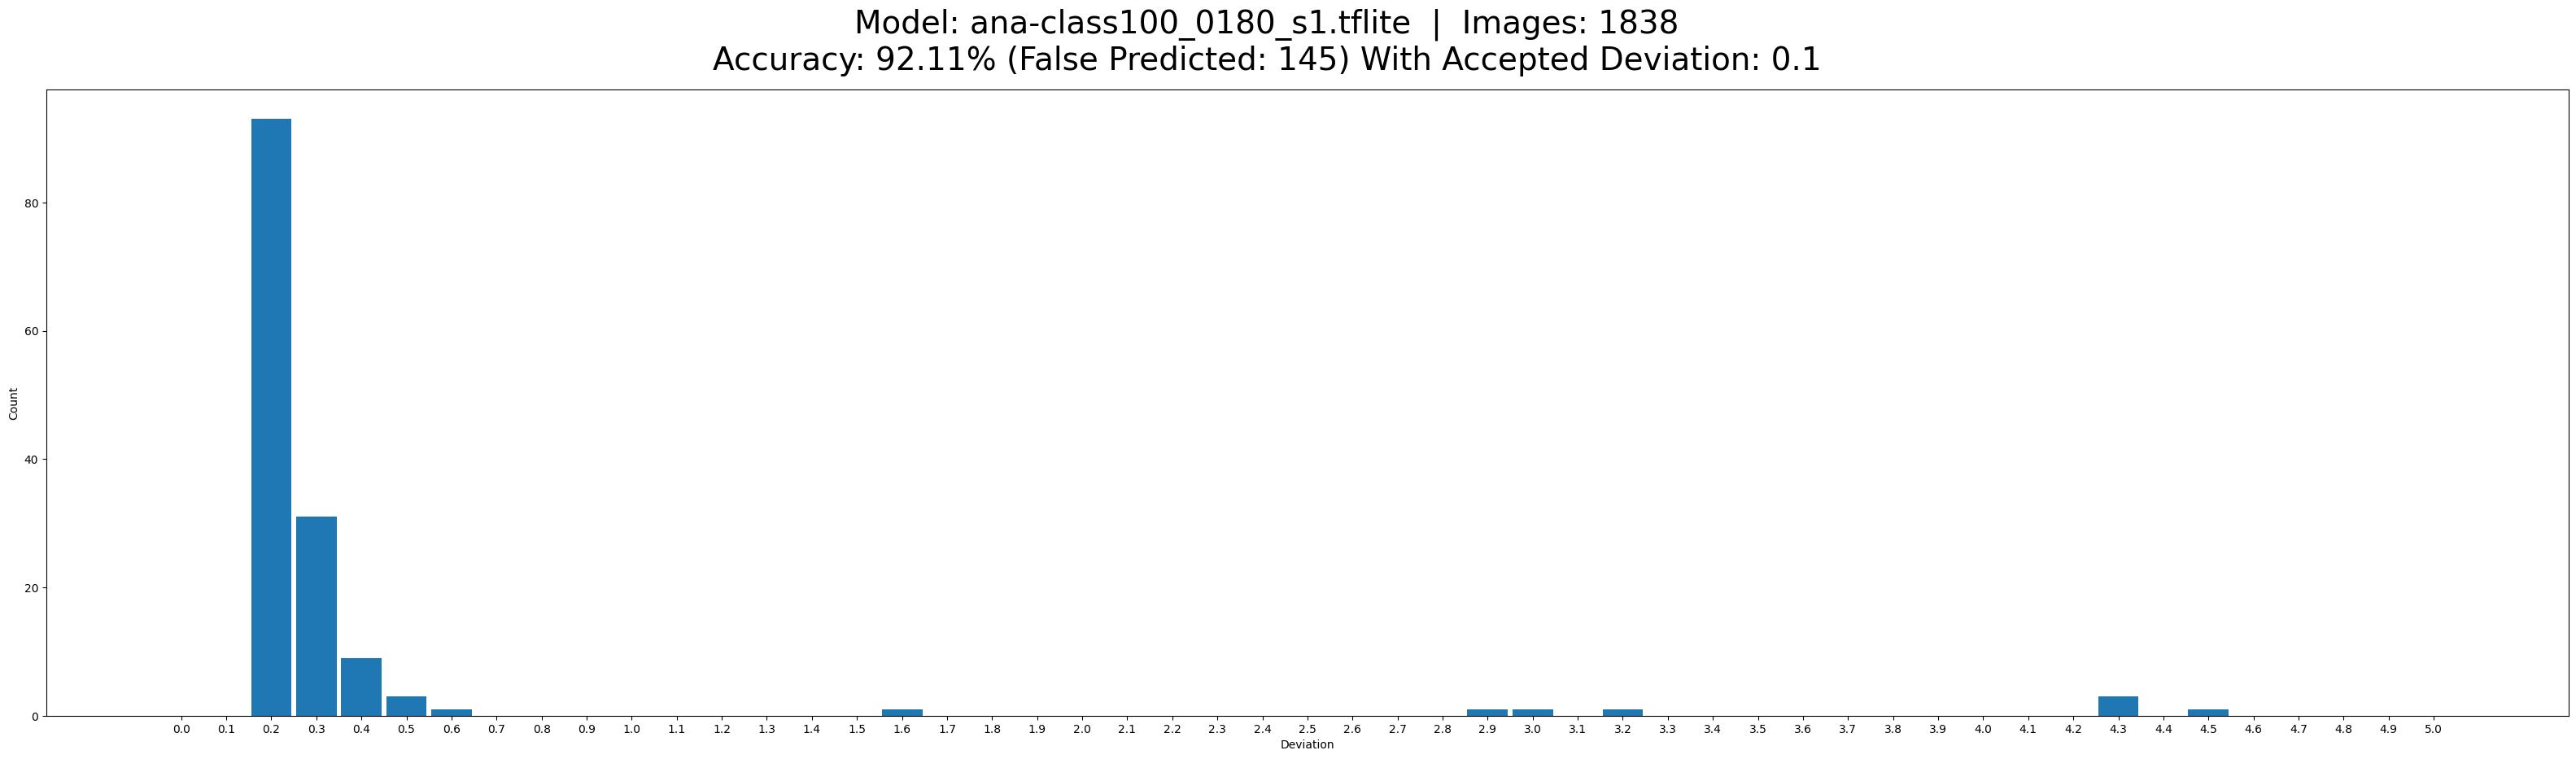

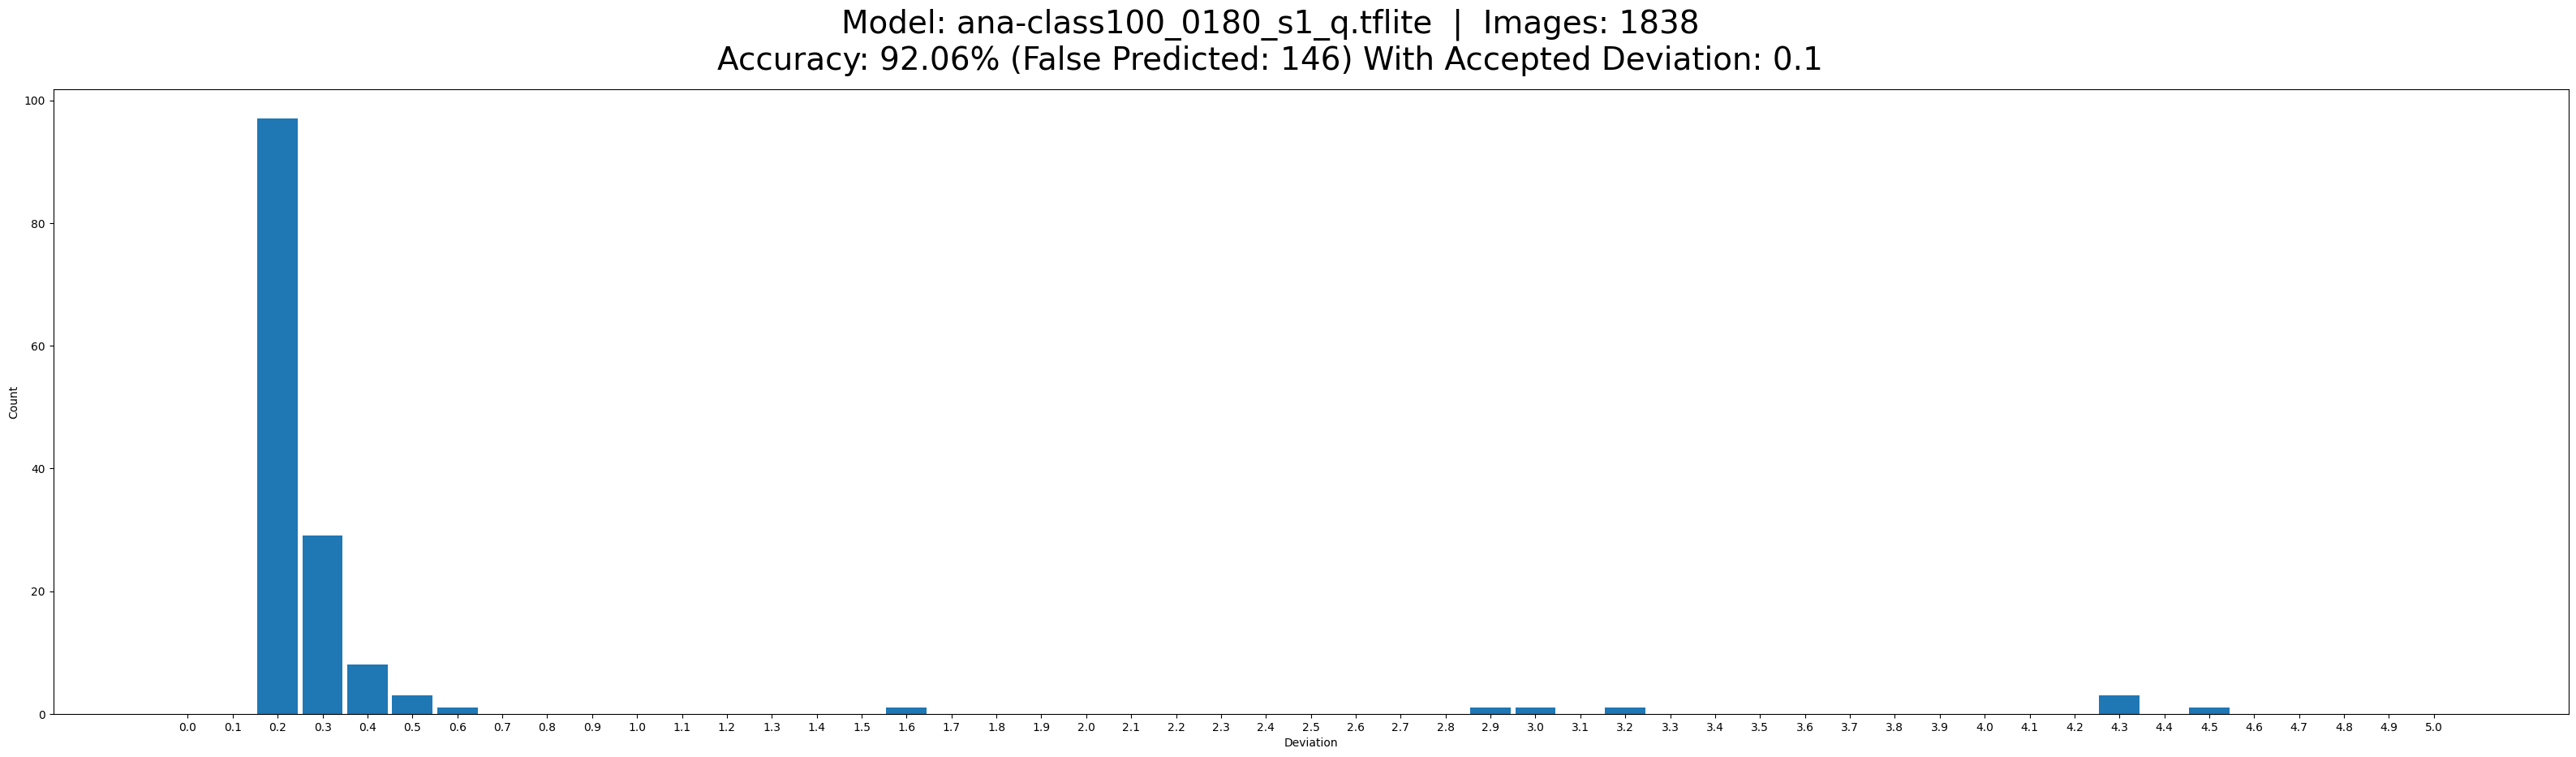

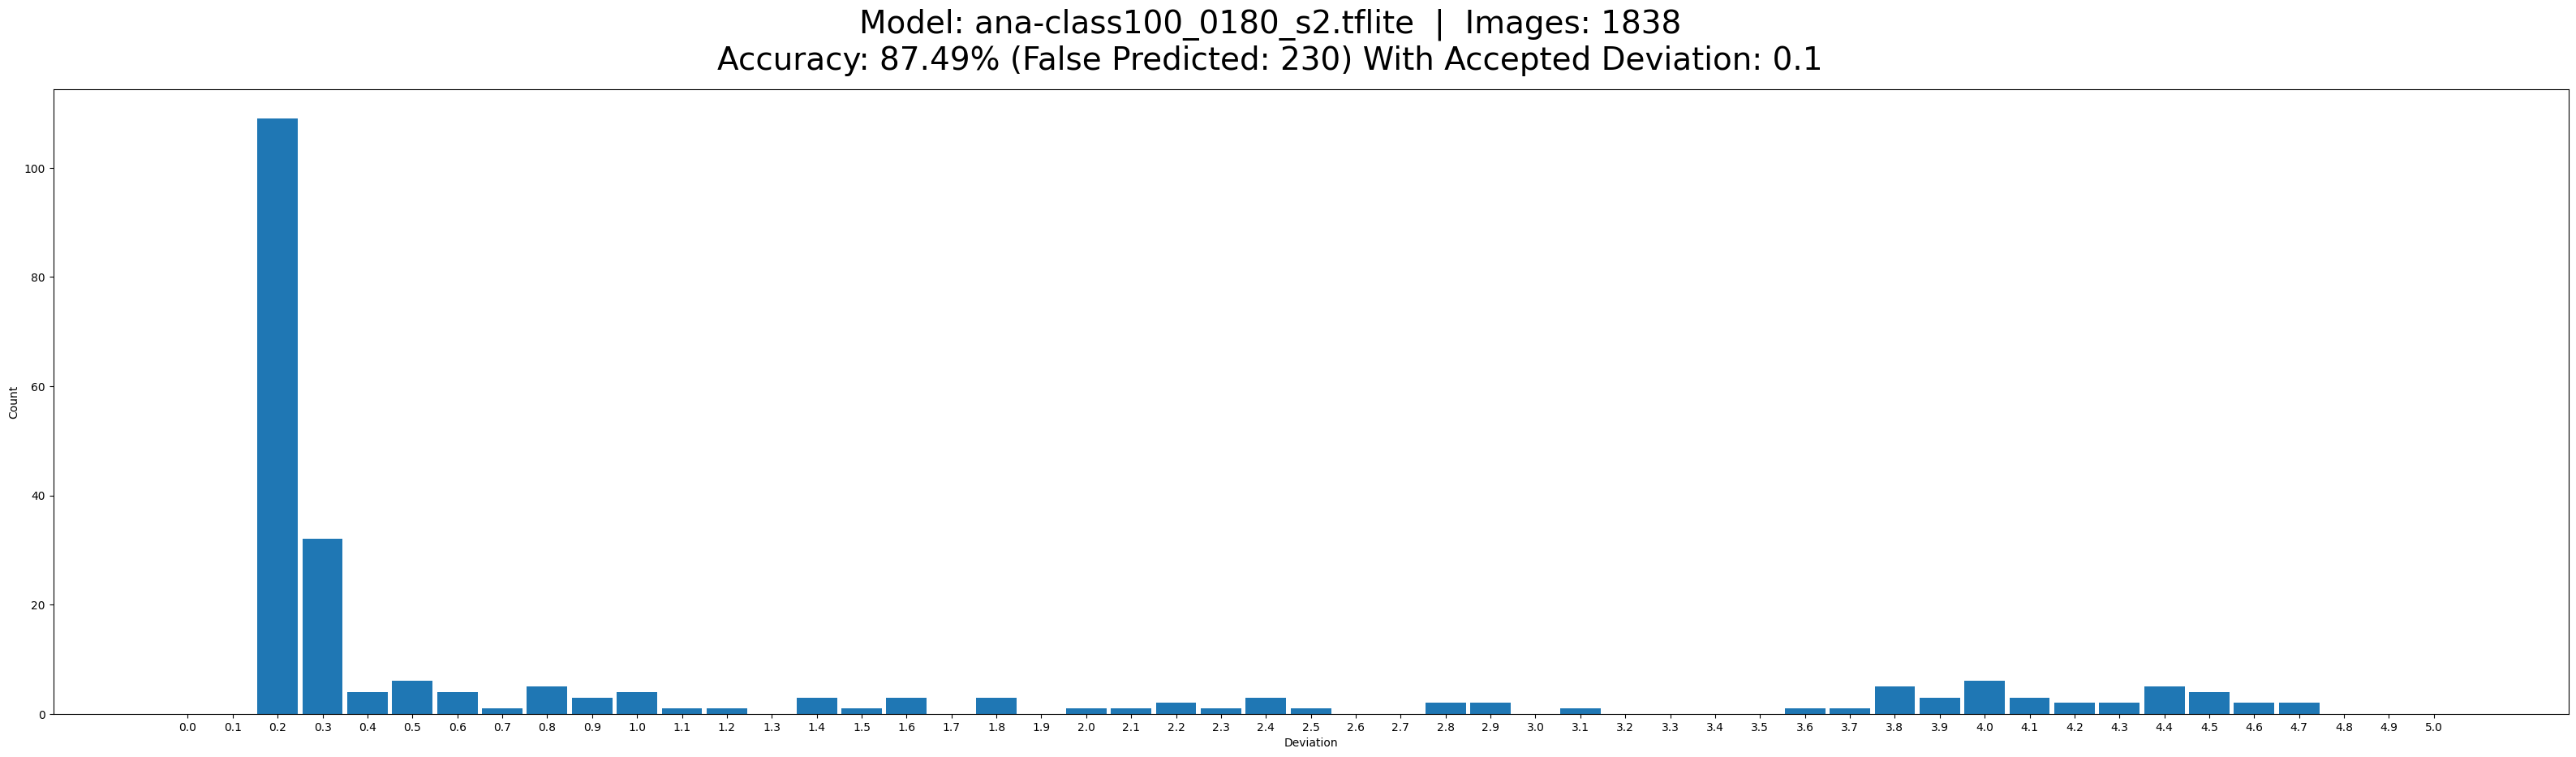

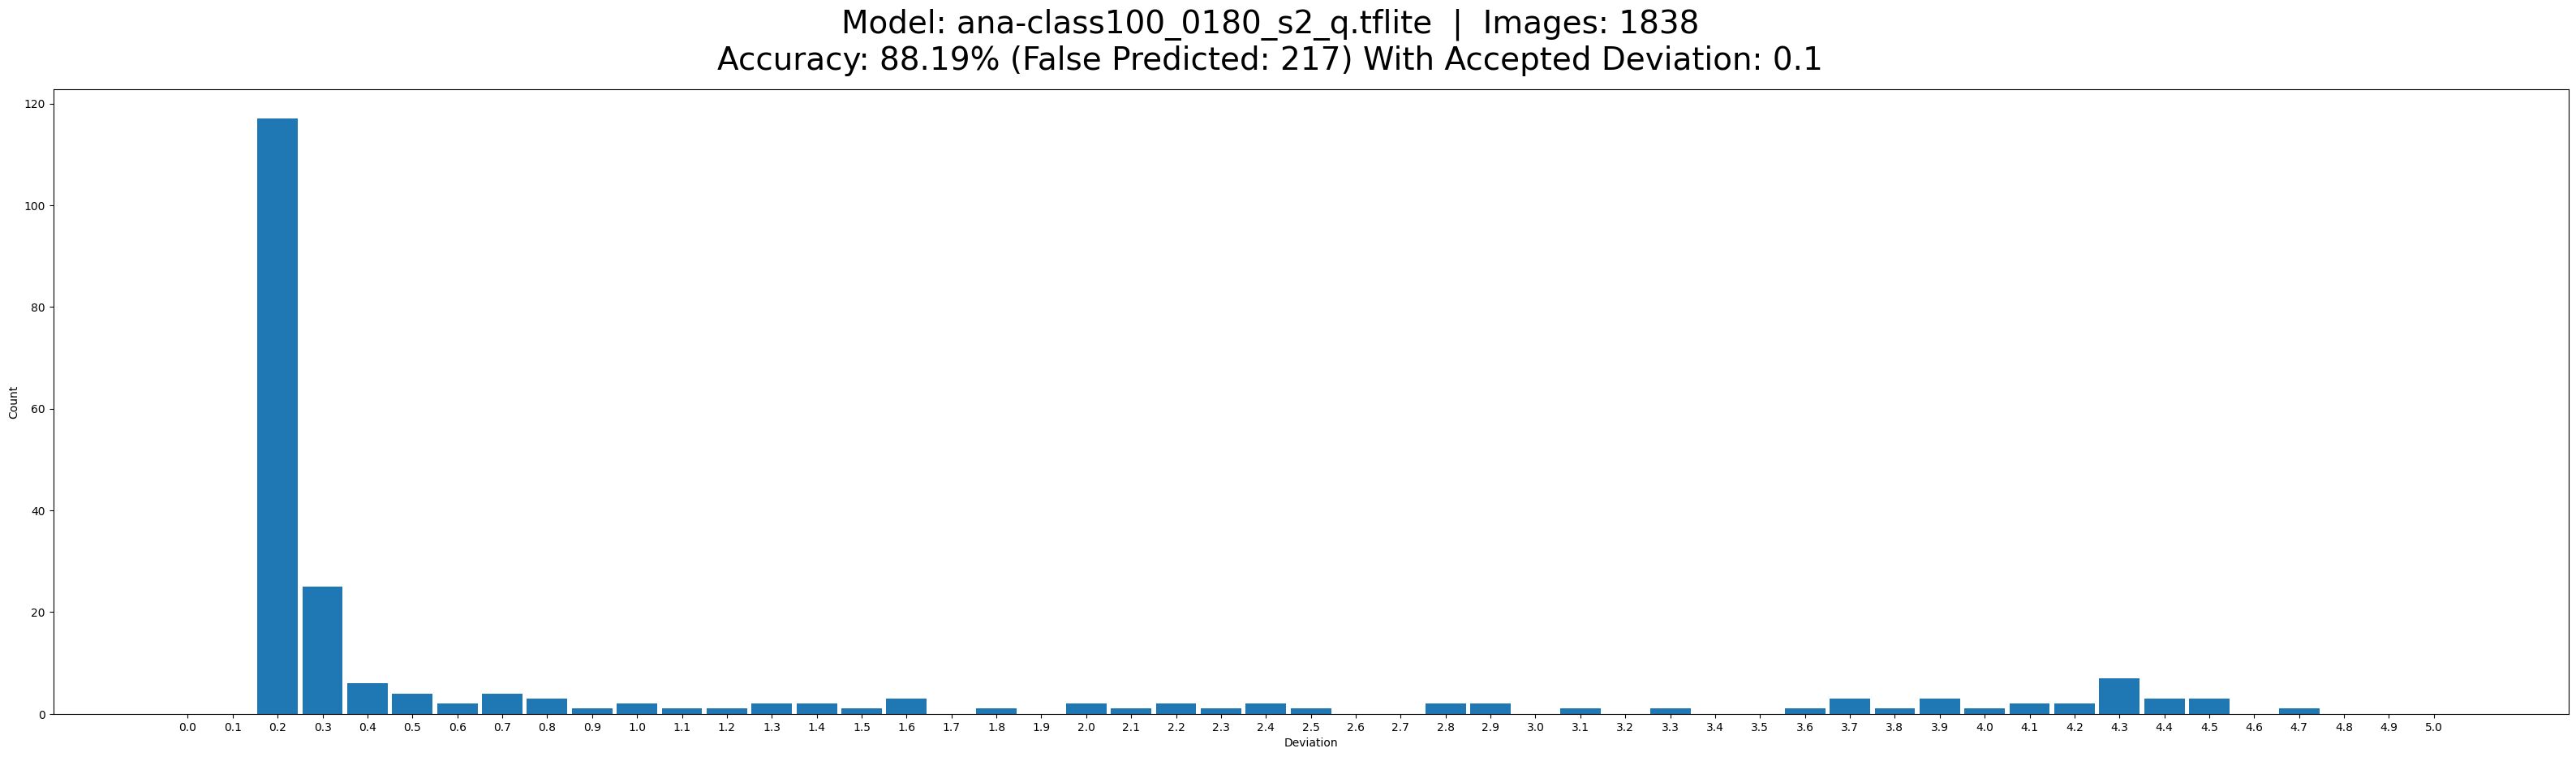

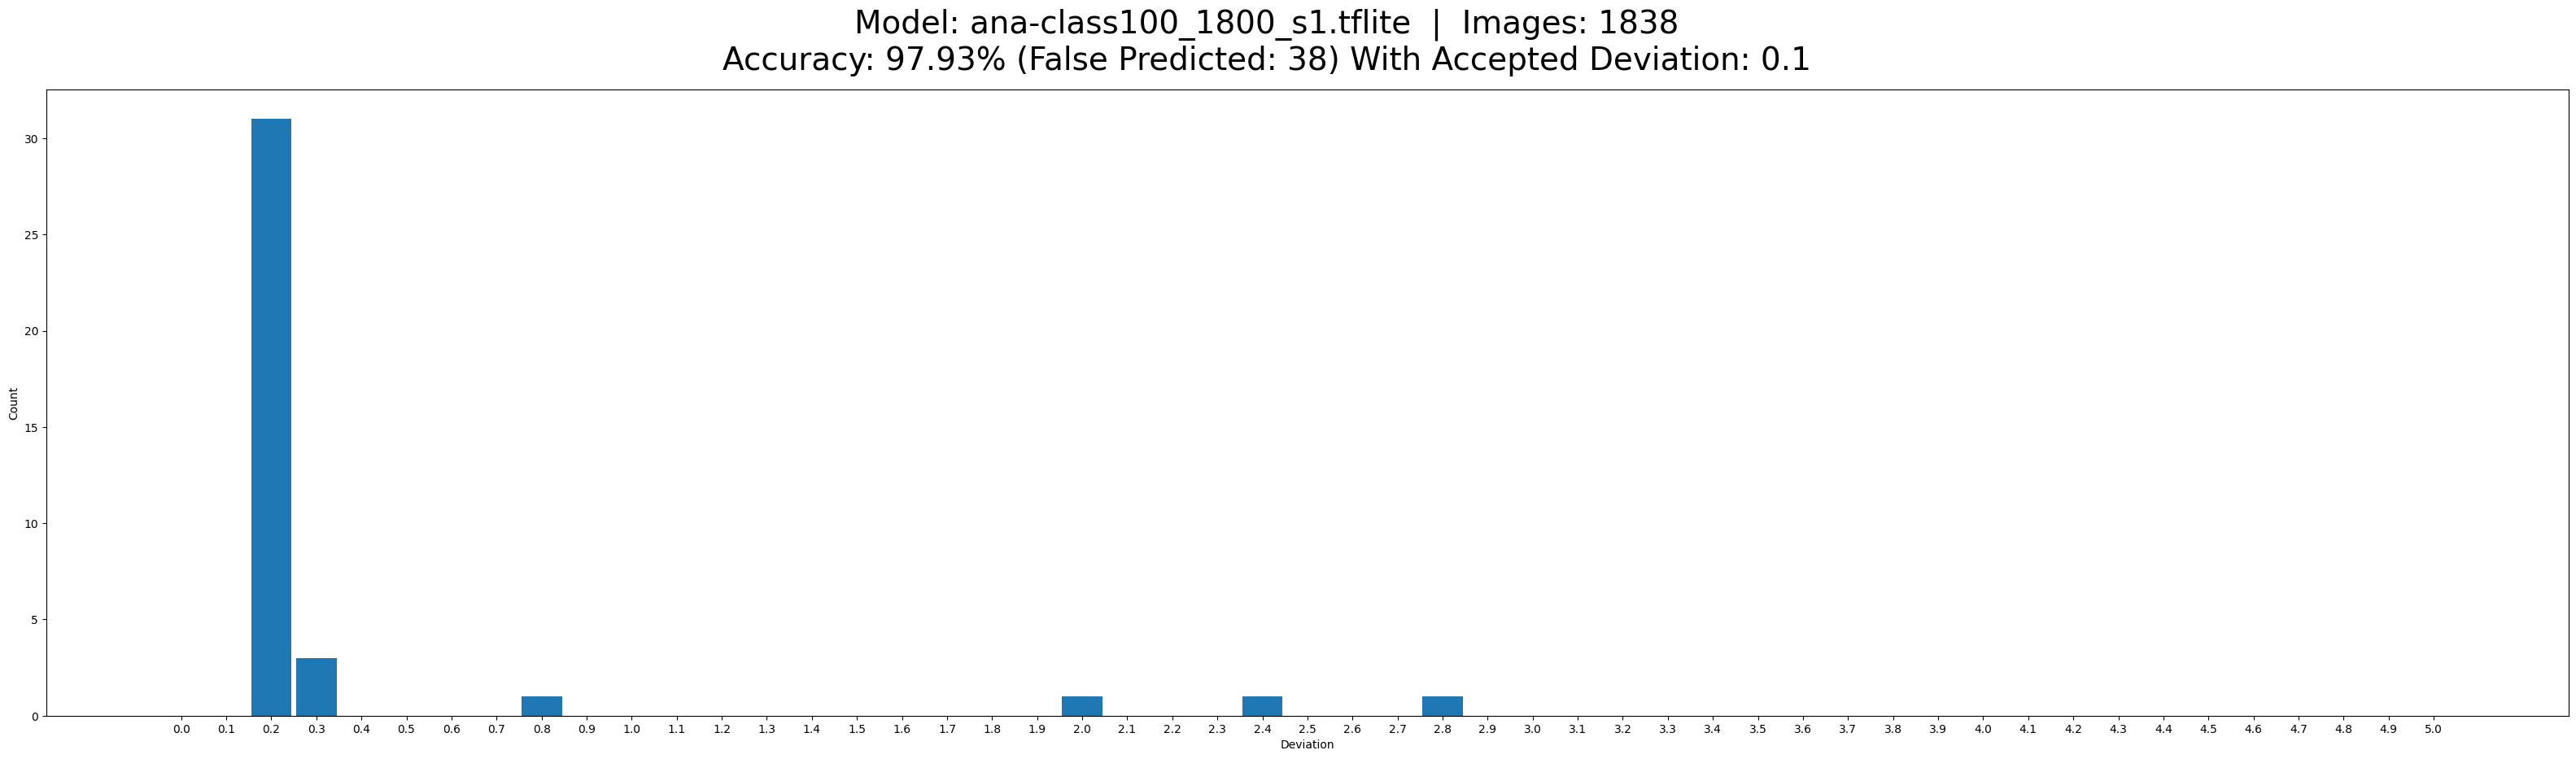

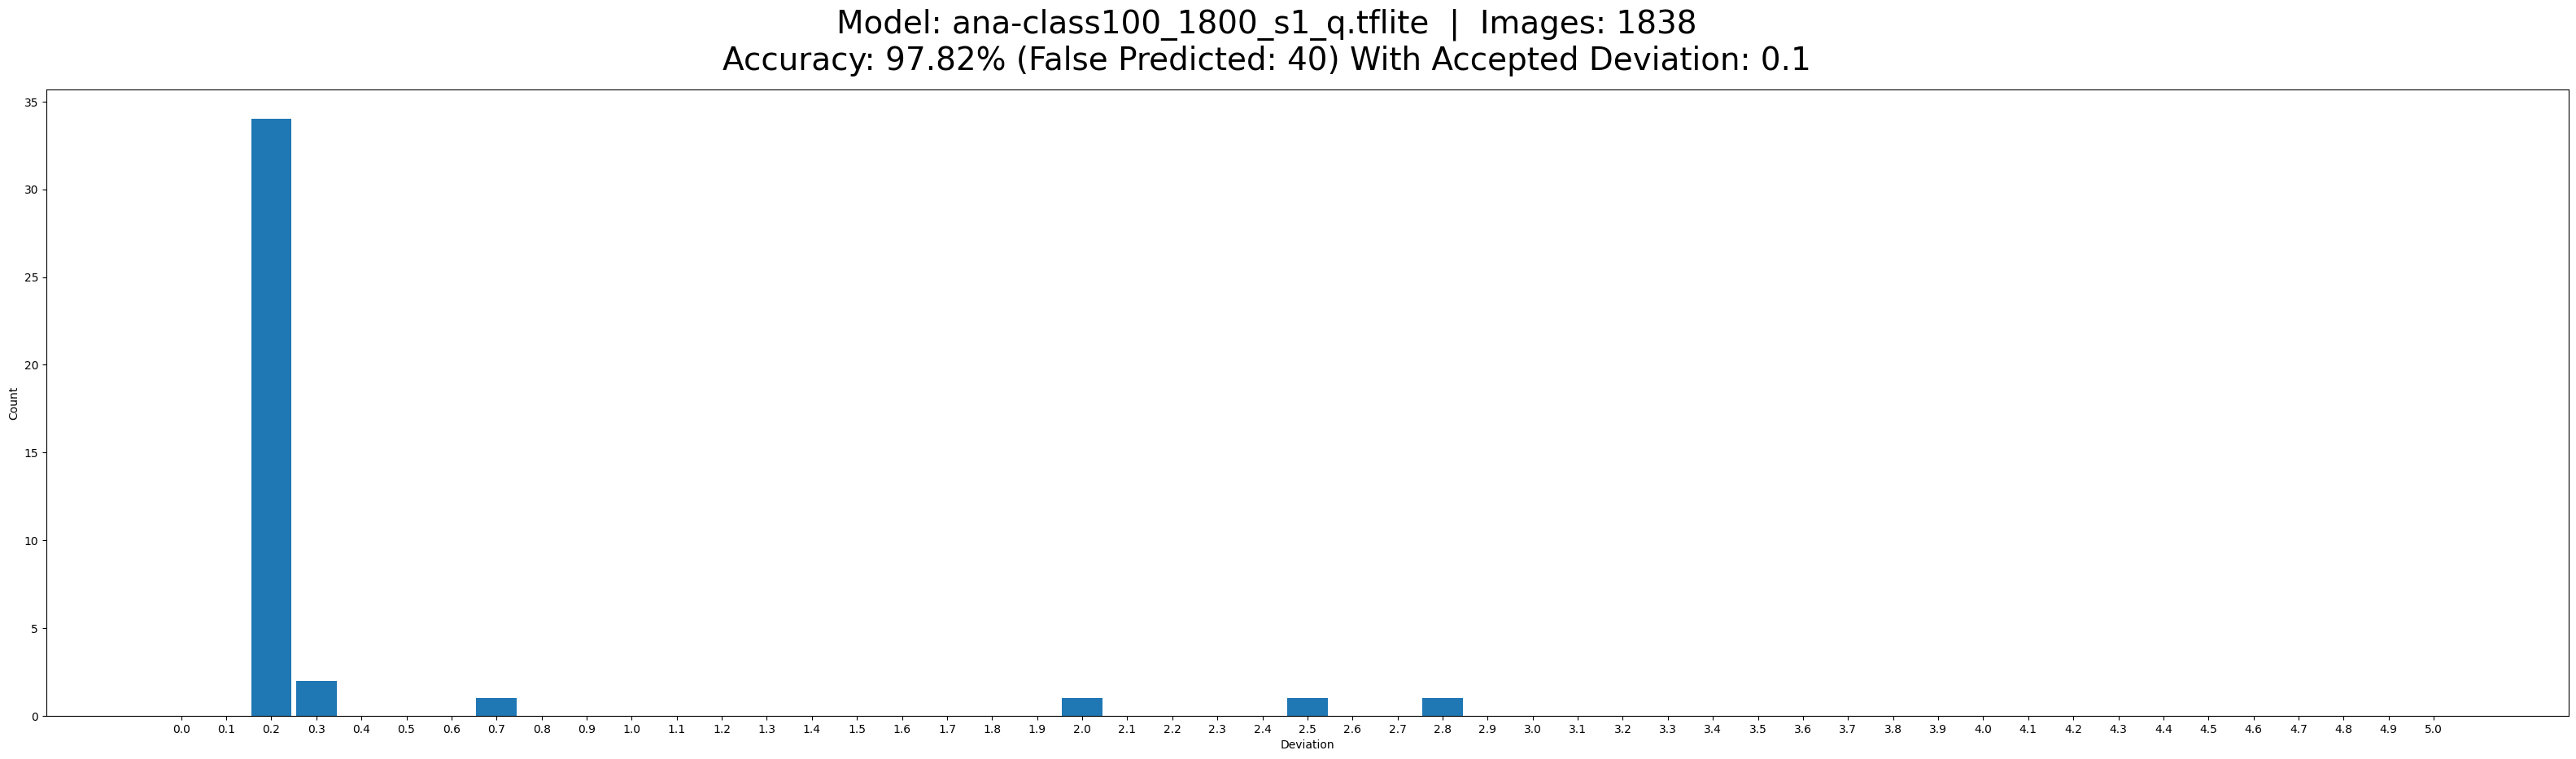

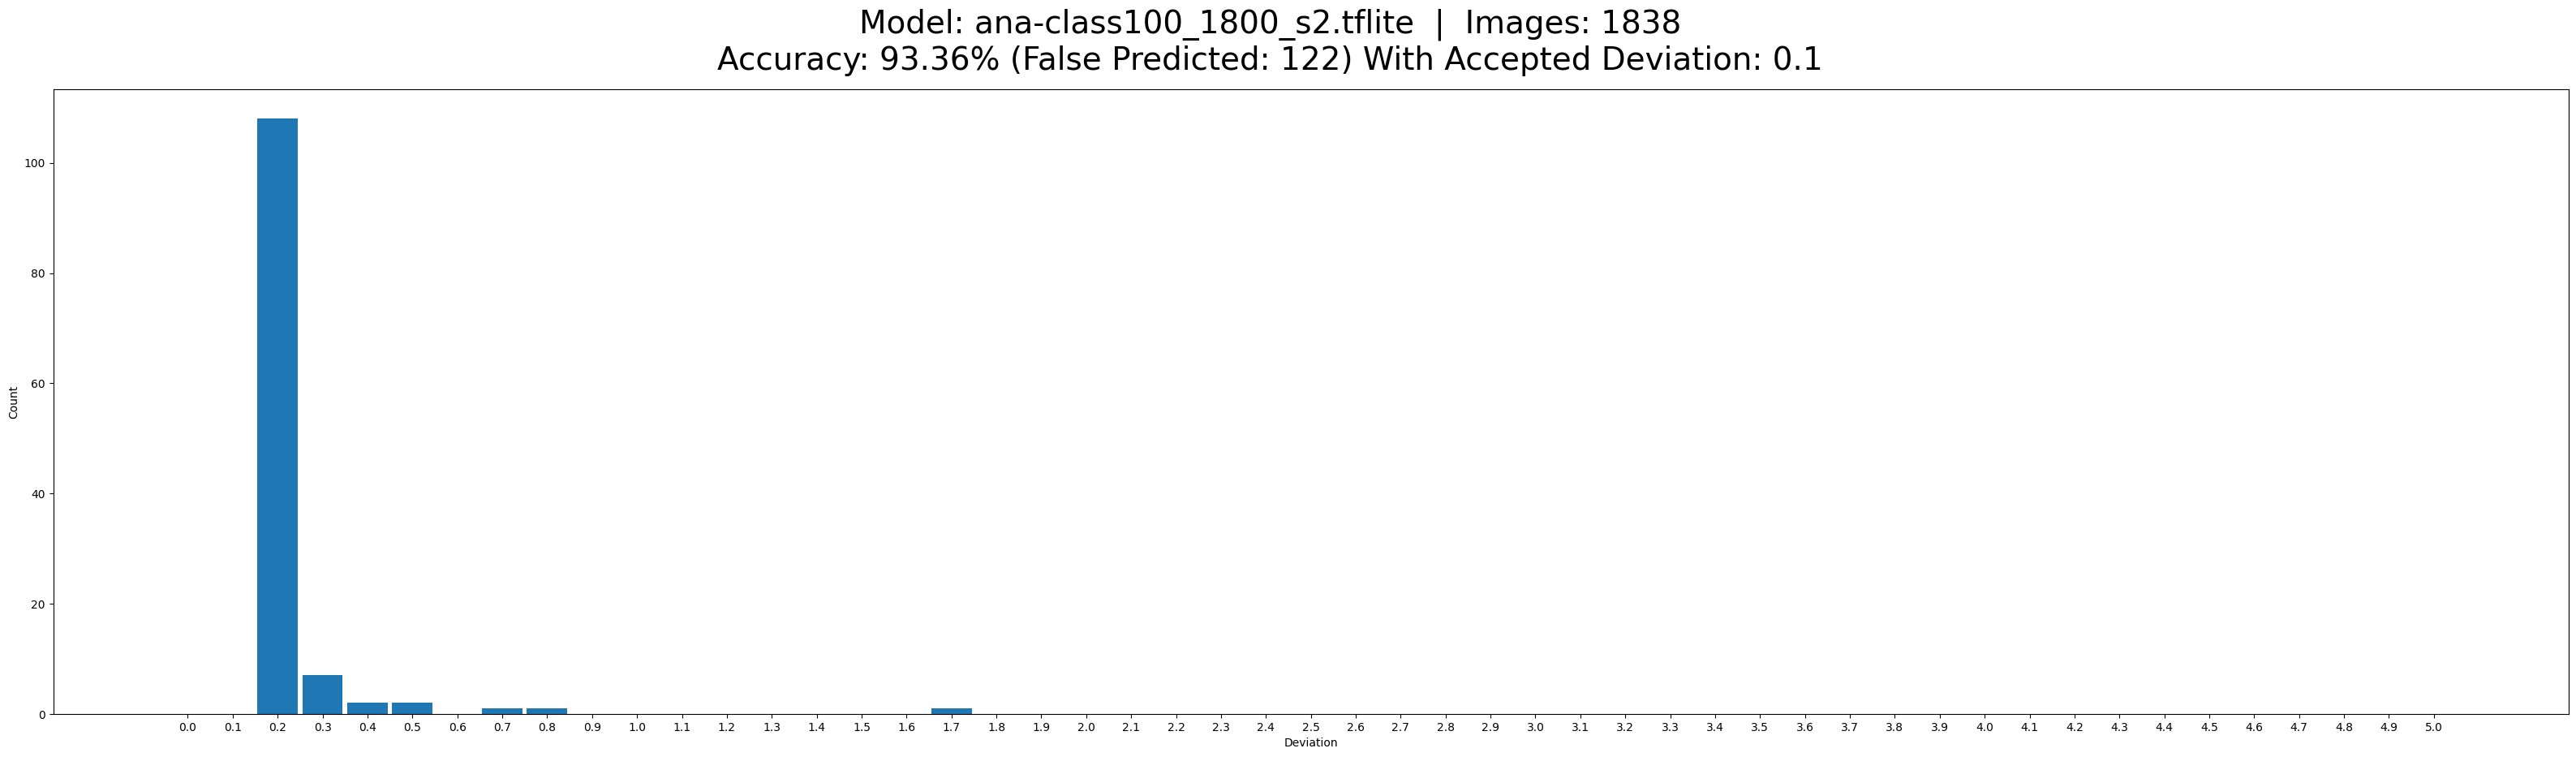

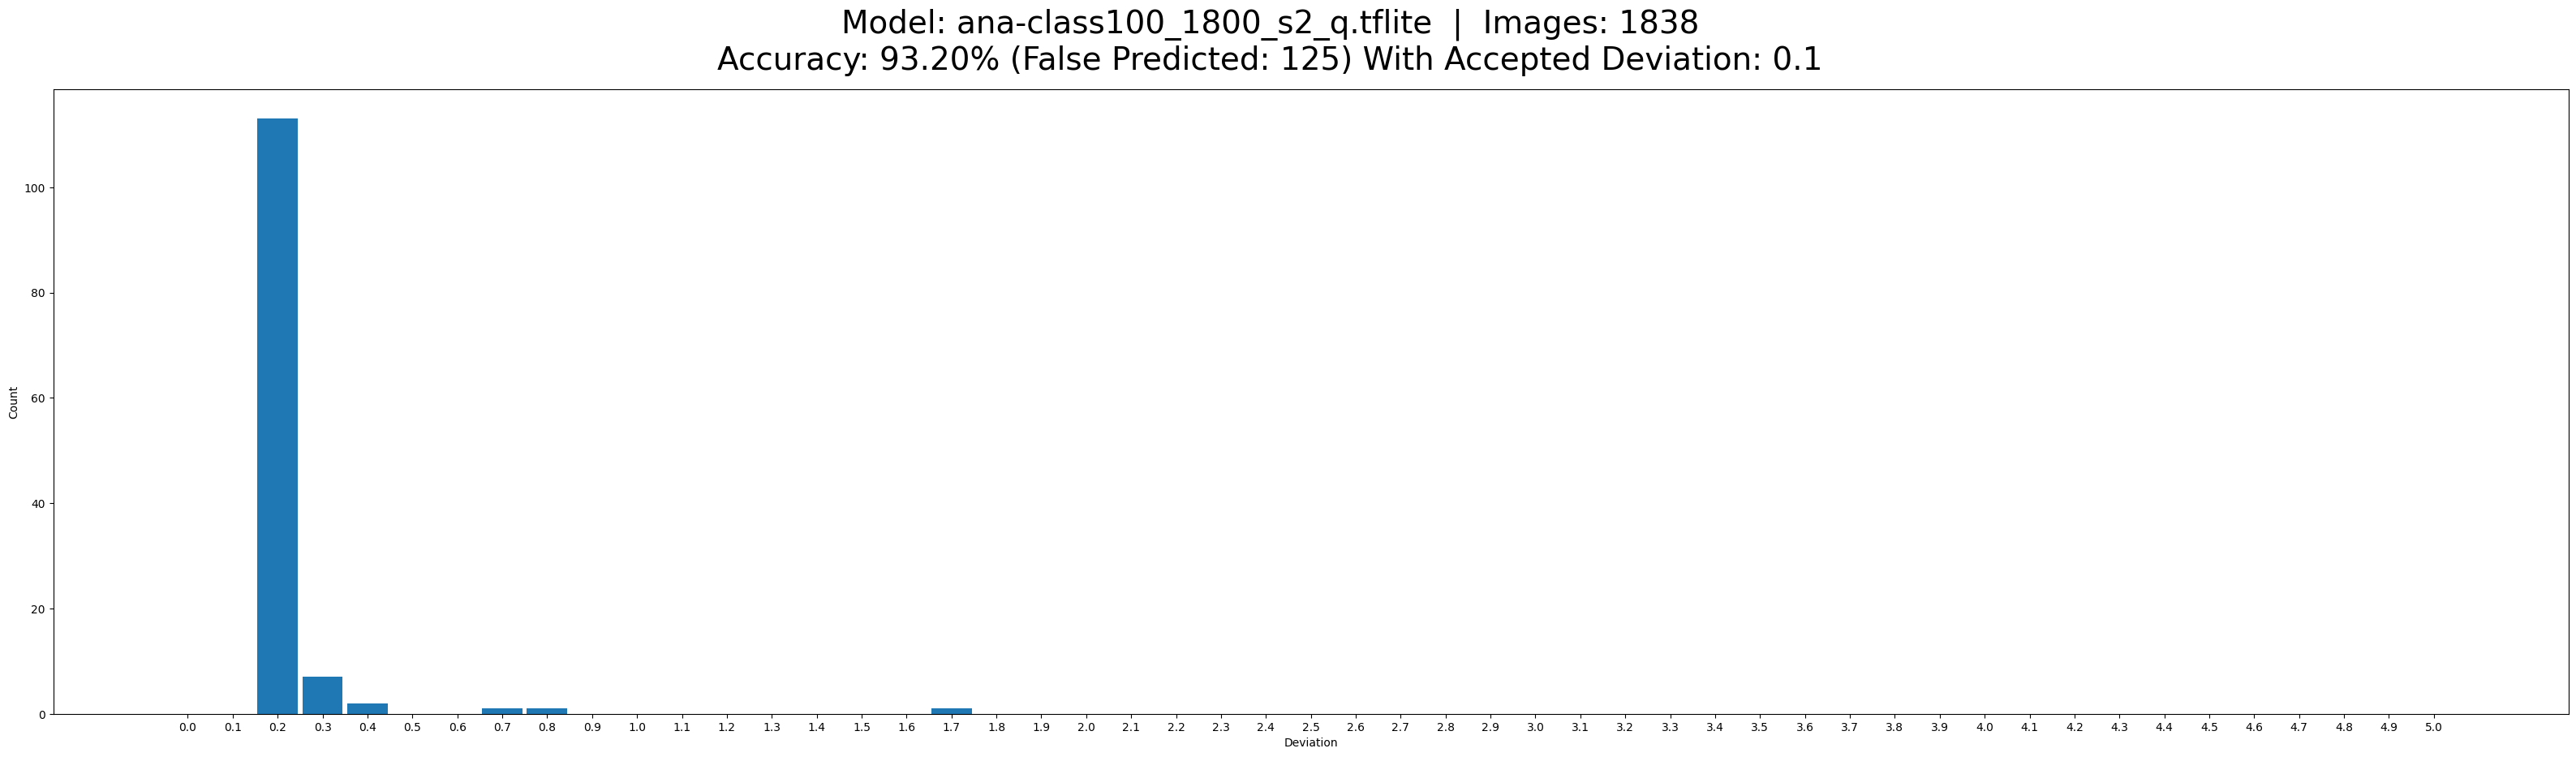

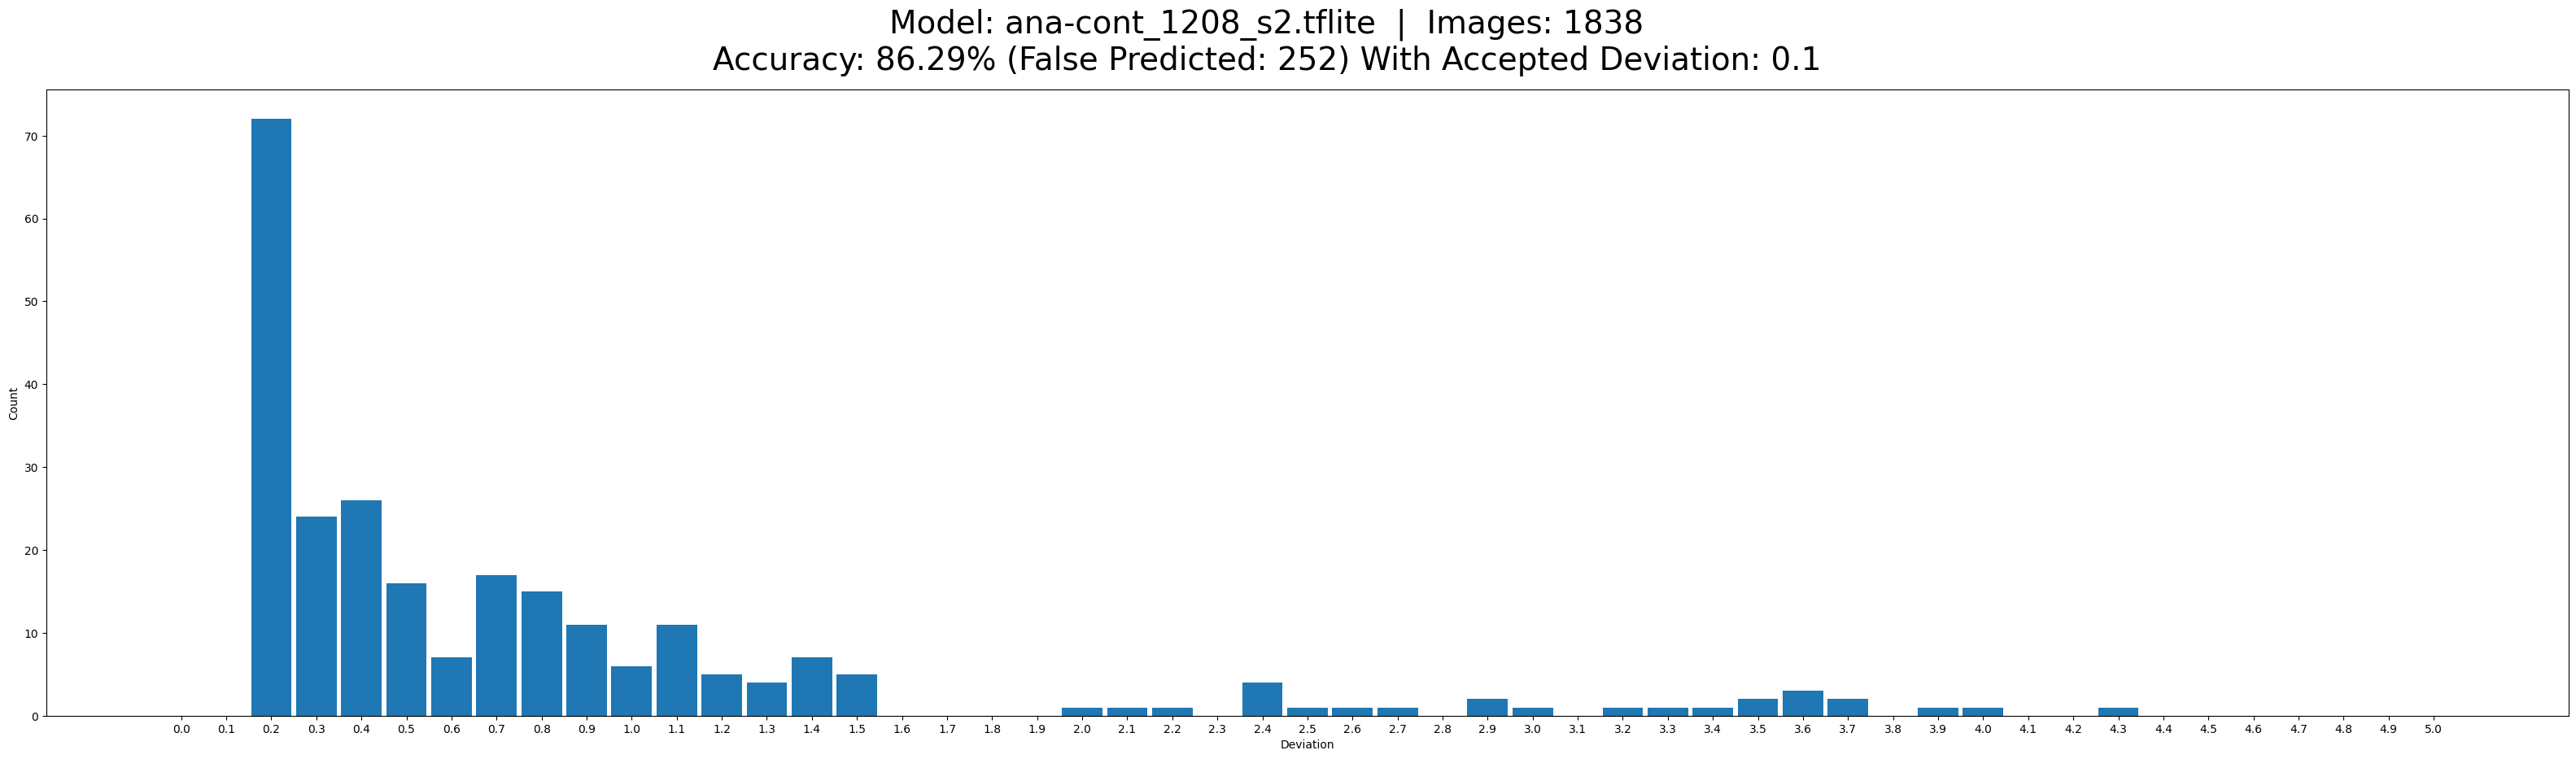

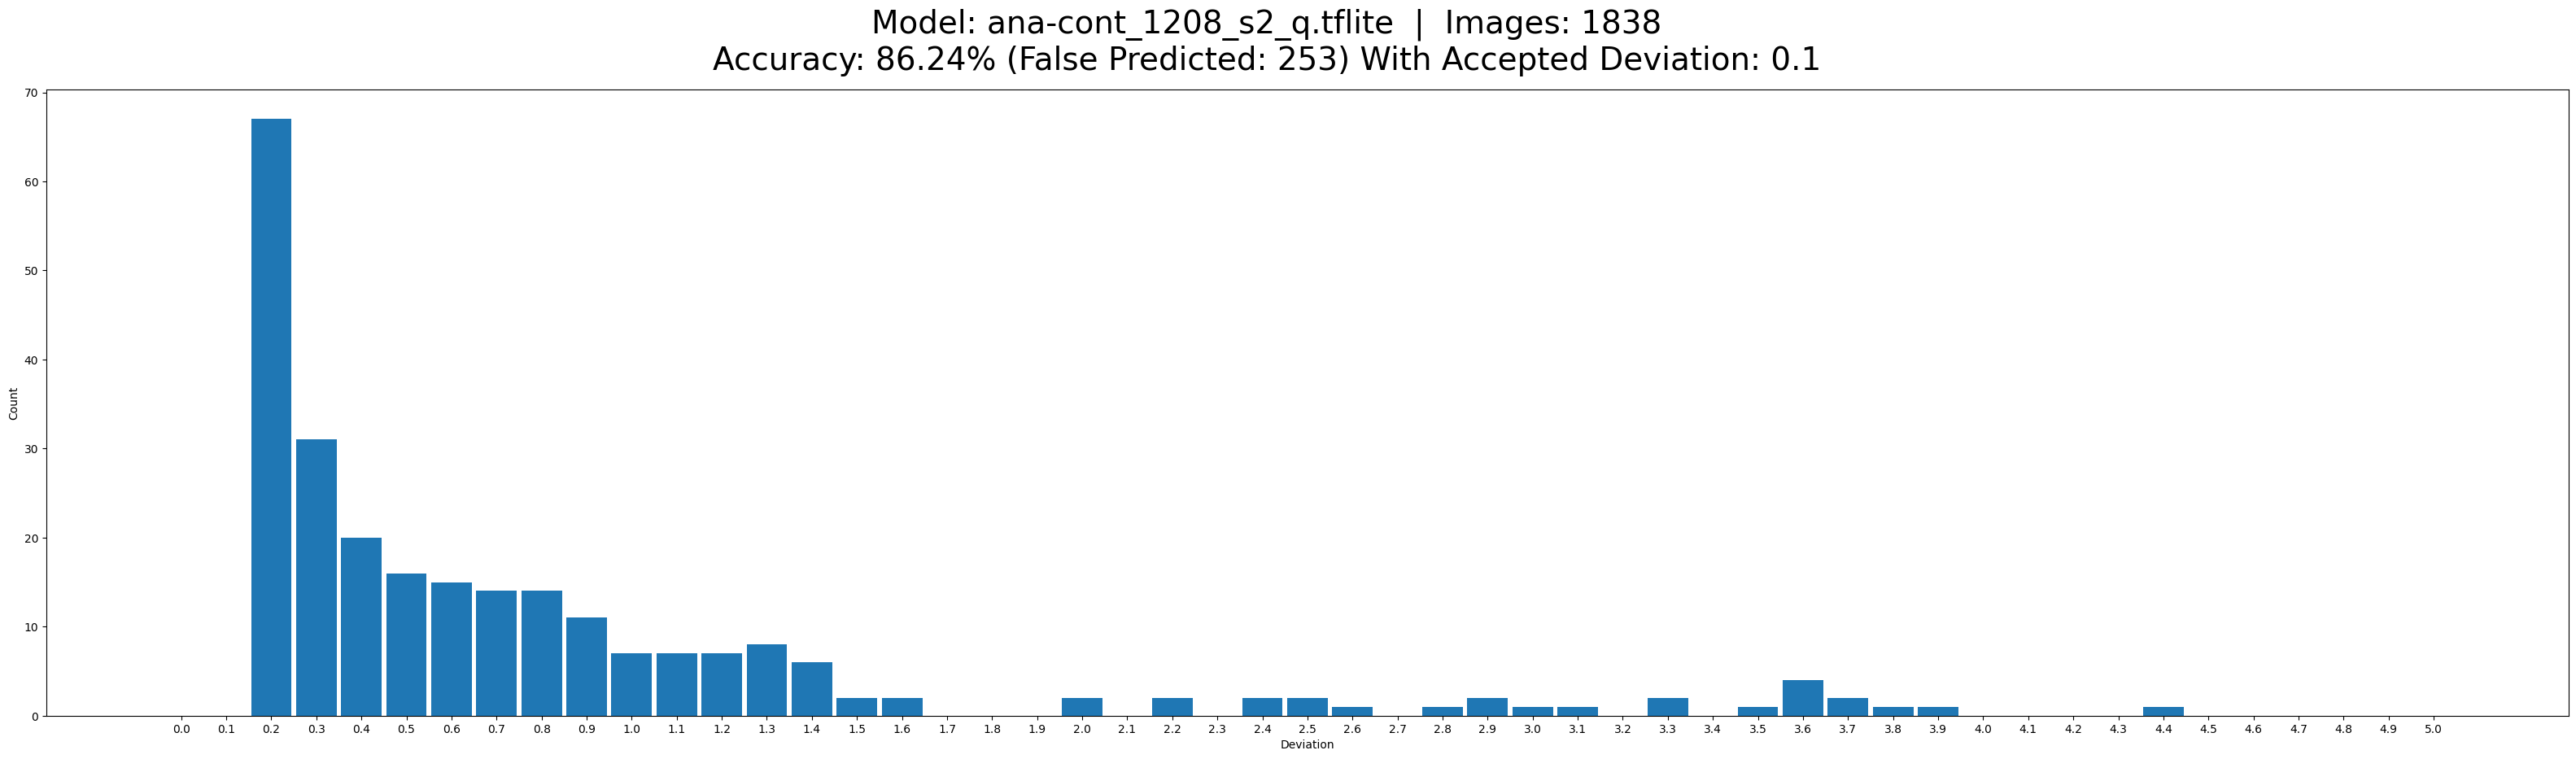

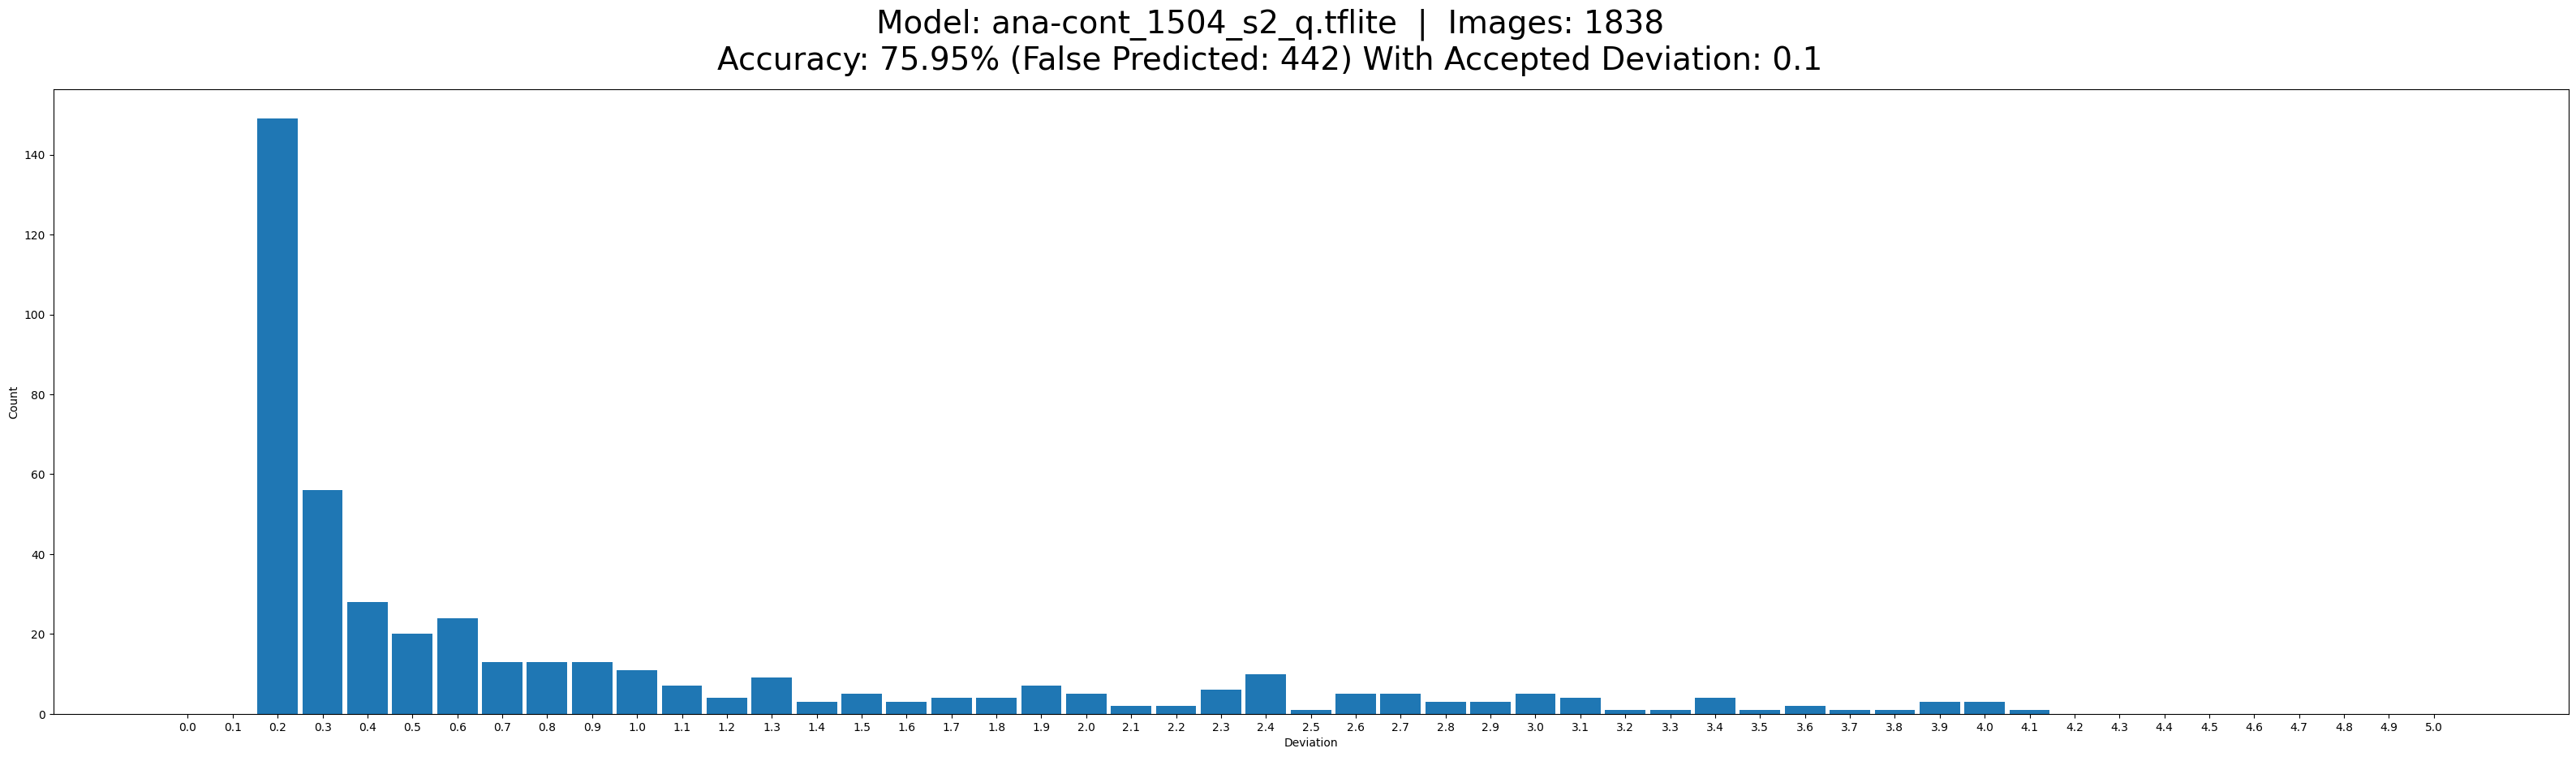

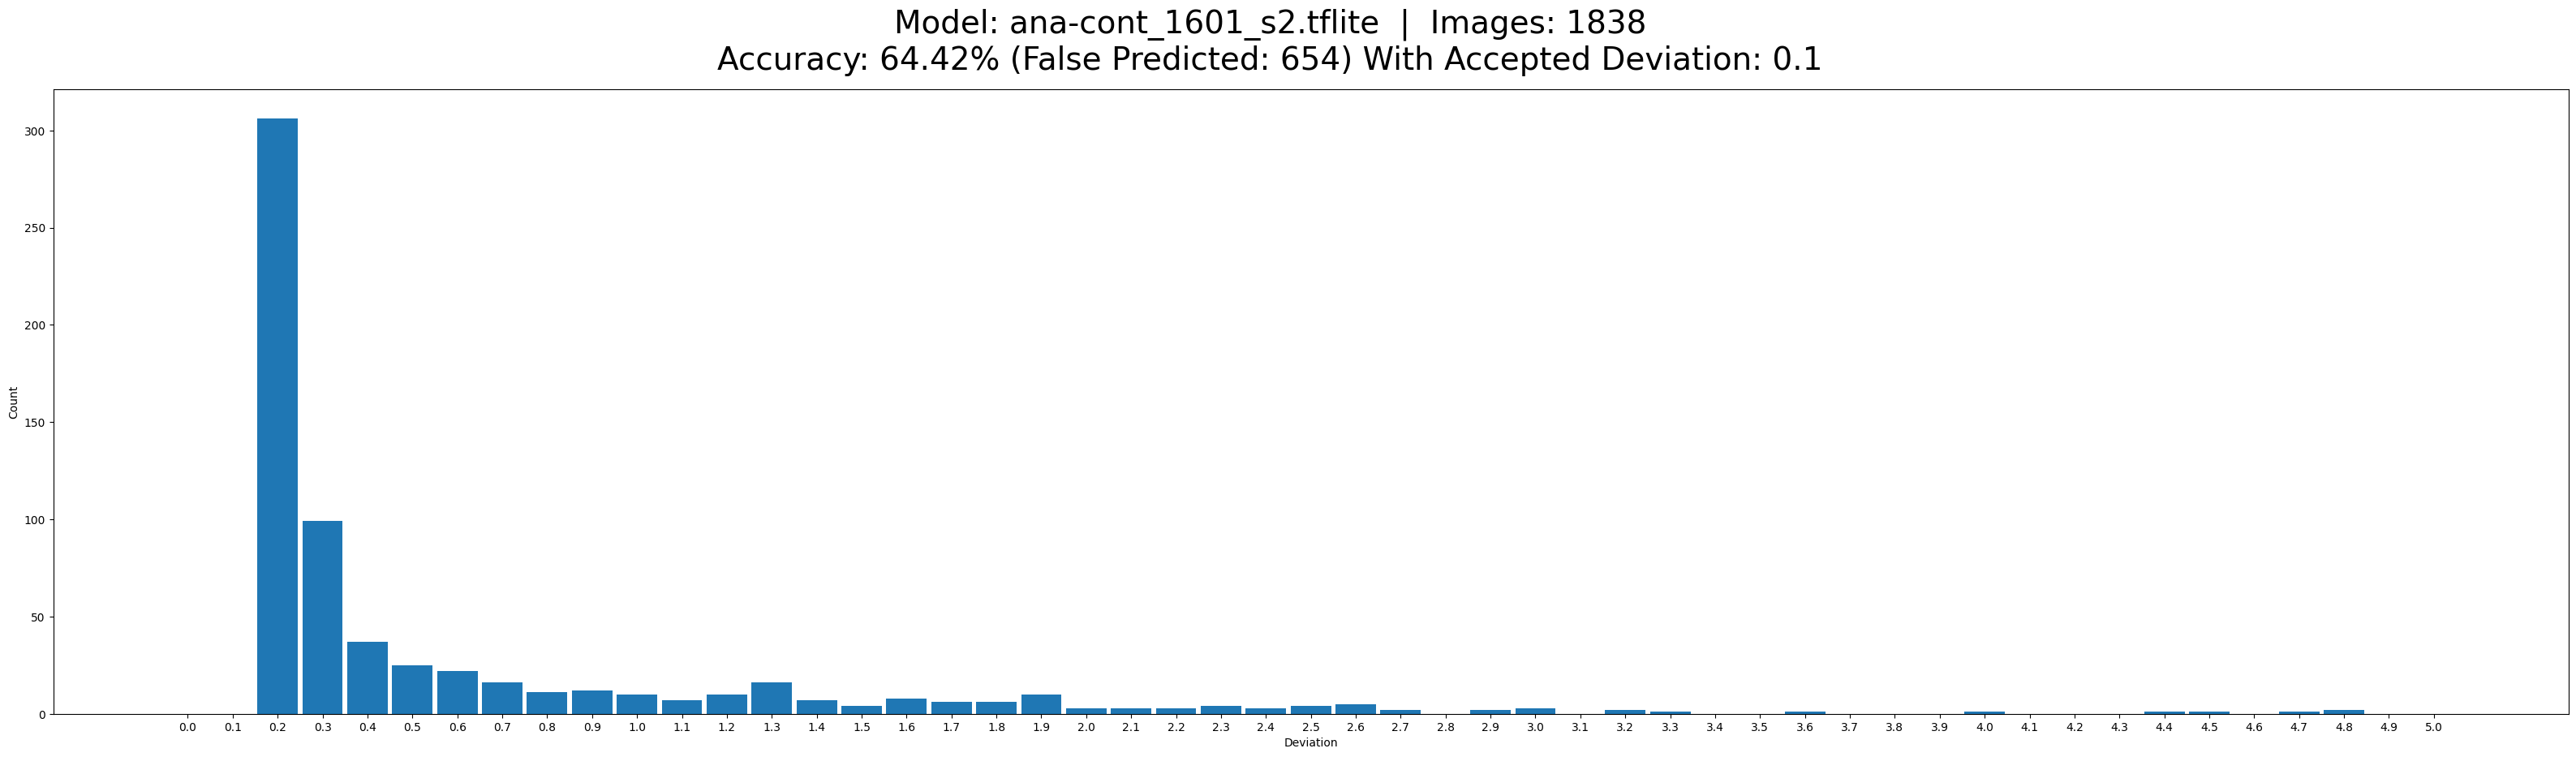

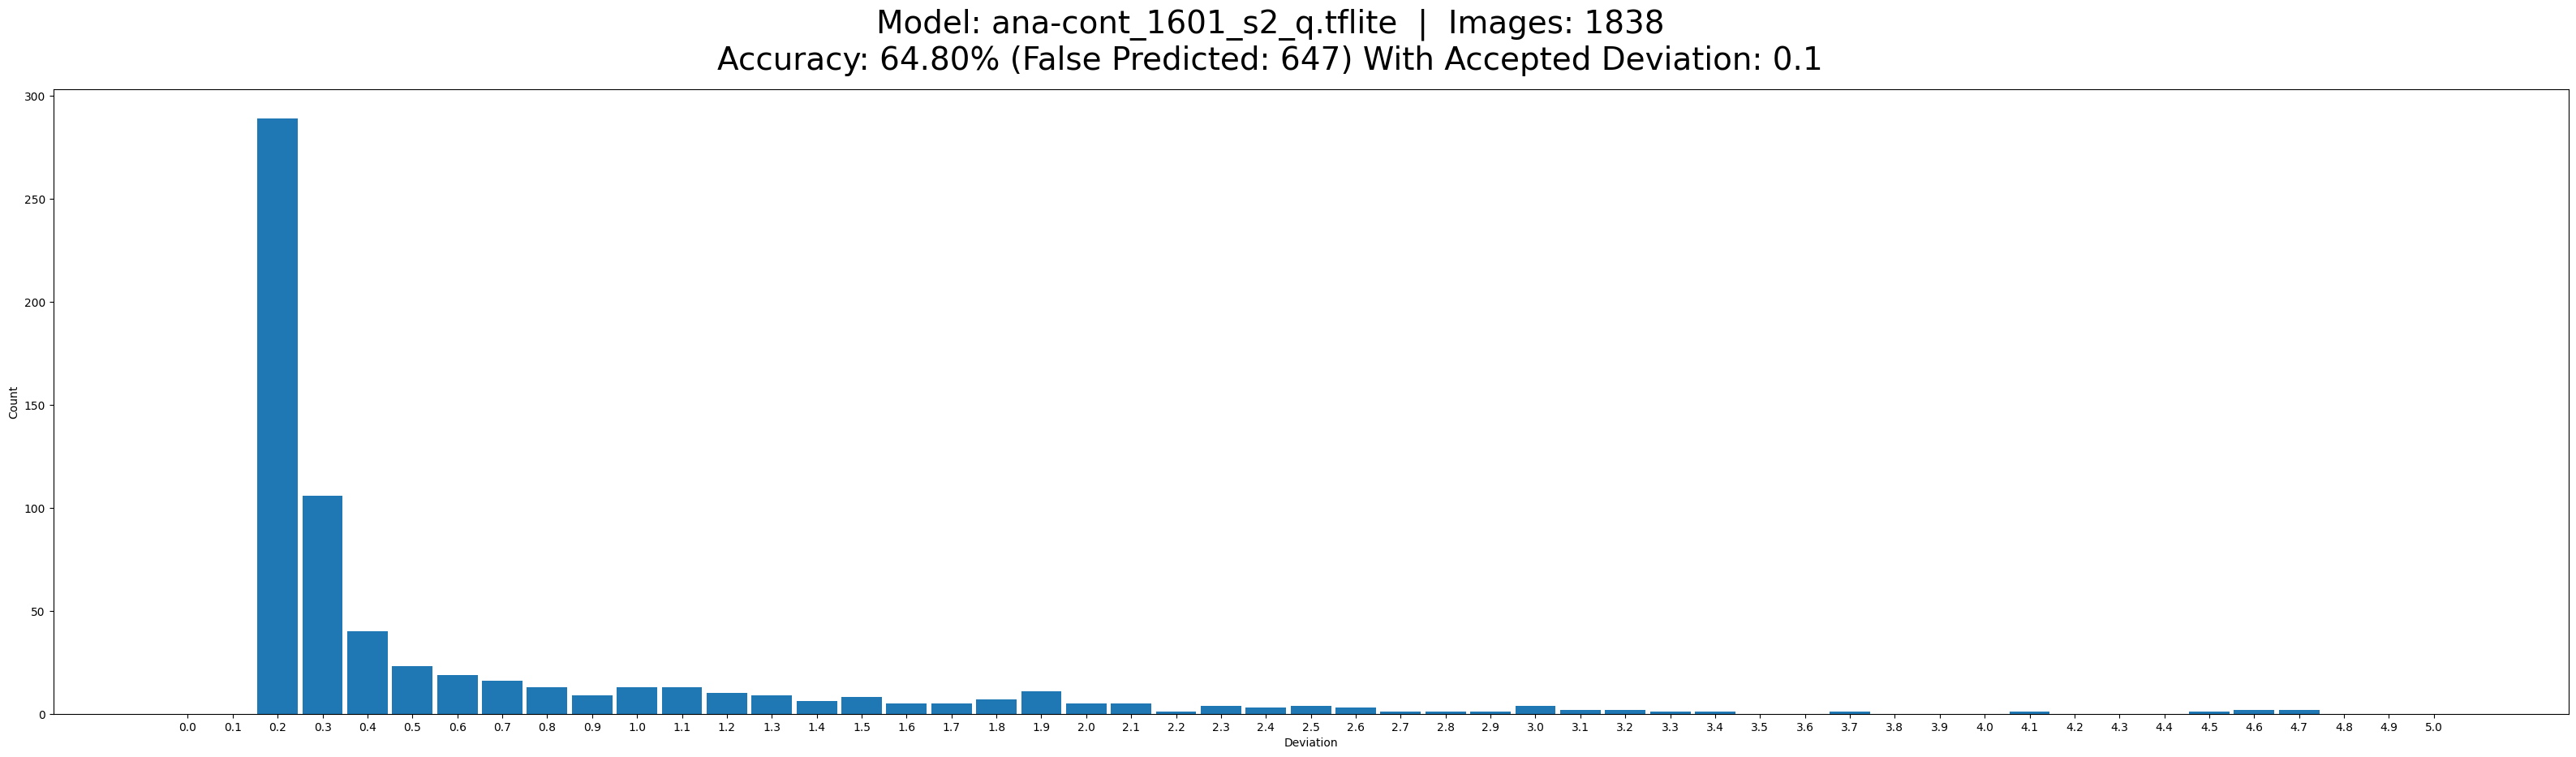

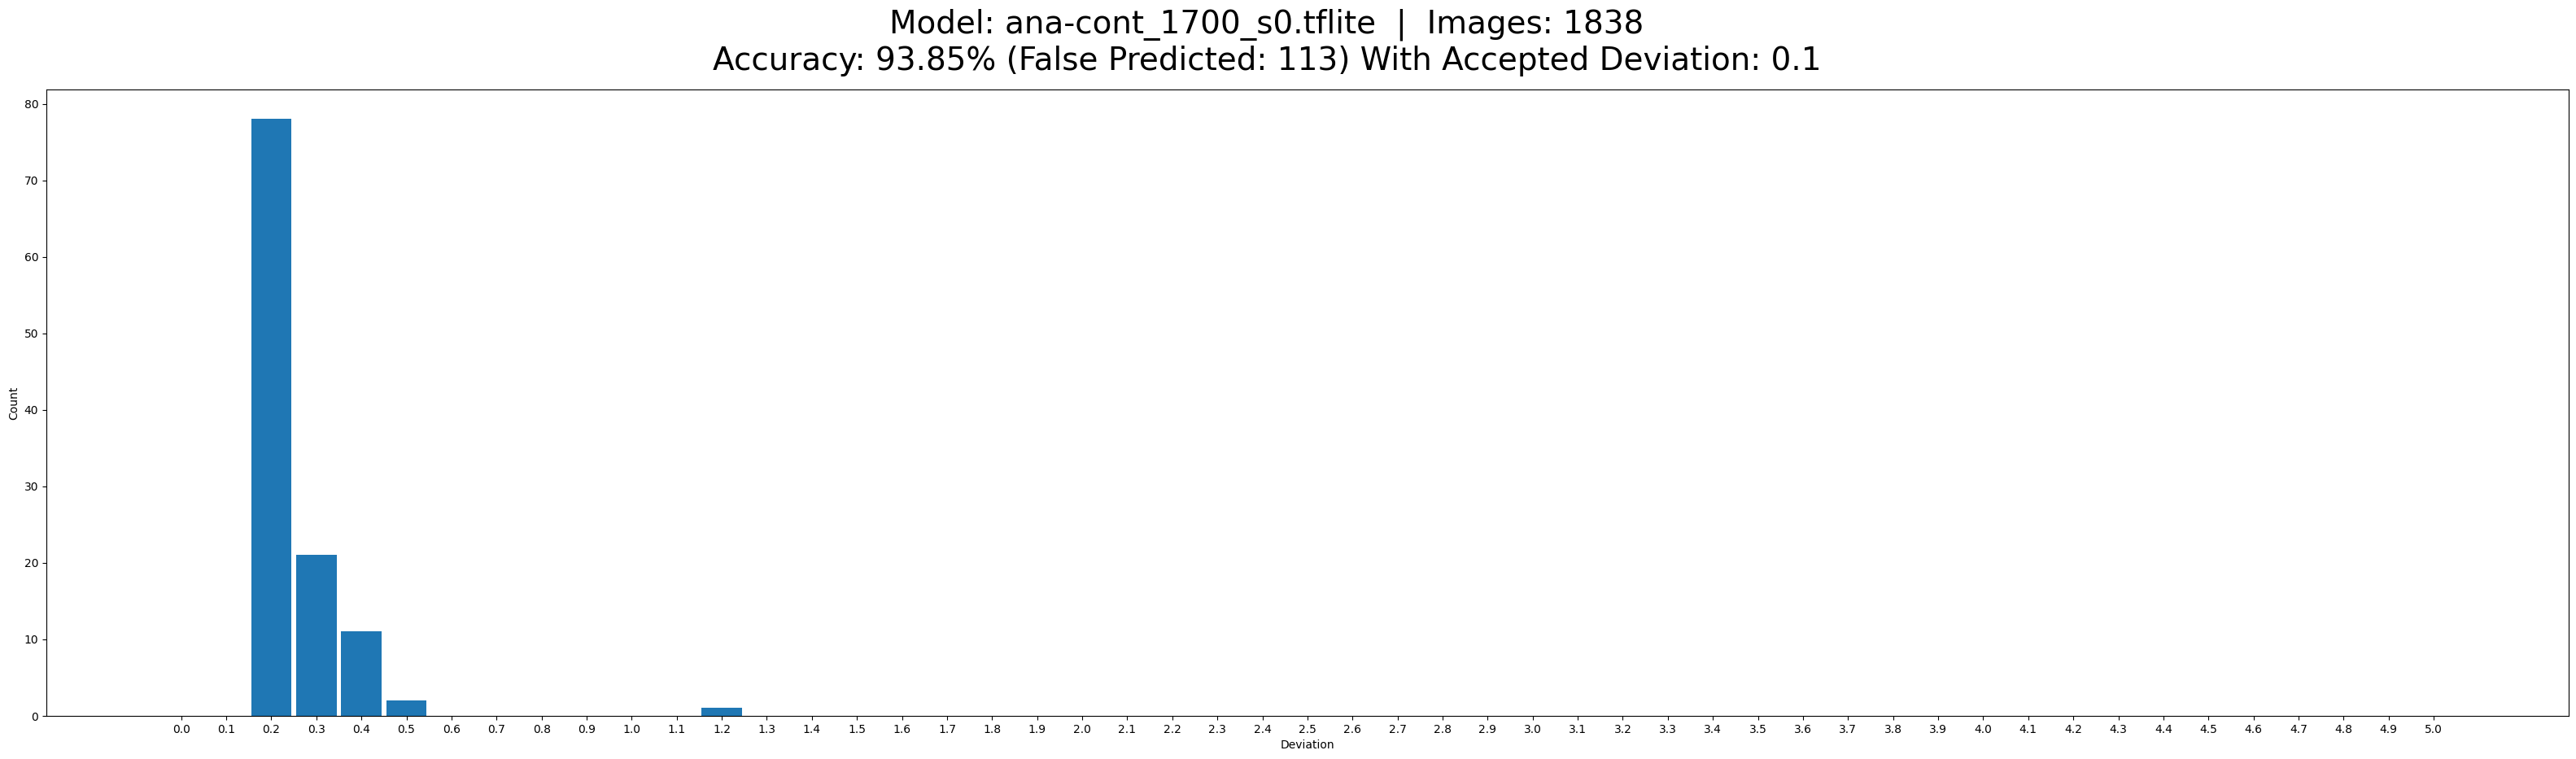

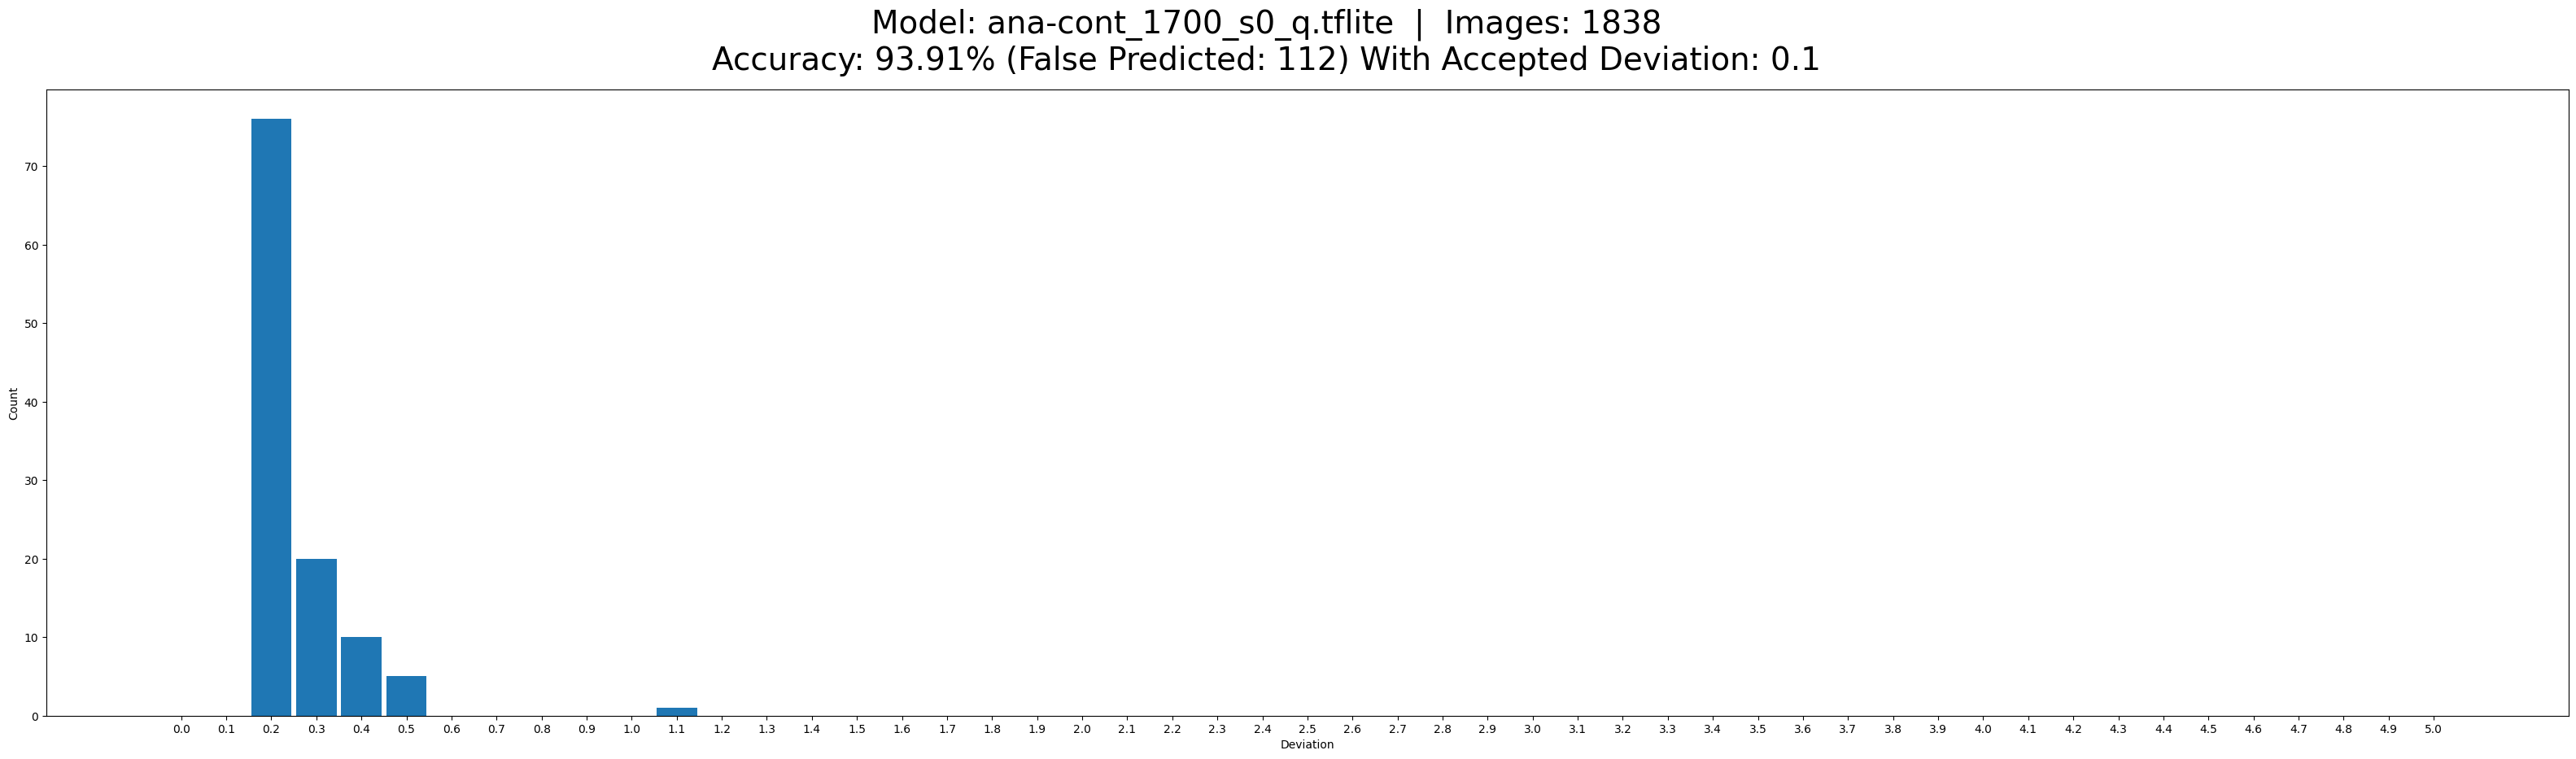

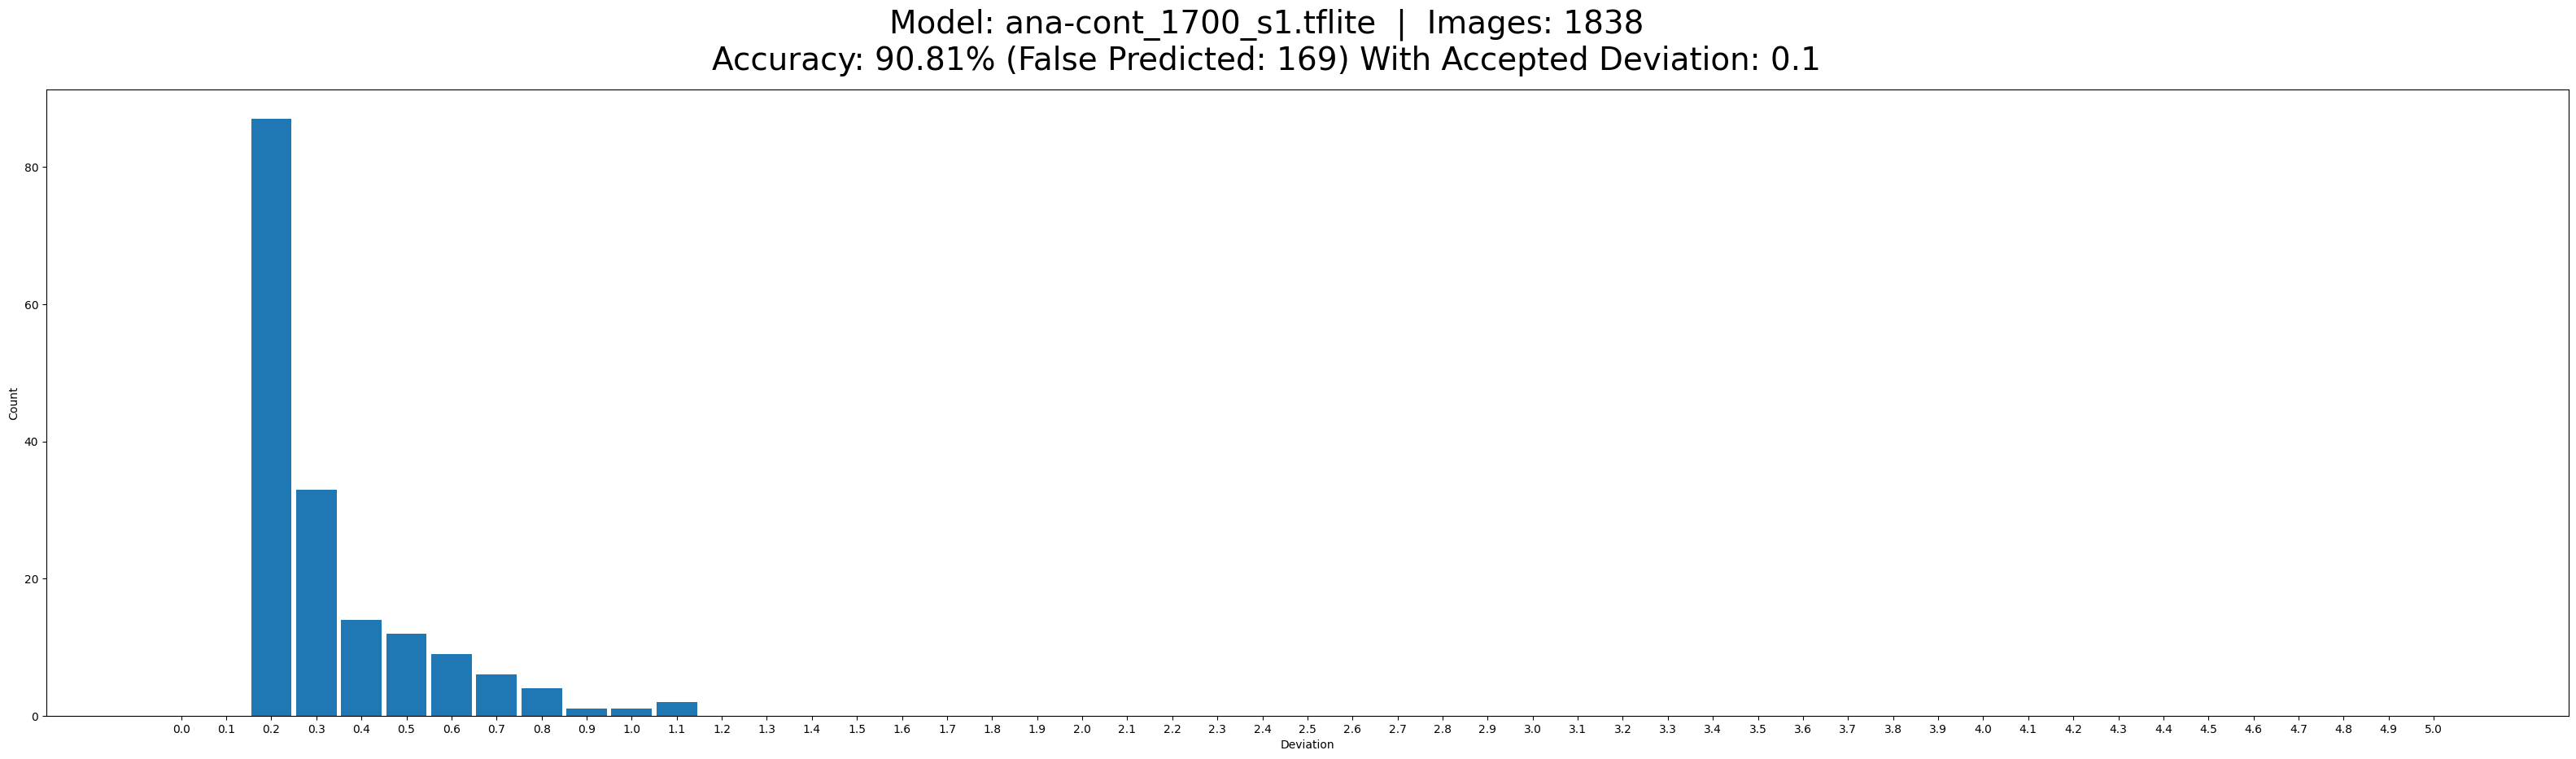

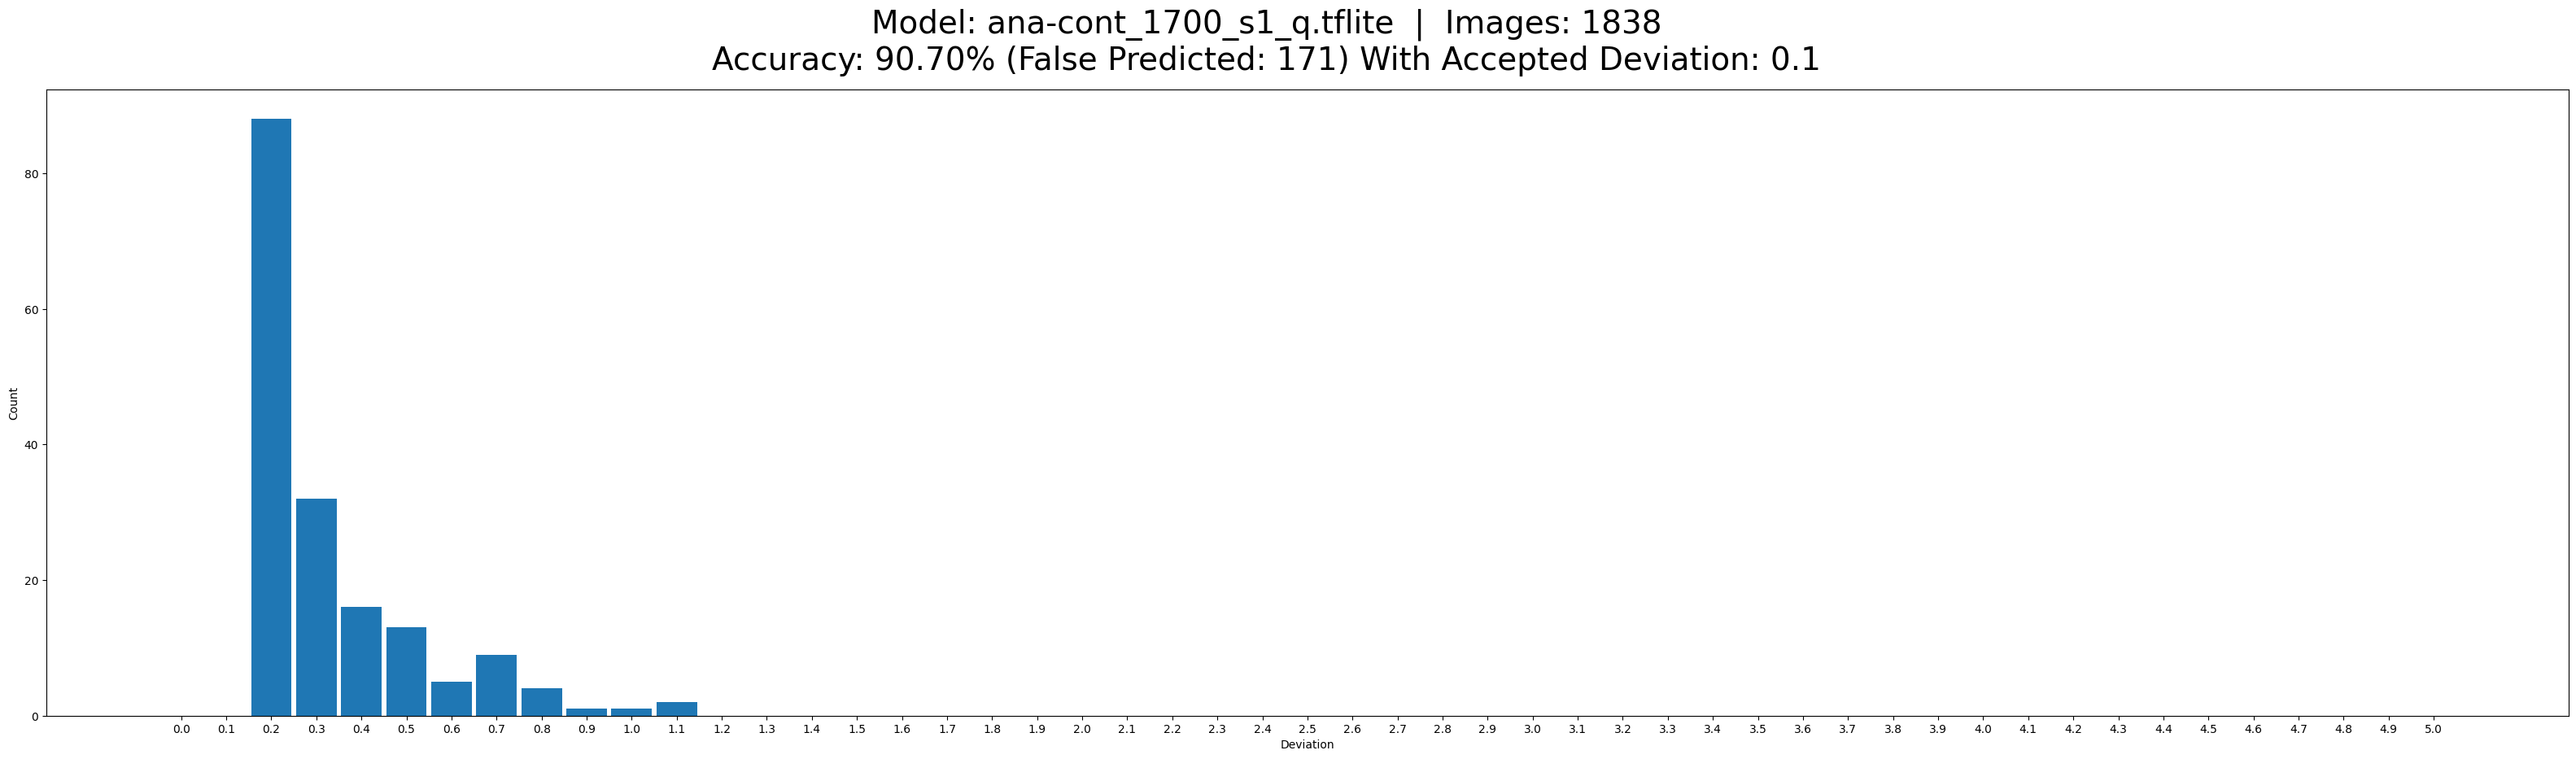

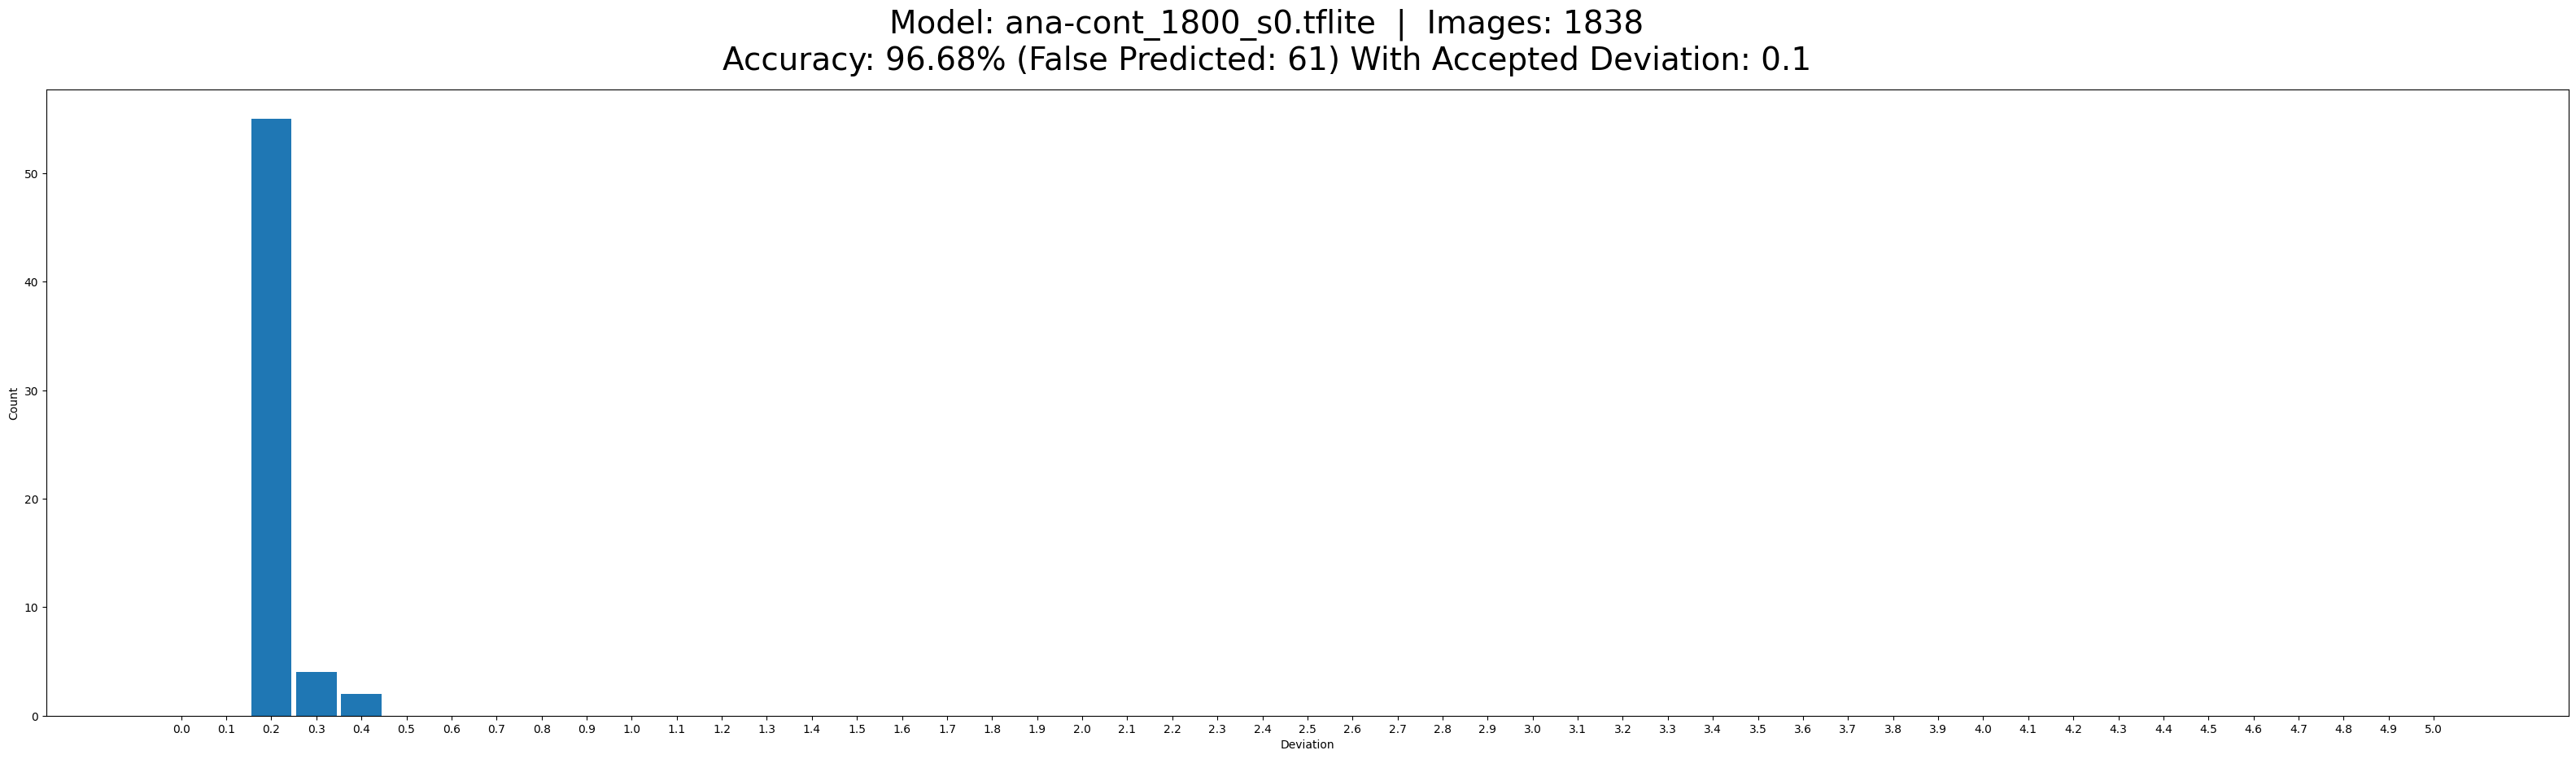

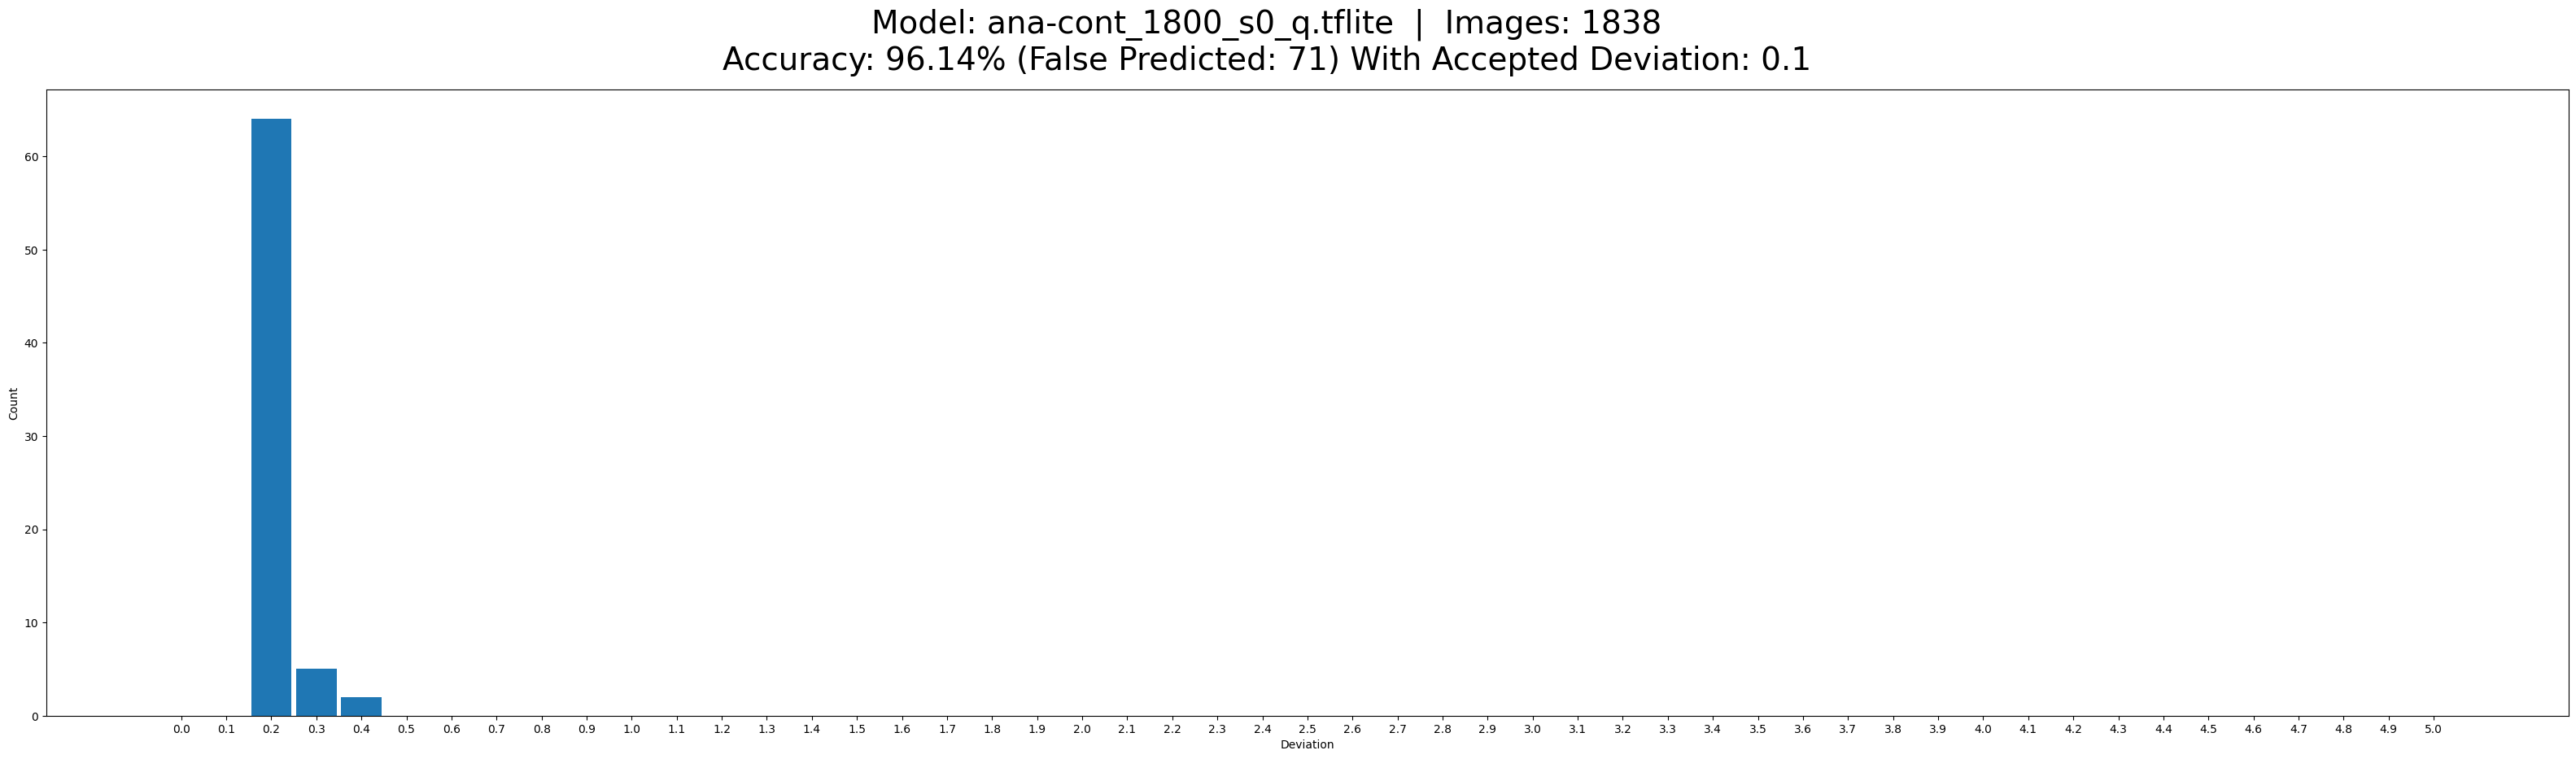

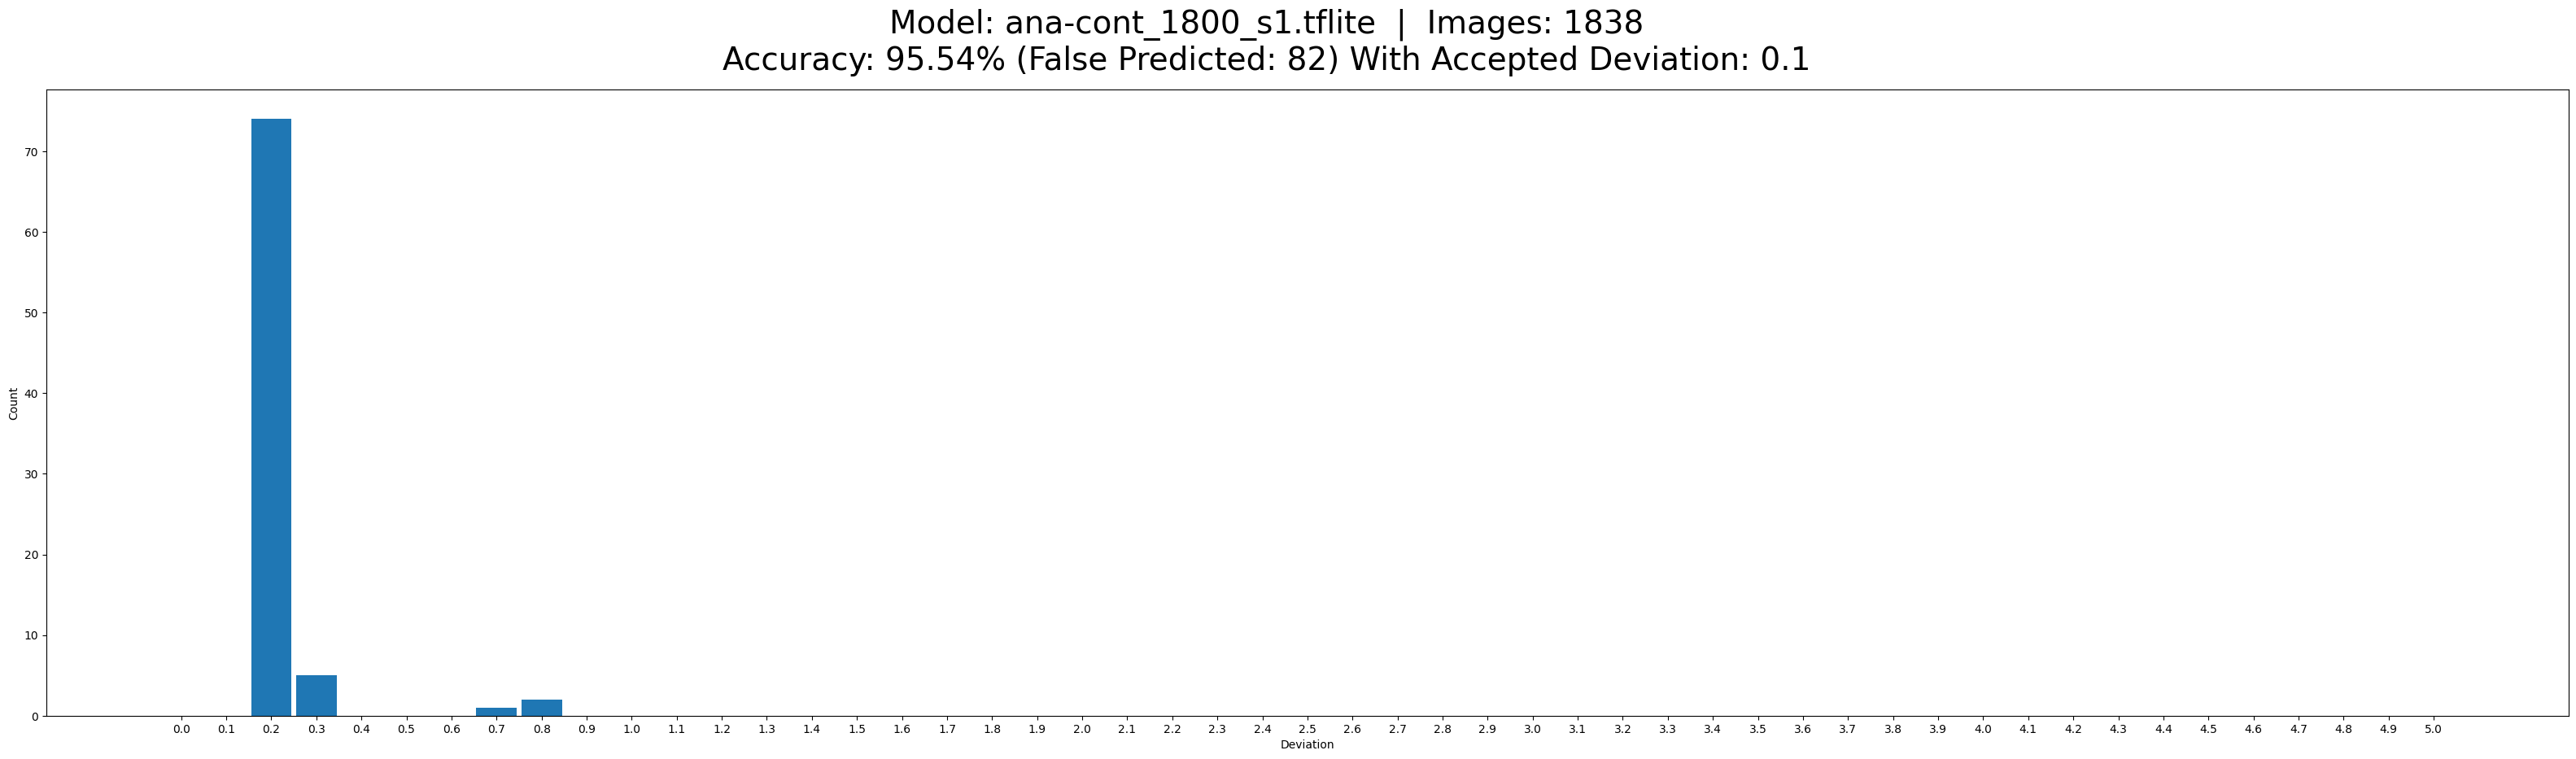

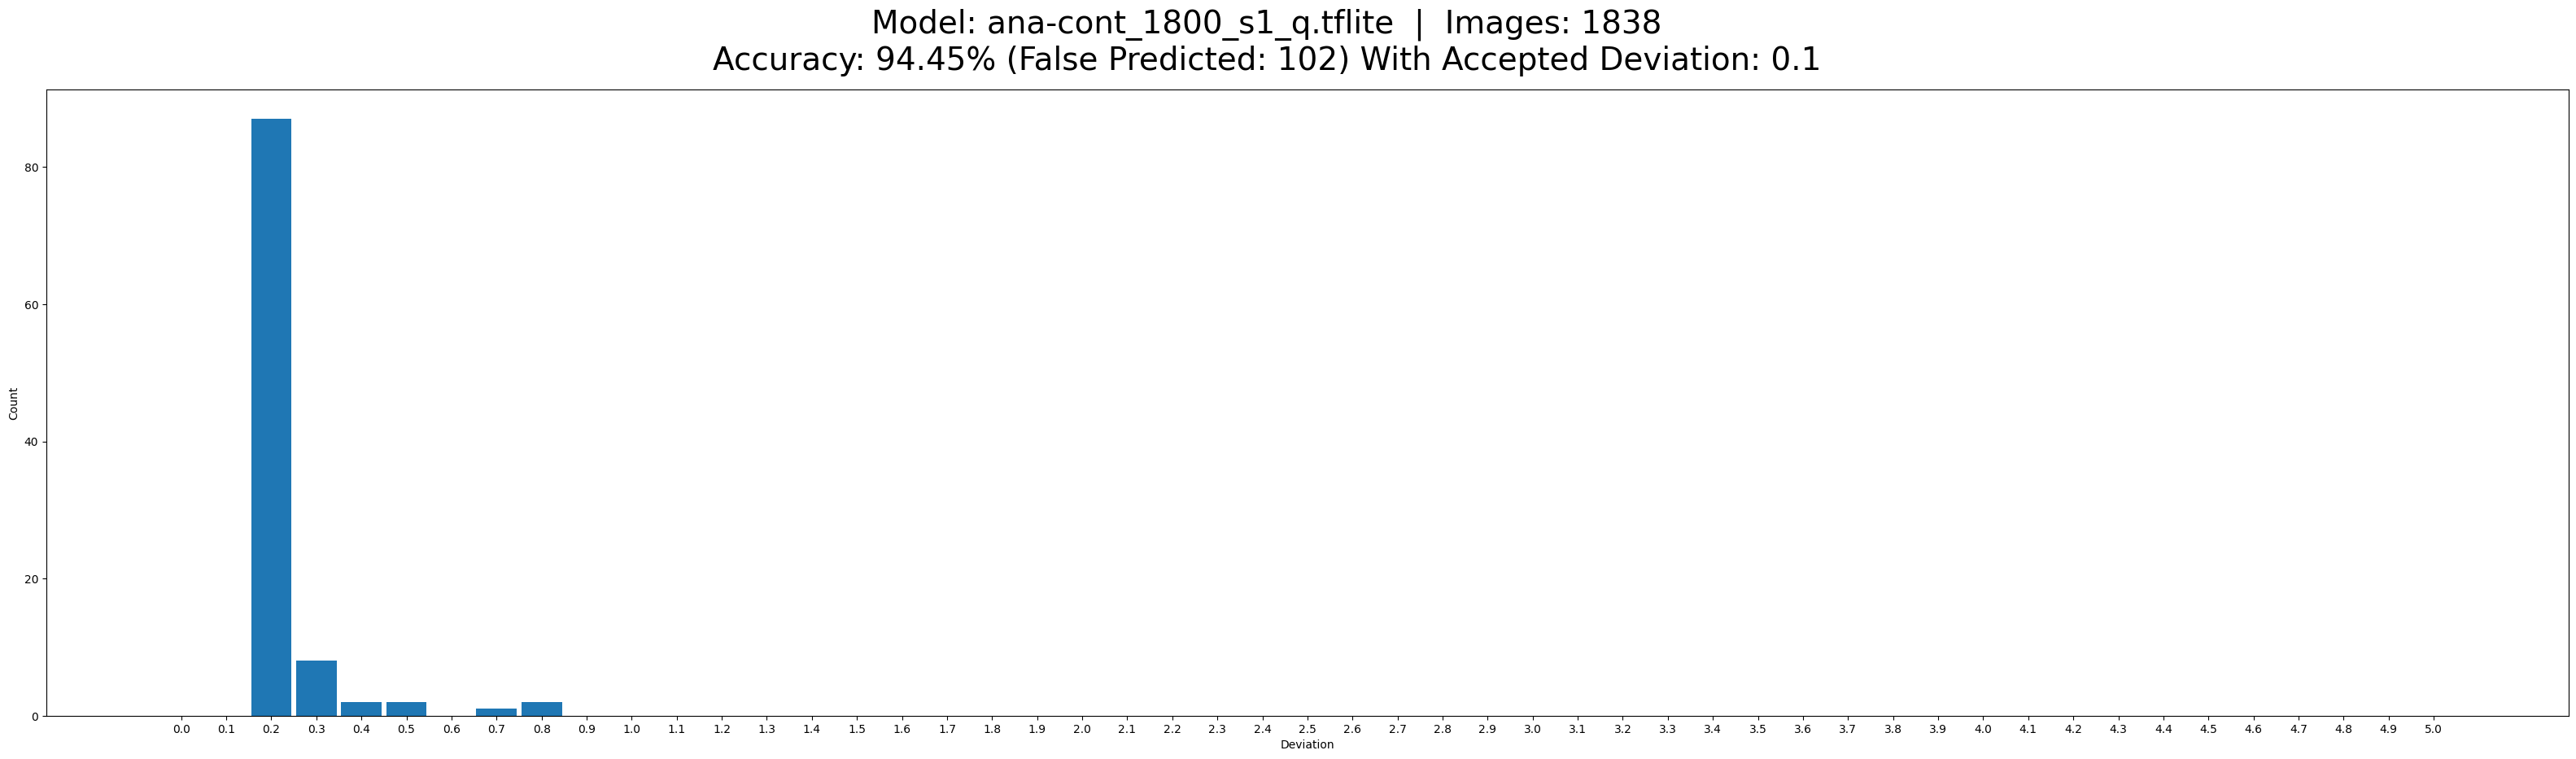

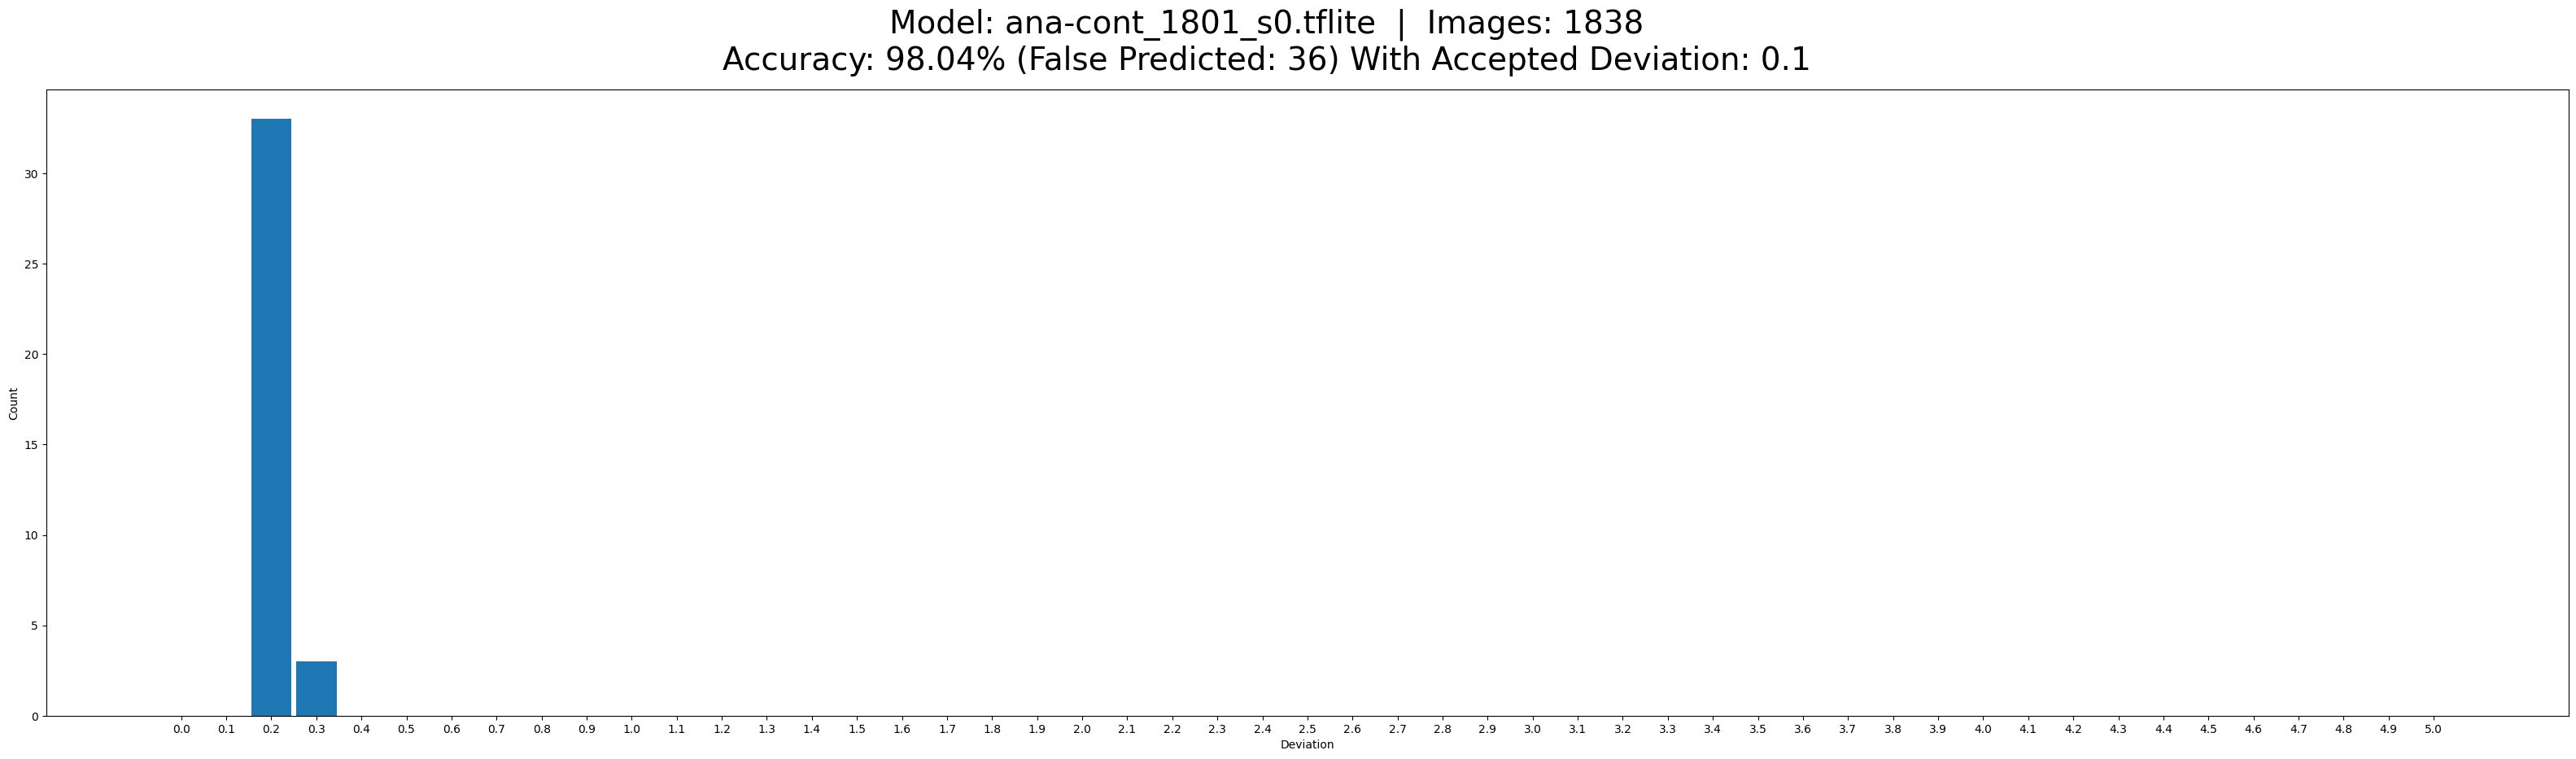

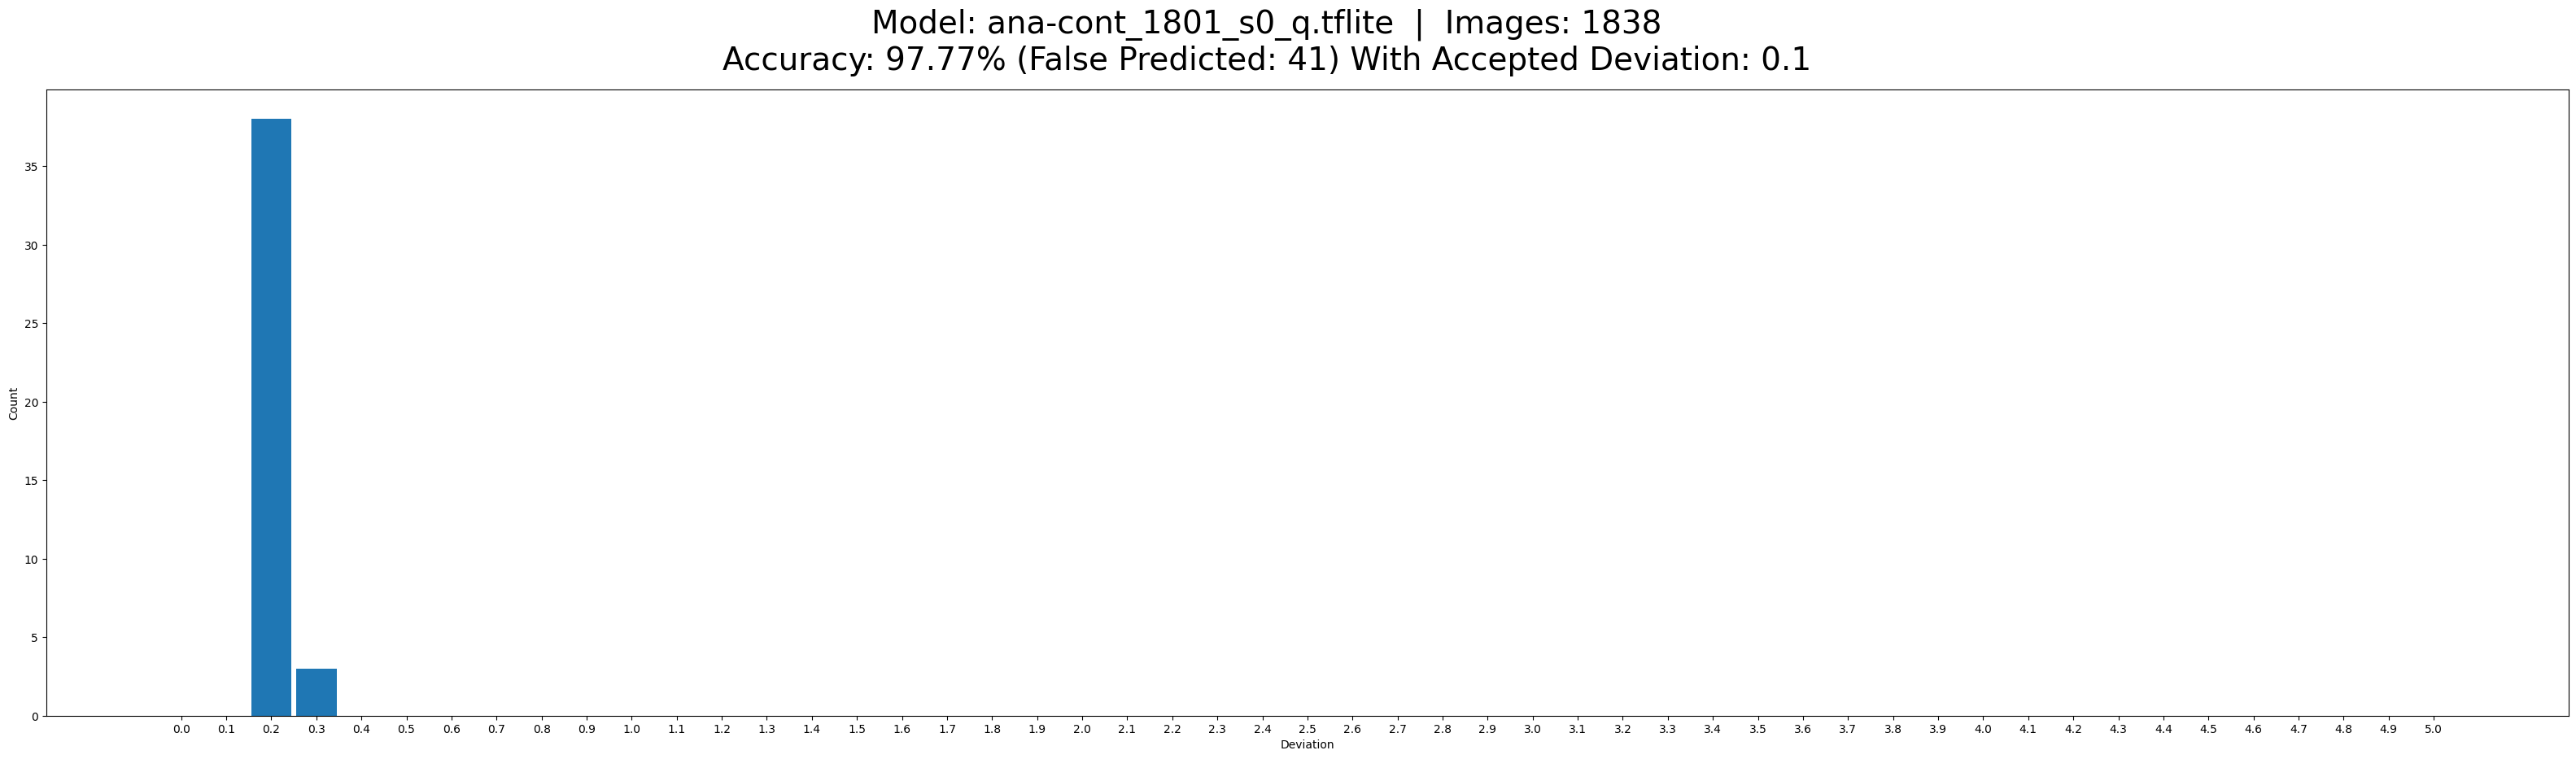

In [6]:
modelfiles = sorted(glob.glob('models/ana-class100/*.tflite')) + sorted(glob.glob('models/ana-cont/*.tflite')) + sorted(glob.glob('models_tmp/*.tflite'))

for modelfile in modelfiles:
    evaluate_model_accuracy(modelfile, x_data, y_data, f_data, title=modelfile, accepted_deviation=0.1, save_images=Save_Evaluation_Images)
    print(f" ")
    print(f" ")
    

### Evaluate Model Accuracy (Accepted Deviation: 0.0)

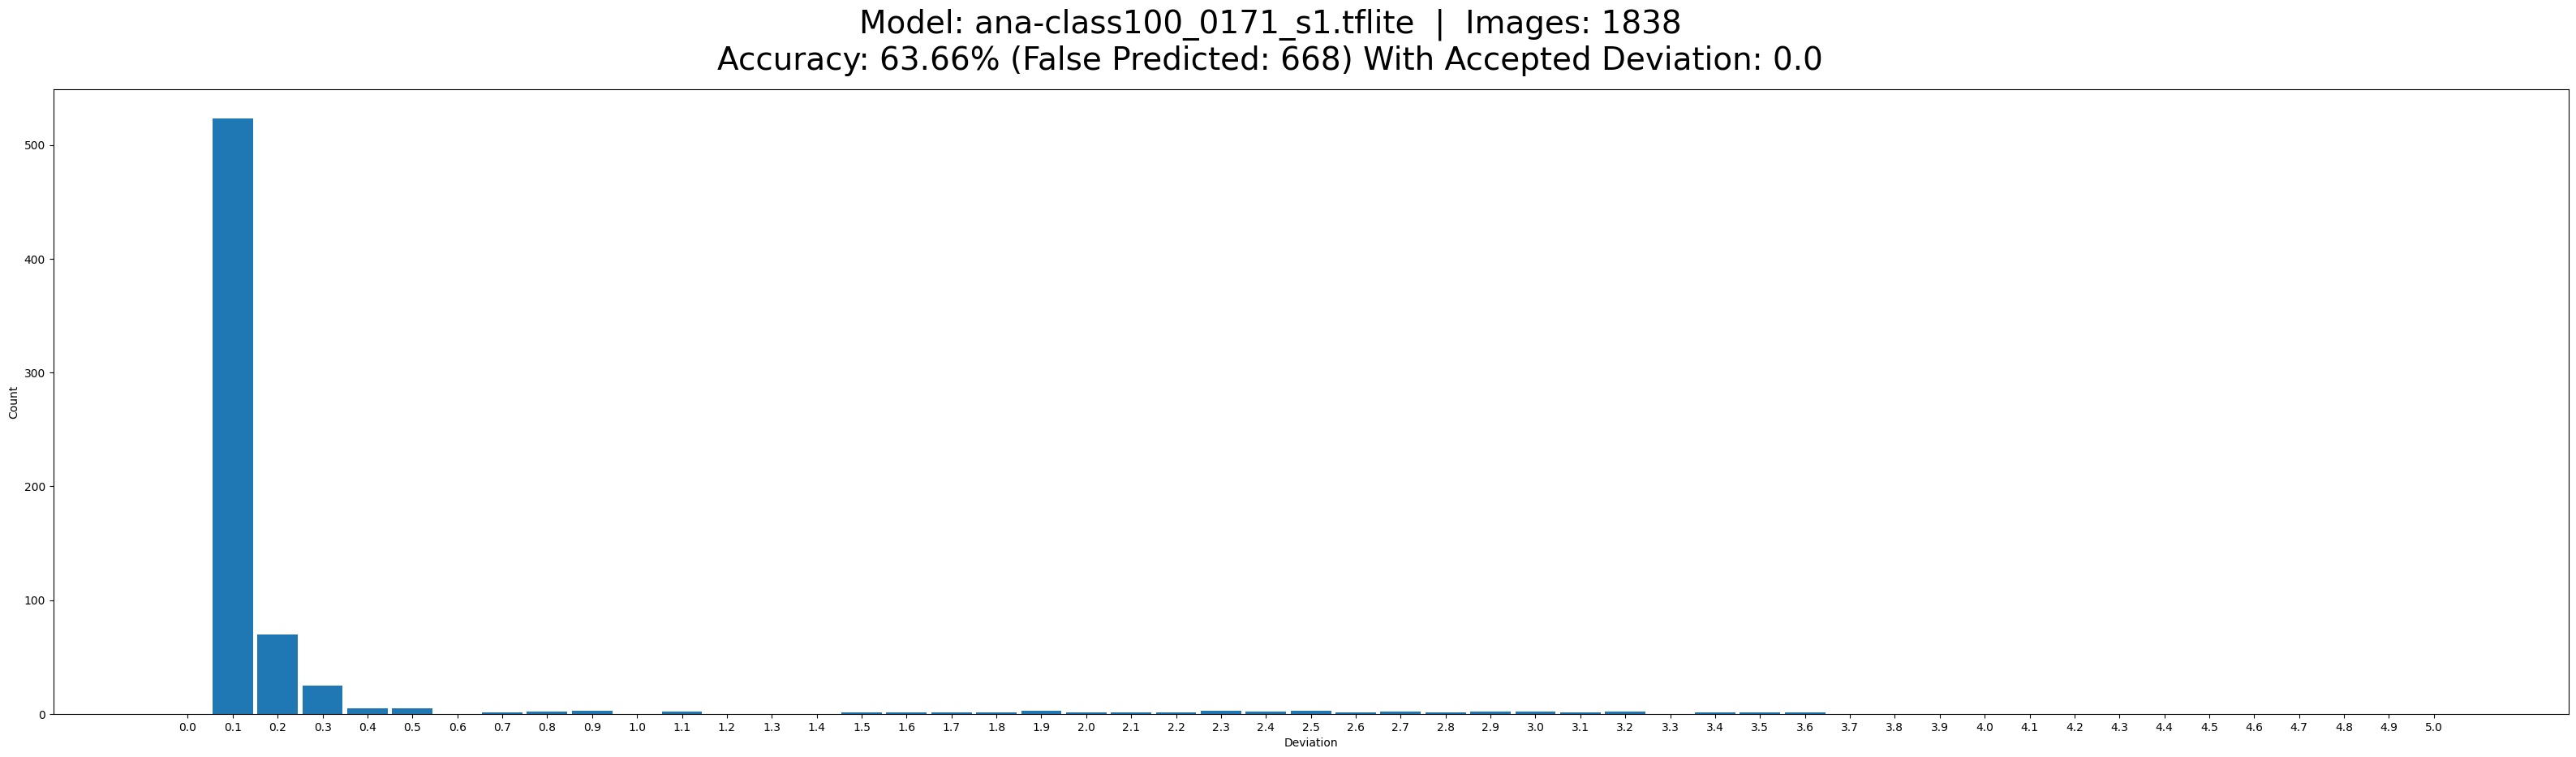

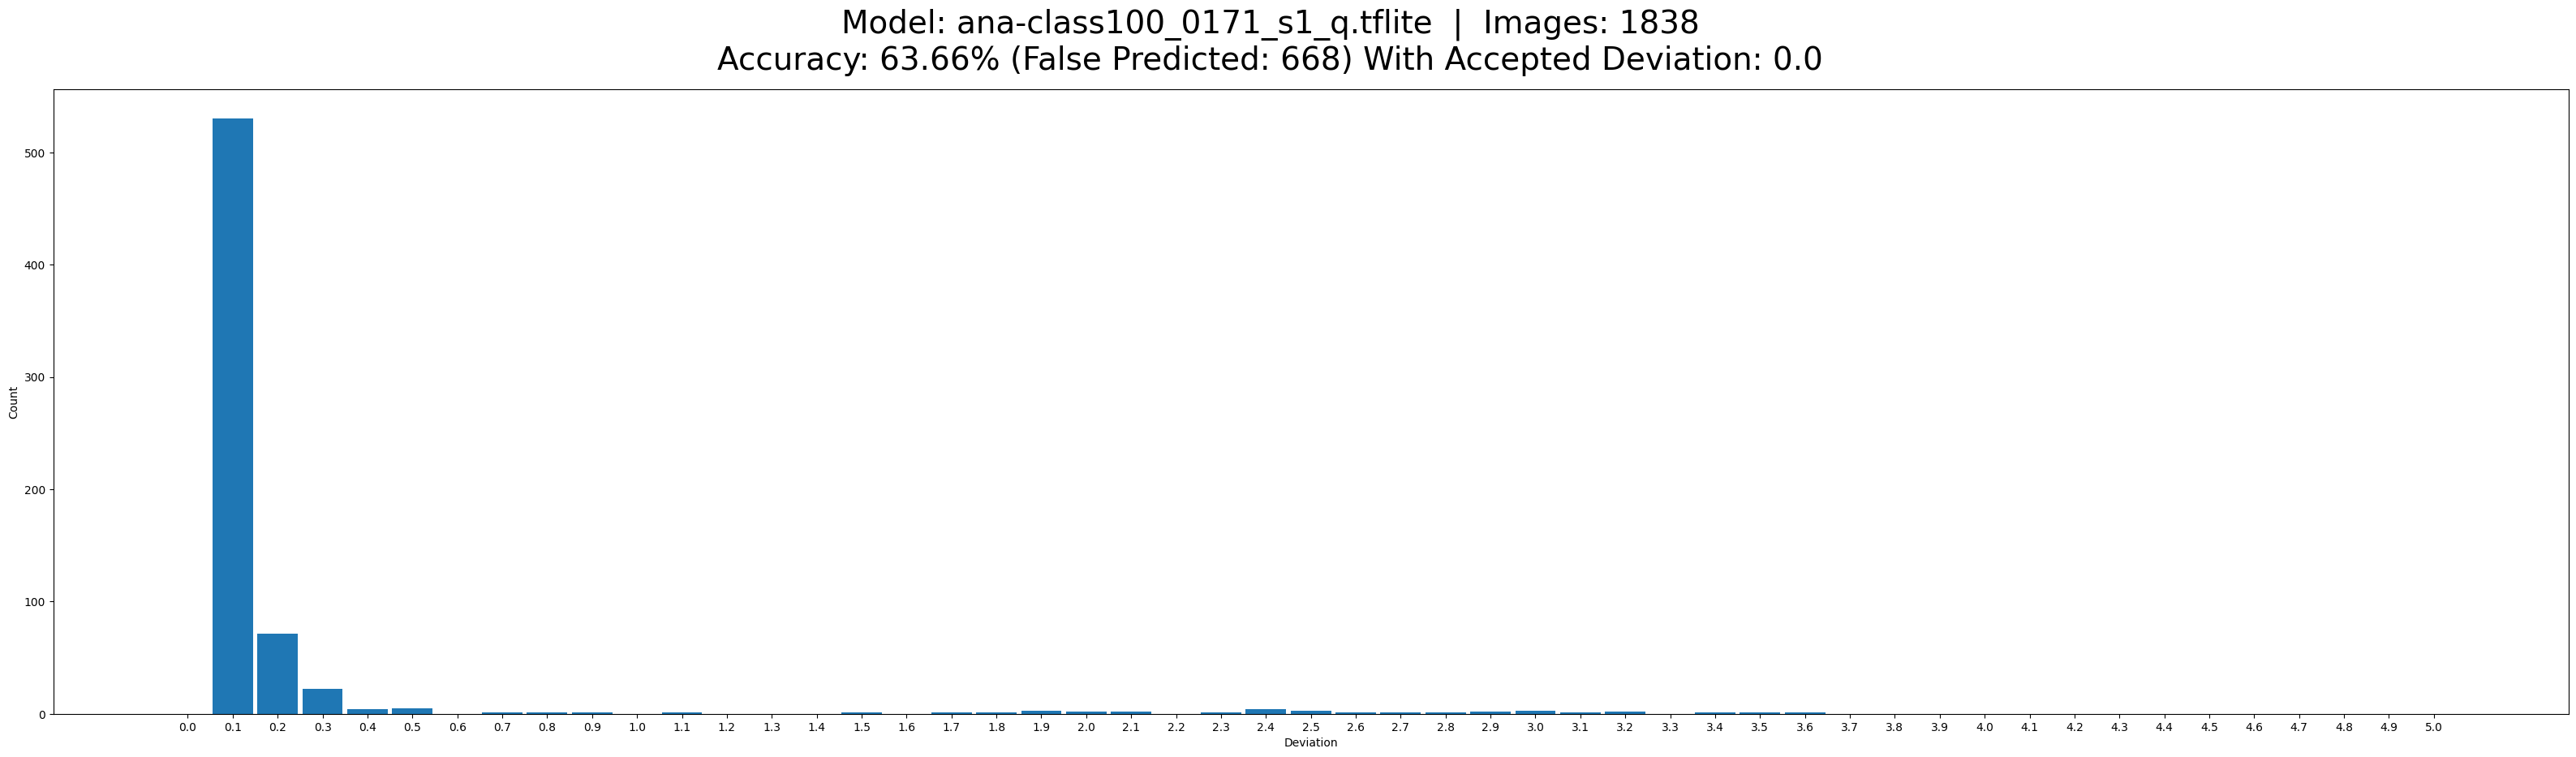

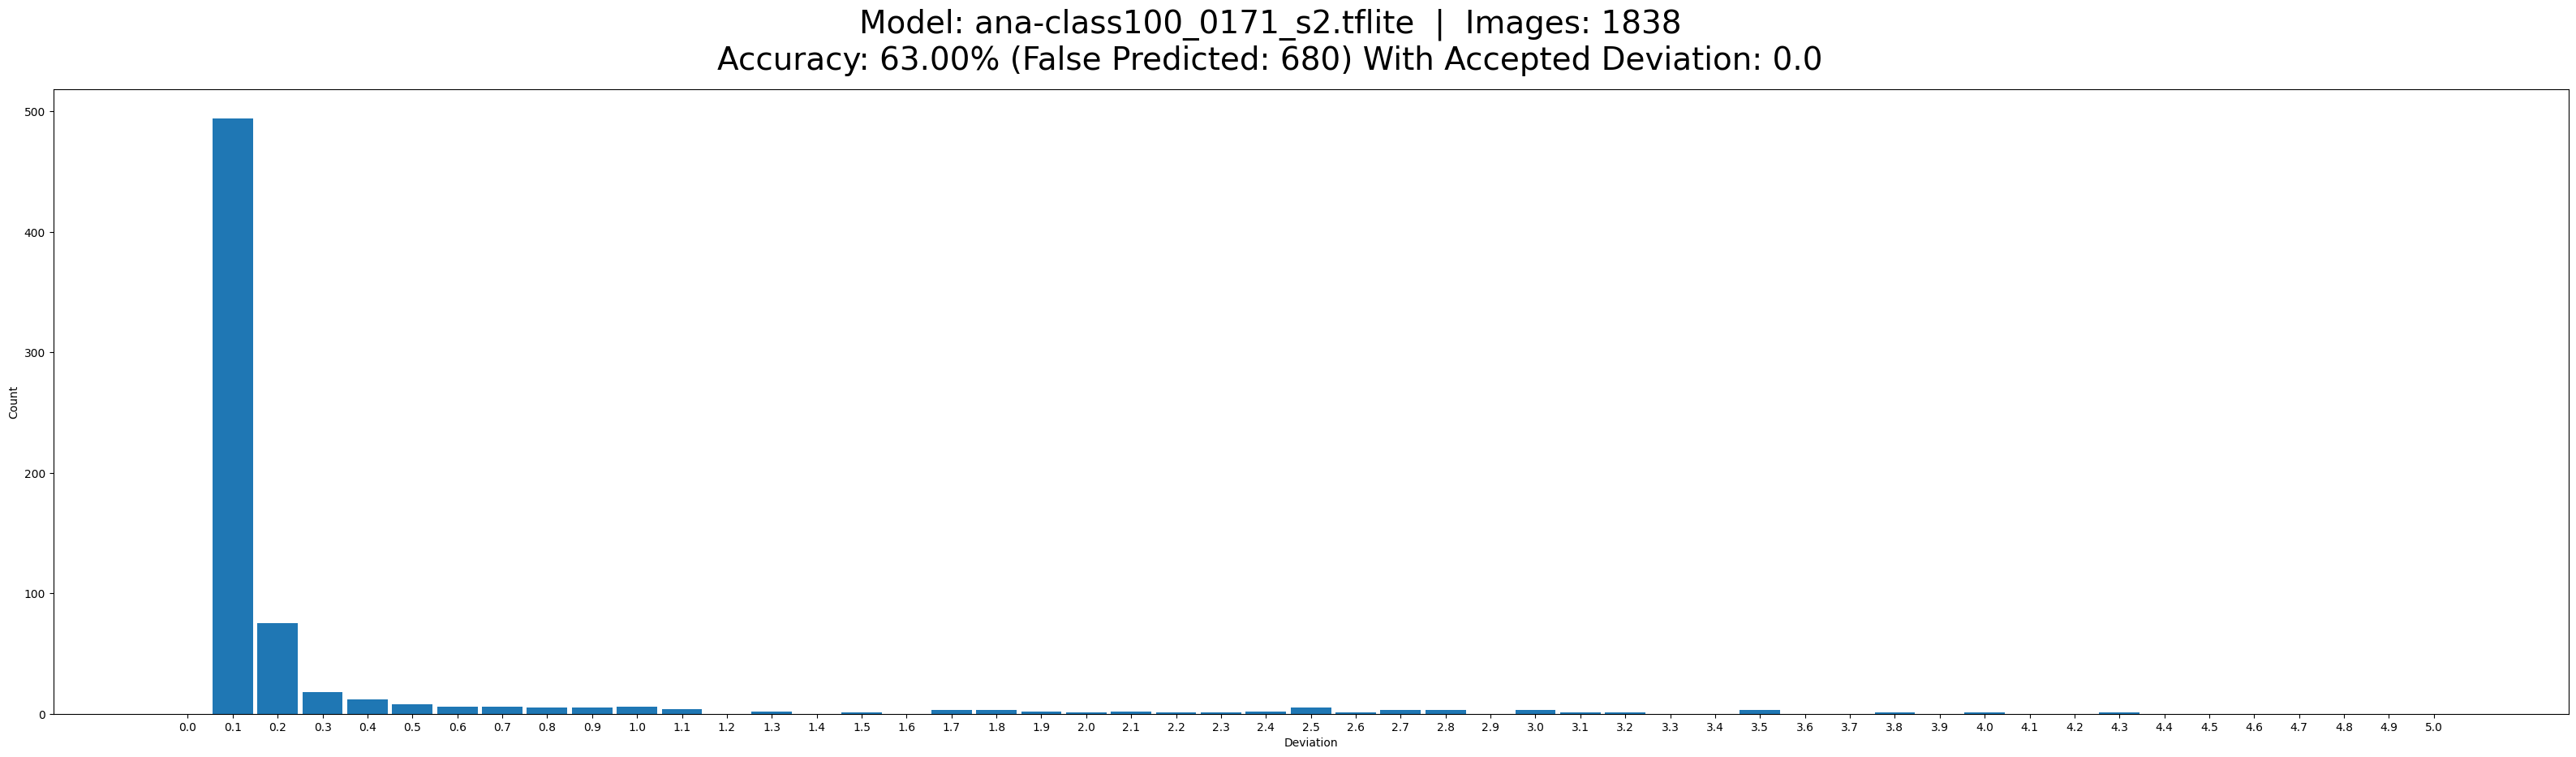

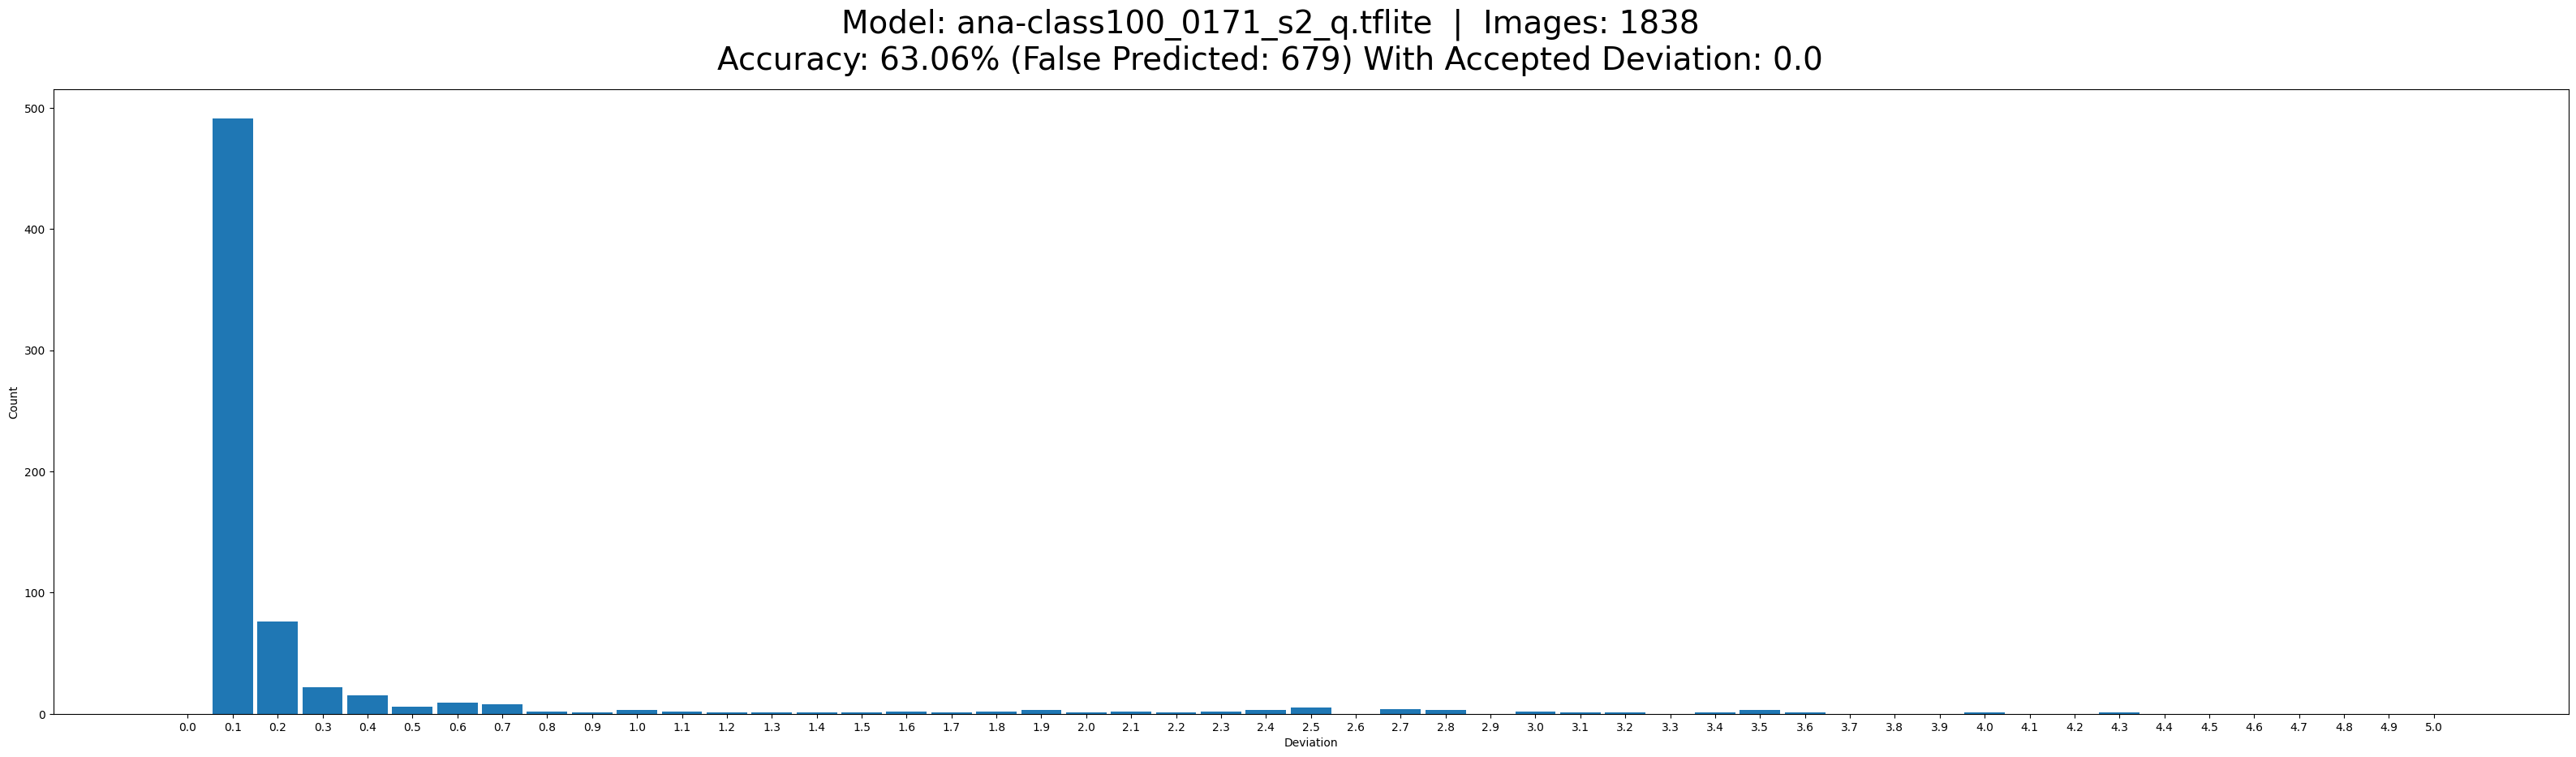

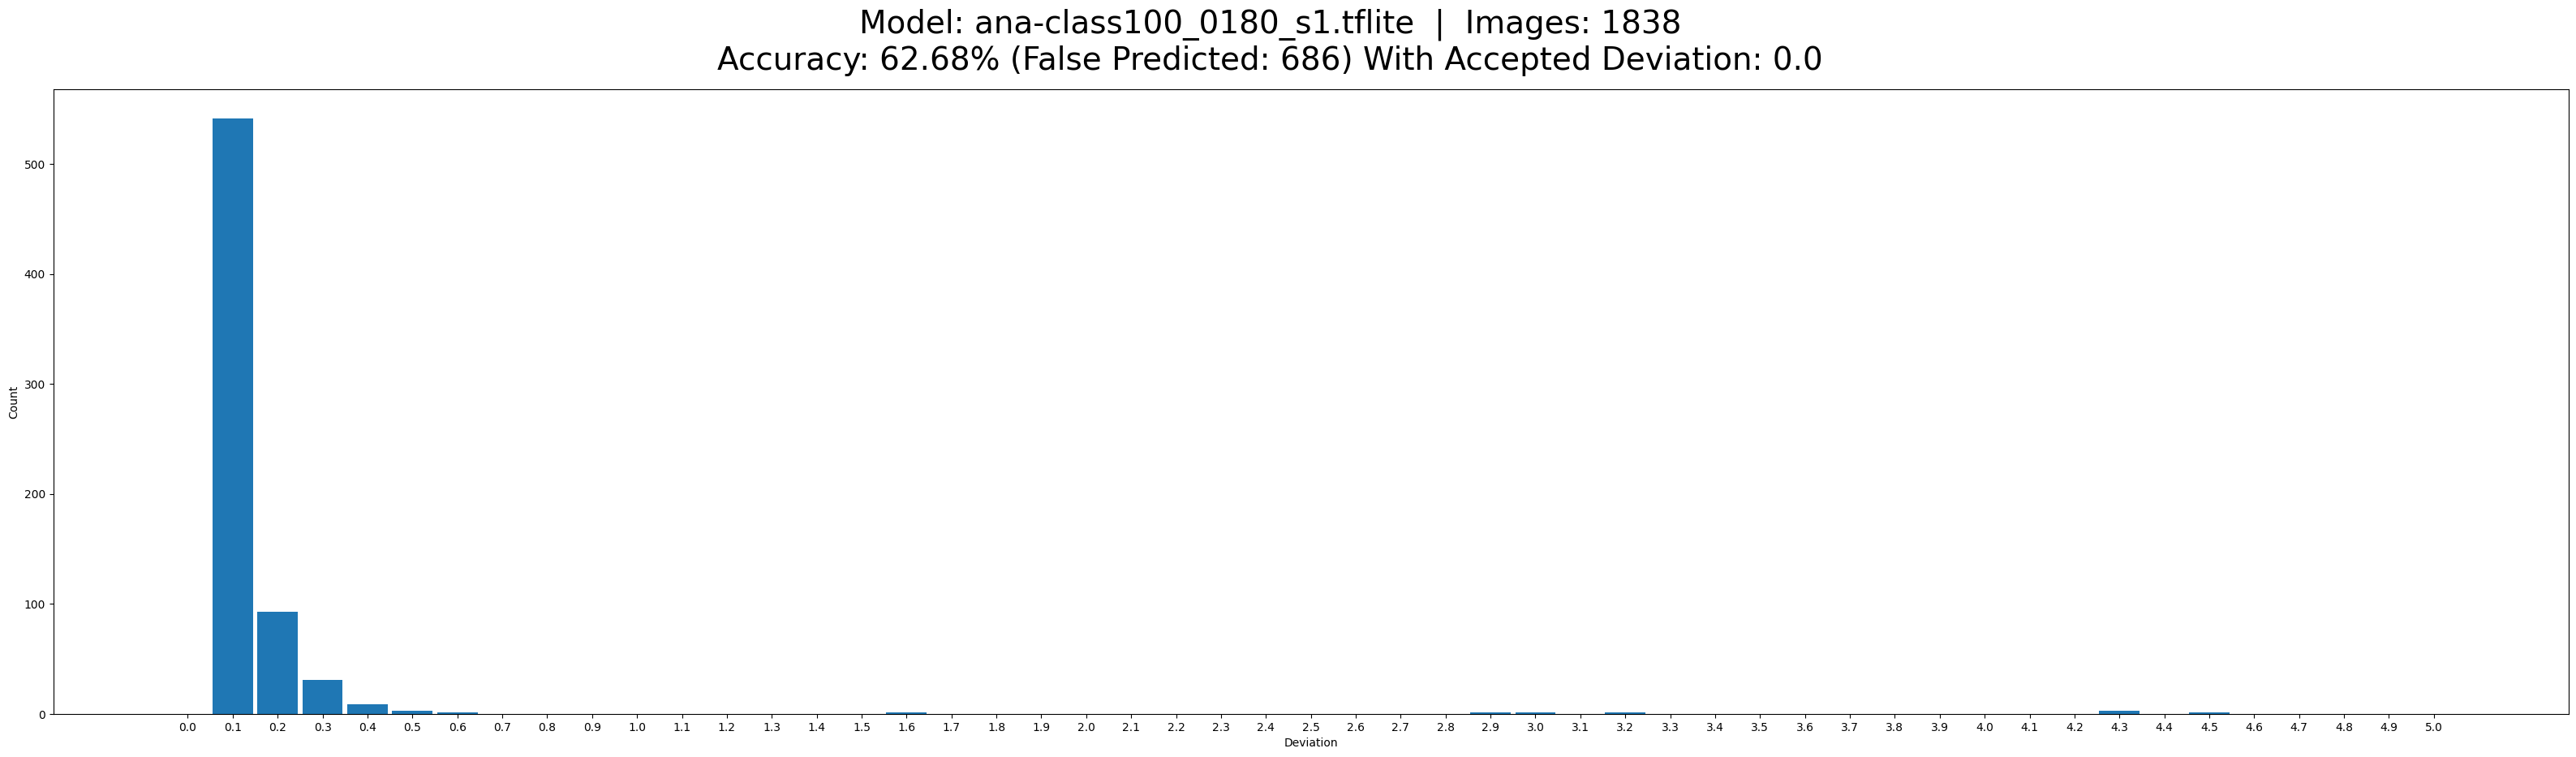

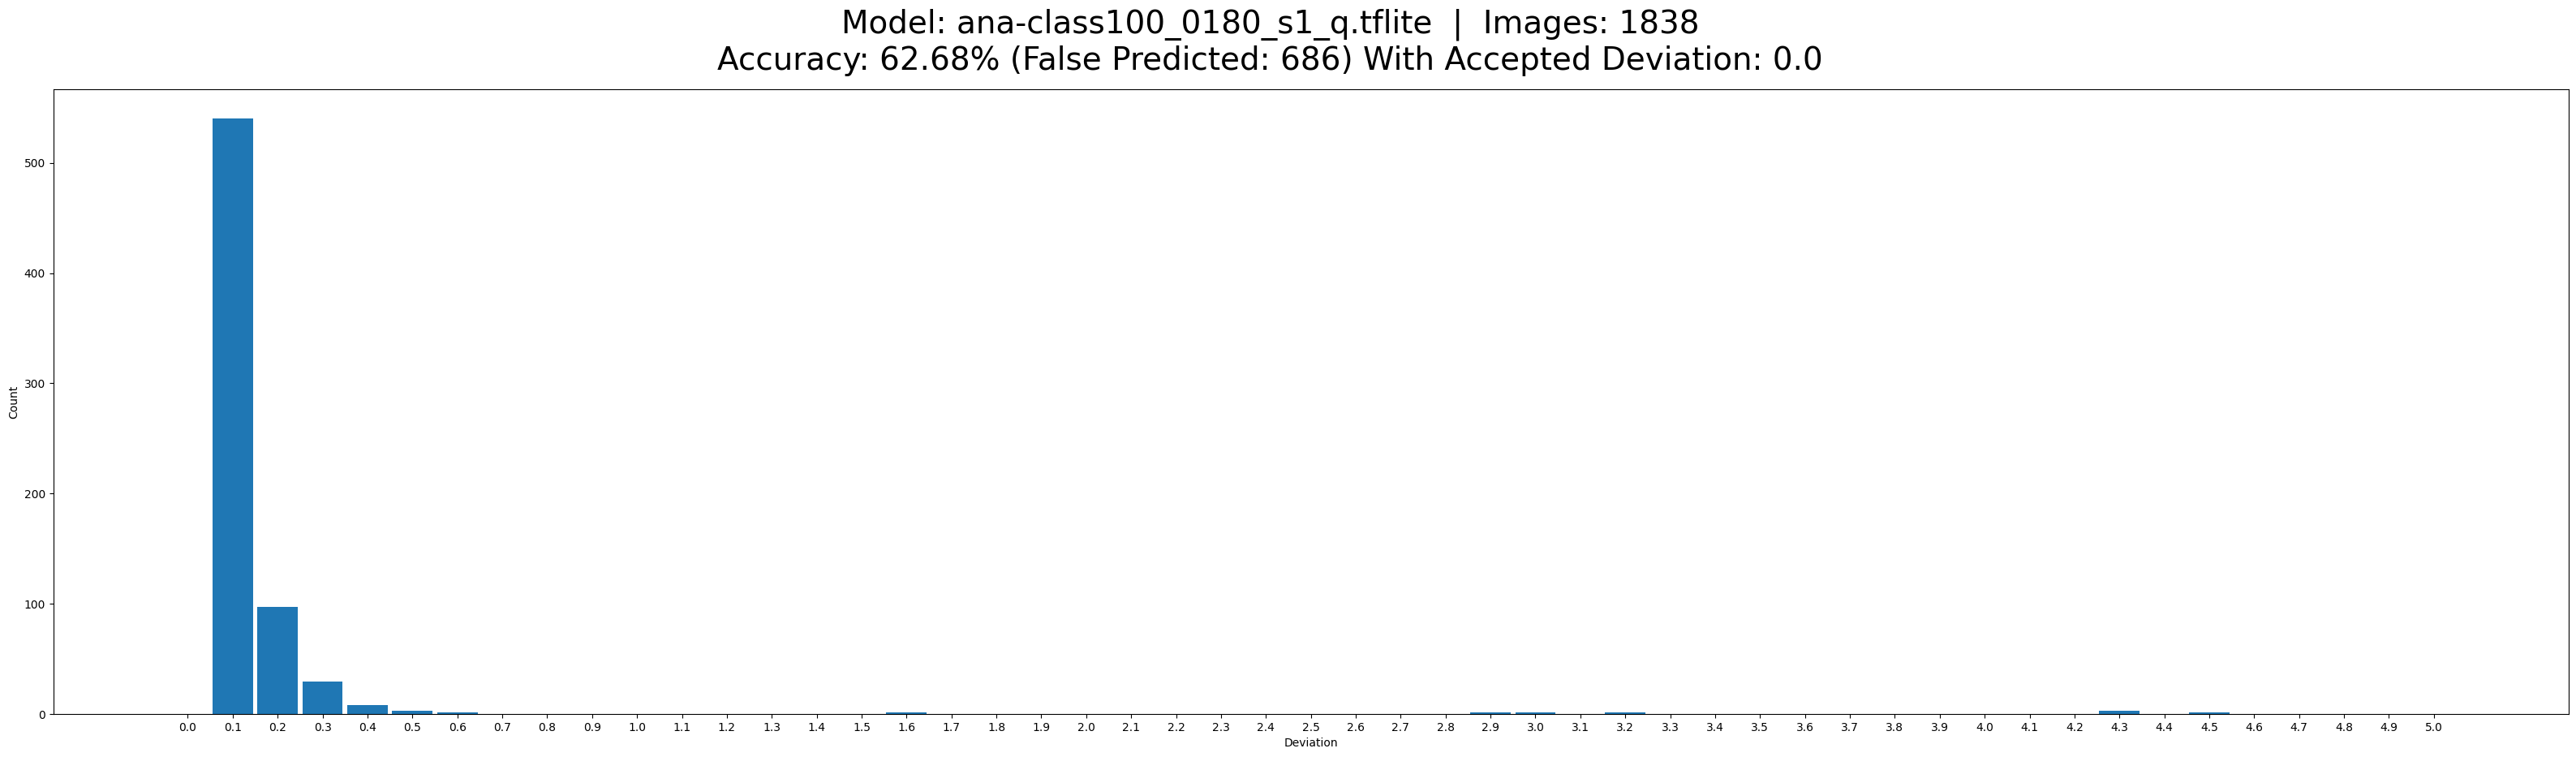

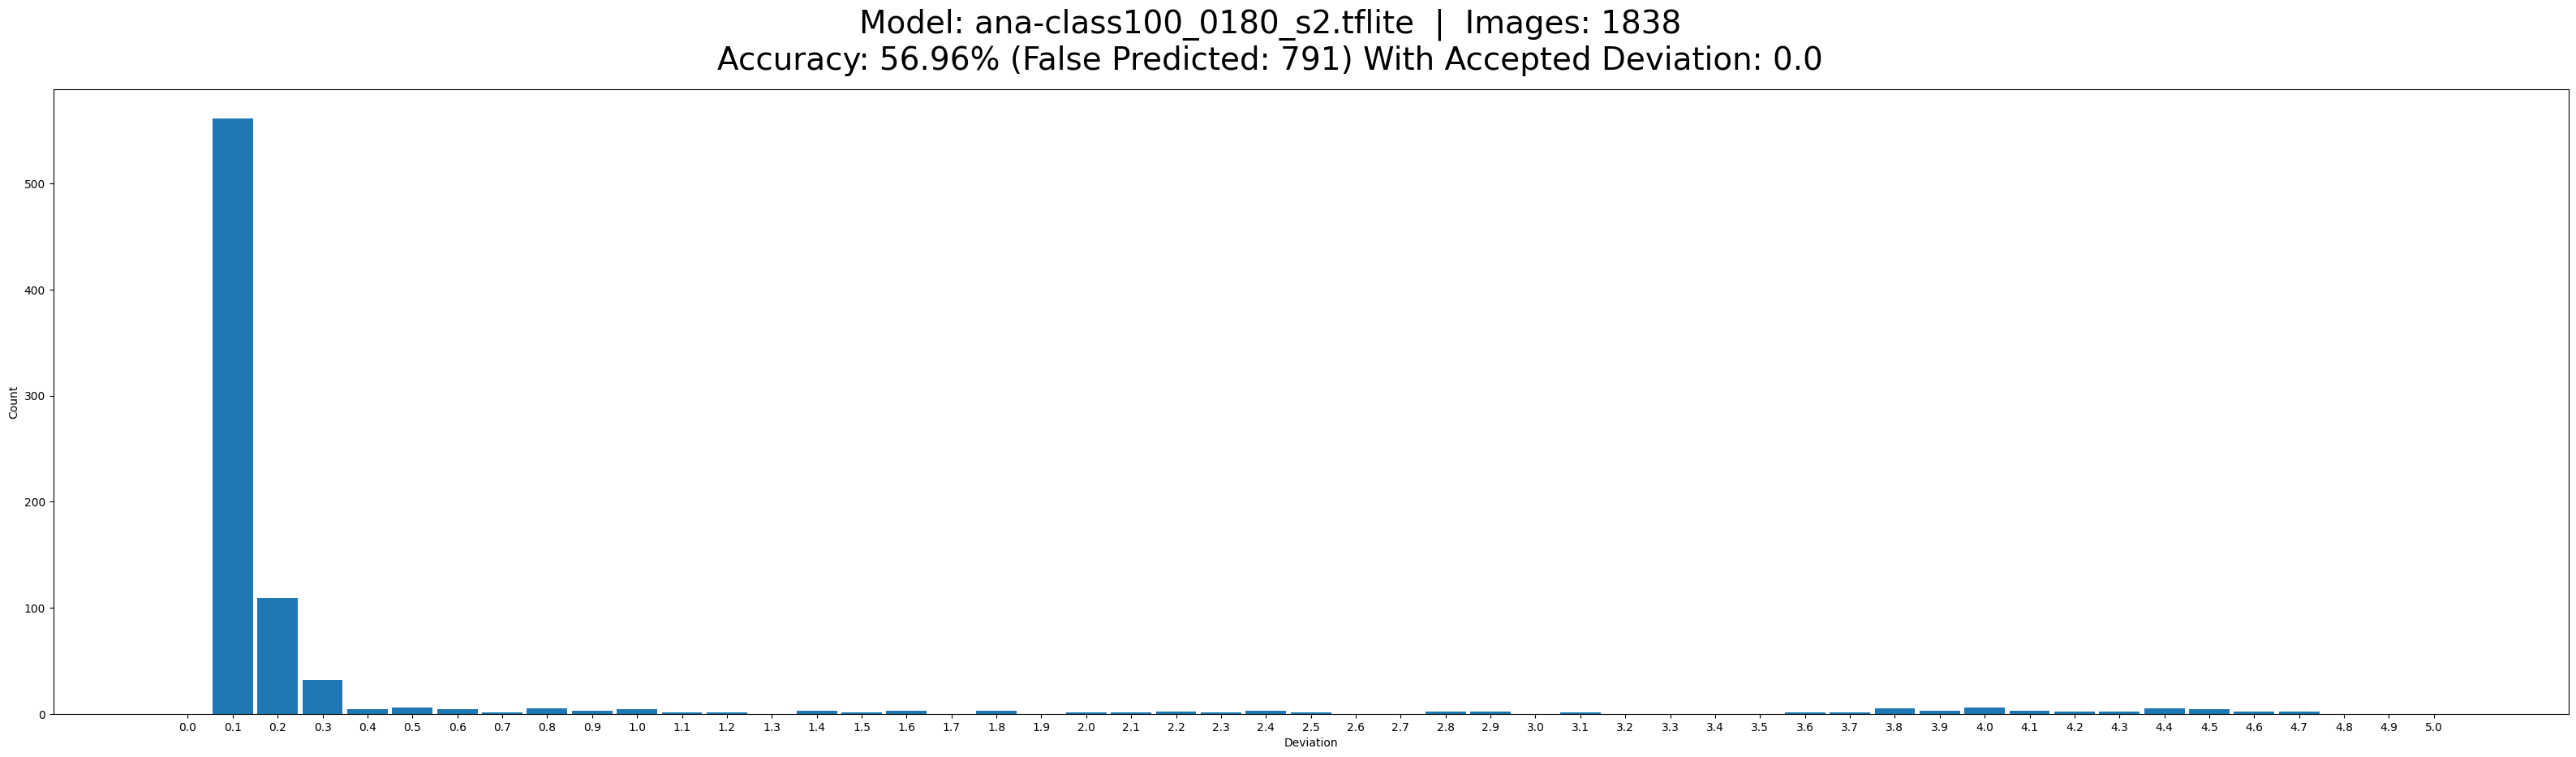

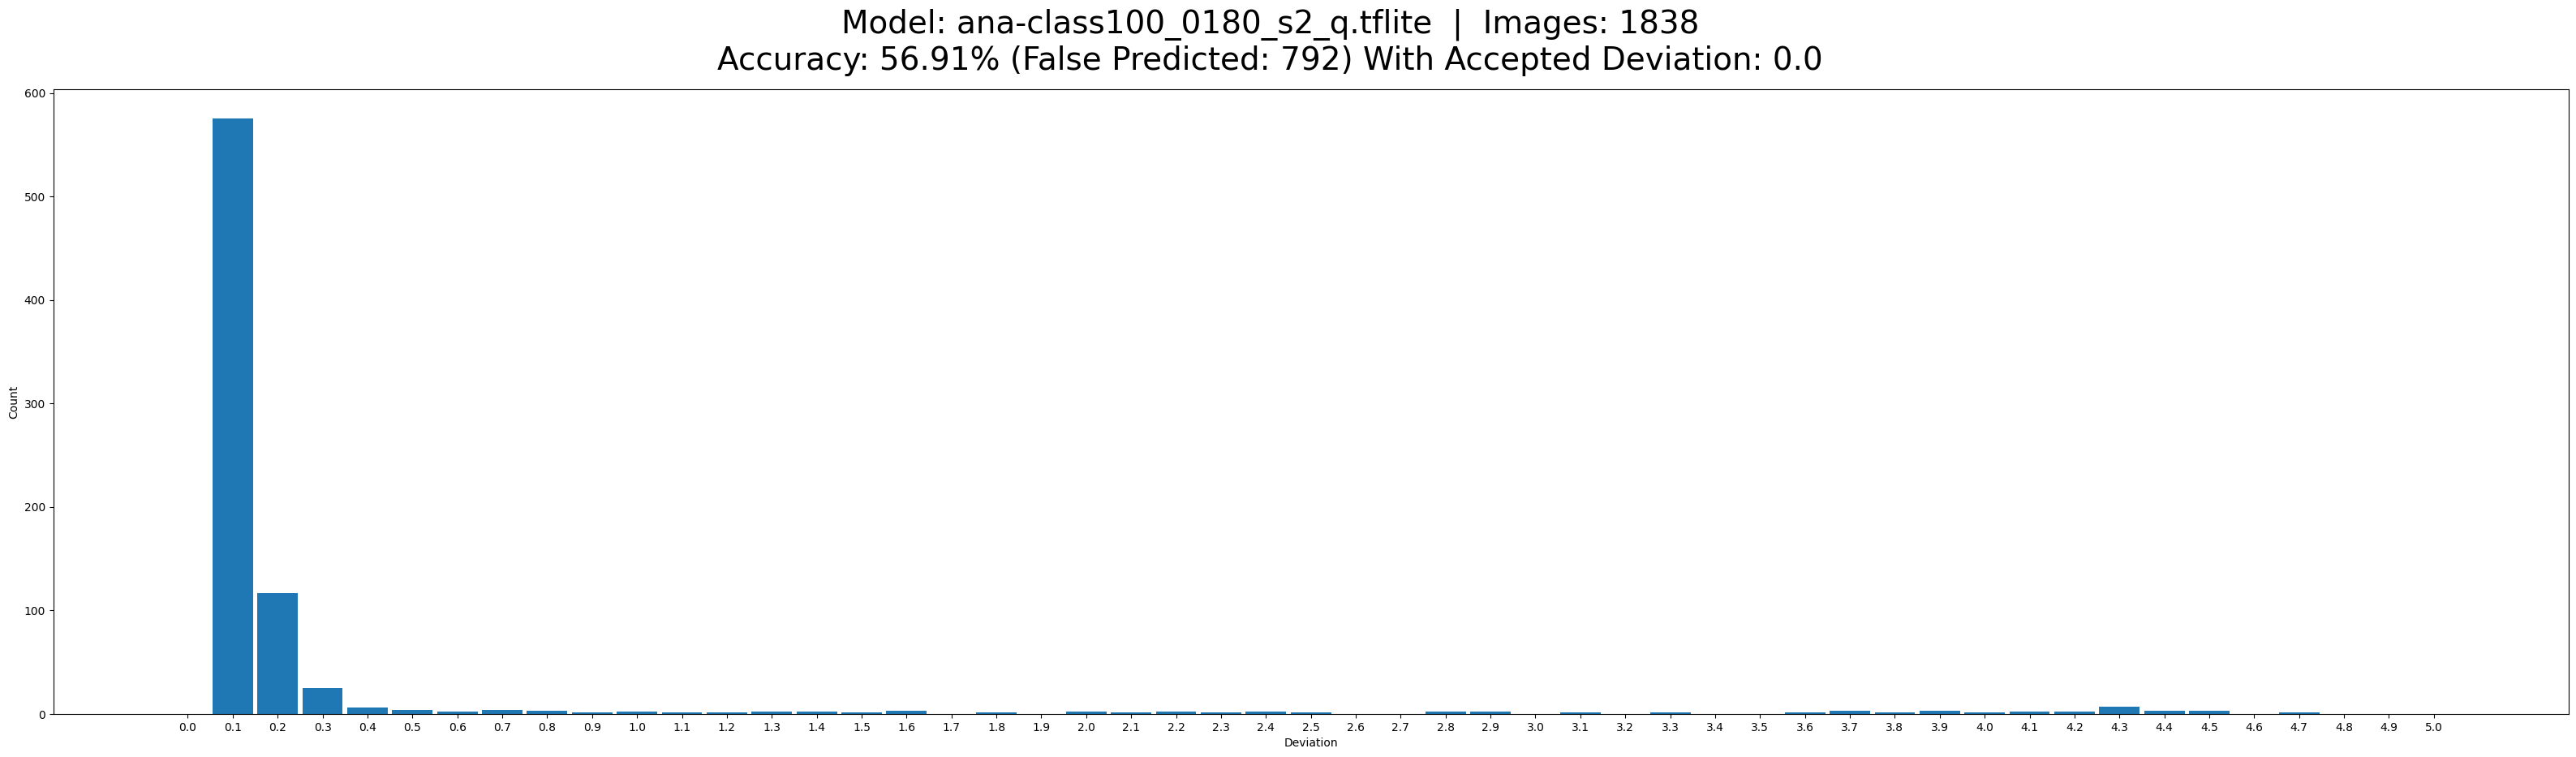

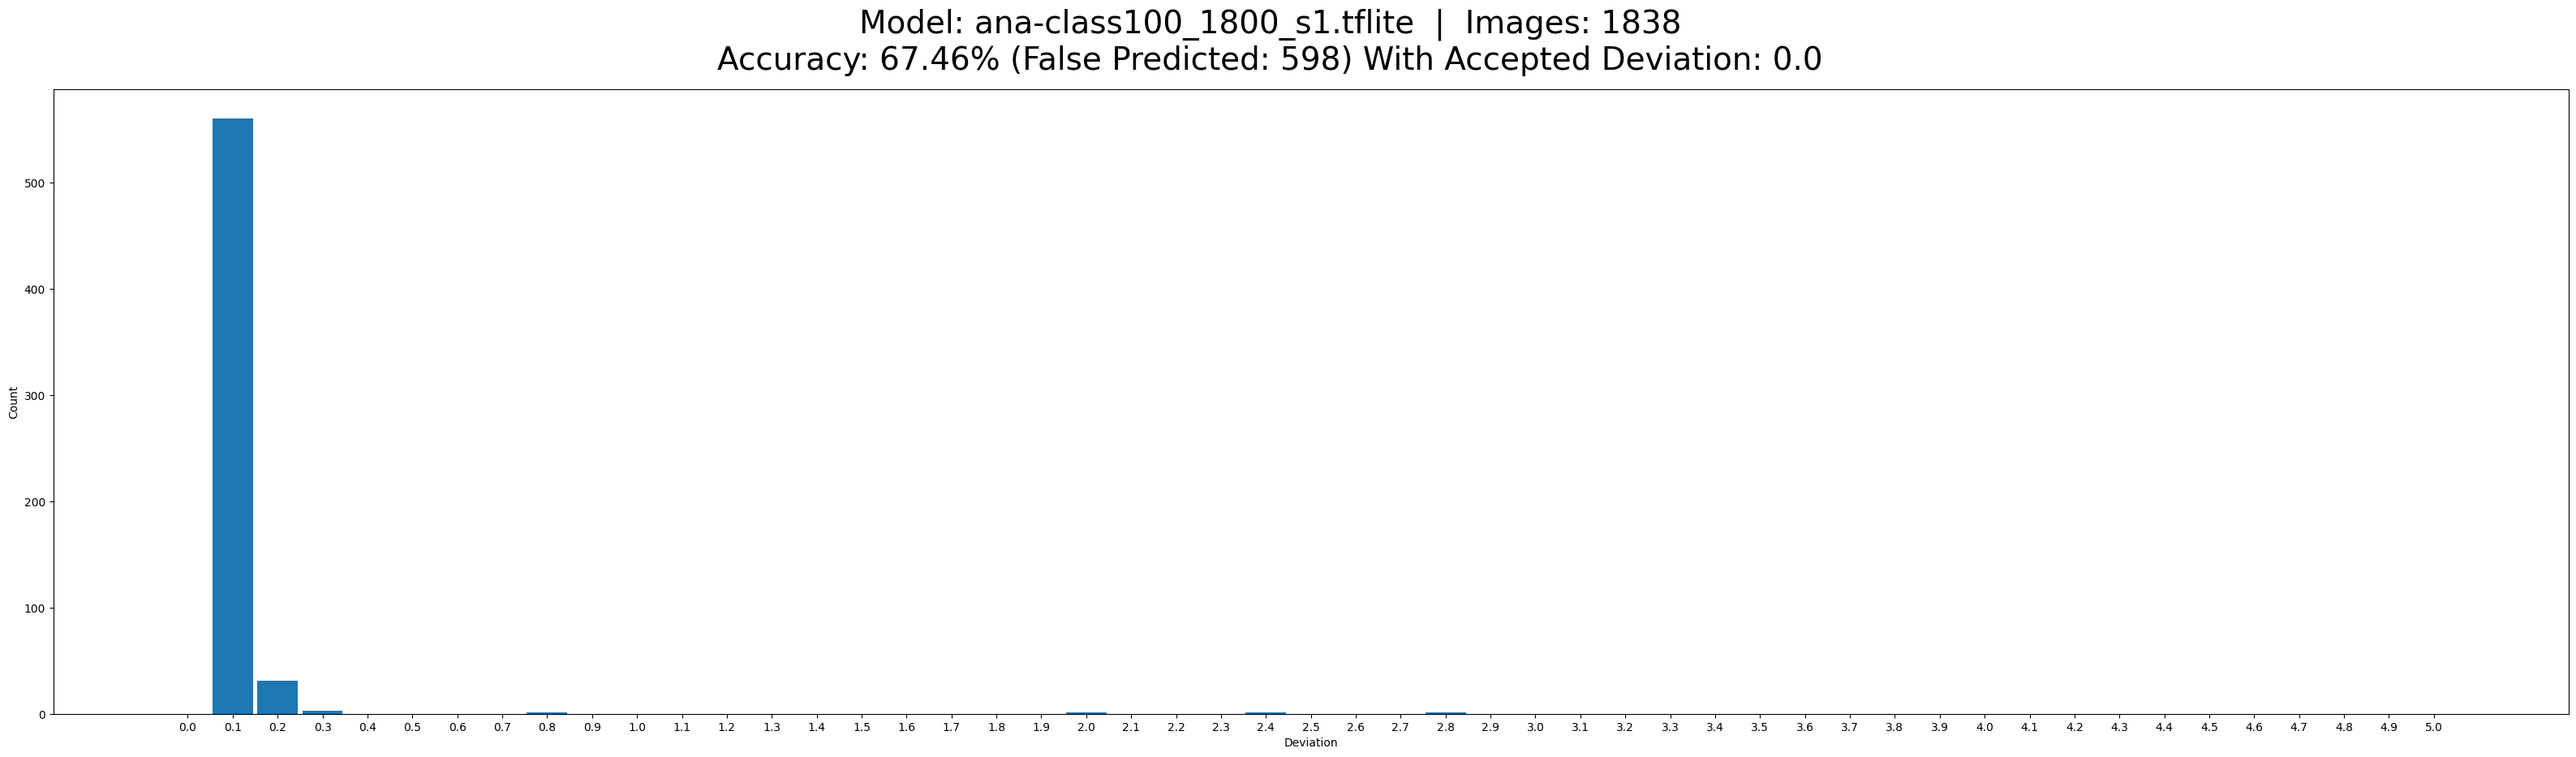

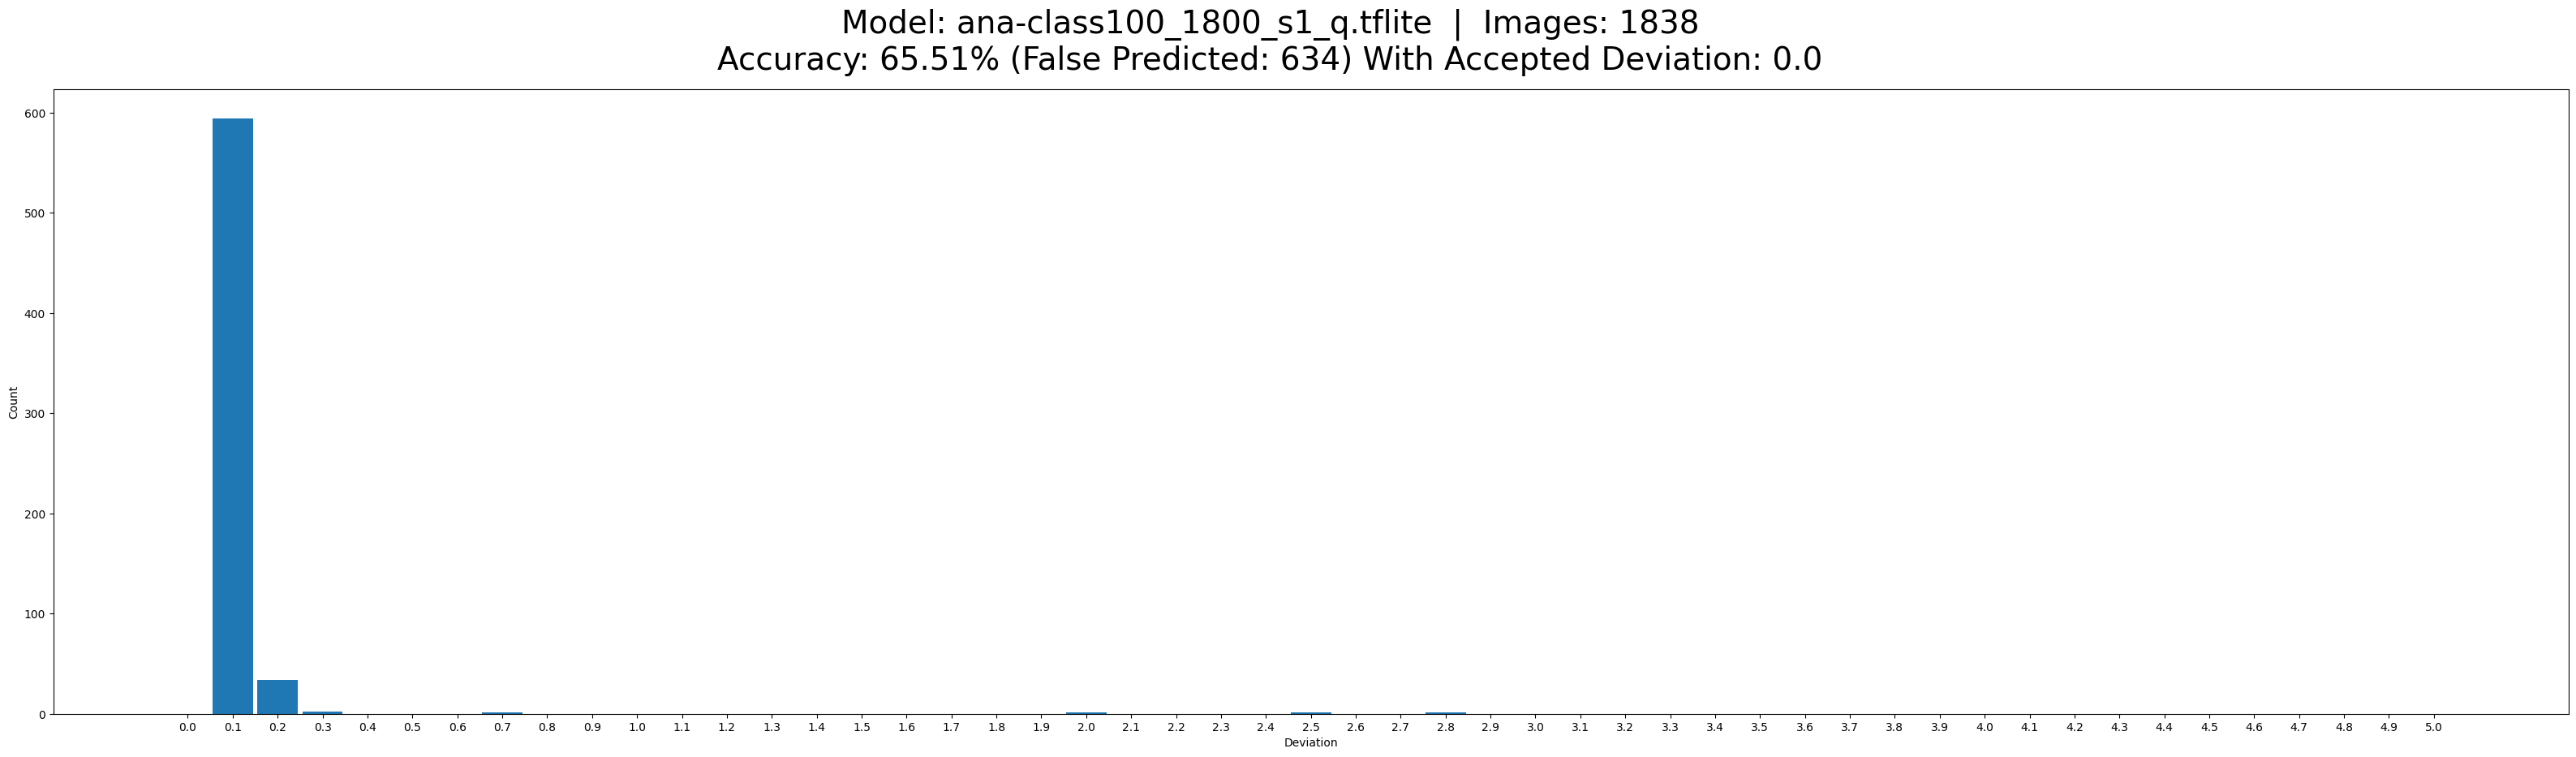

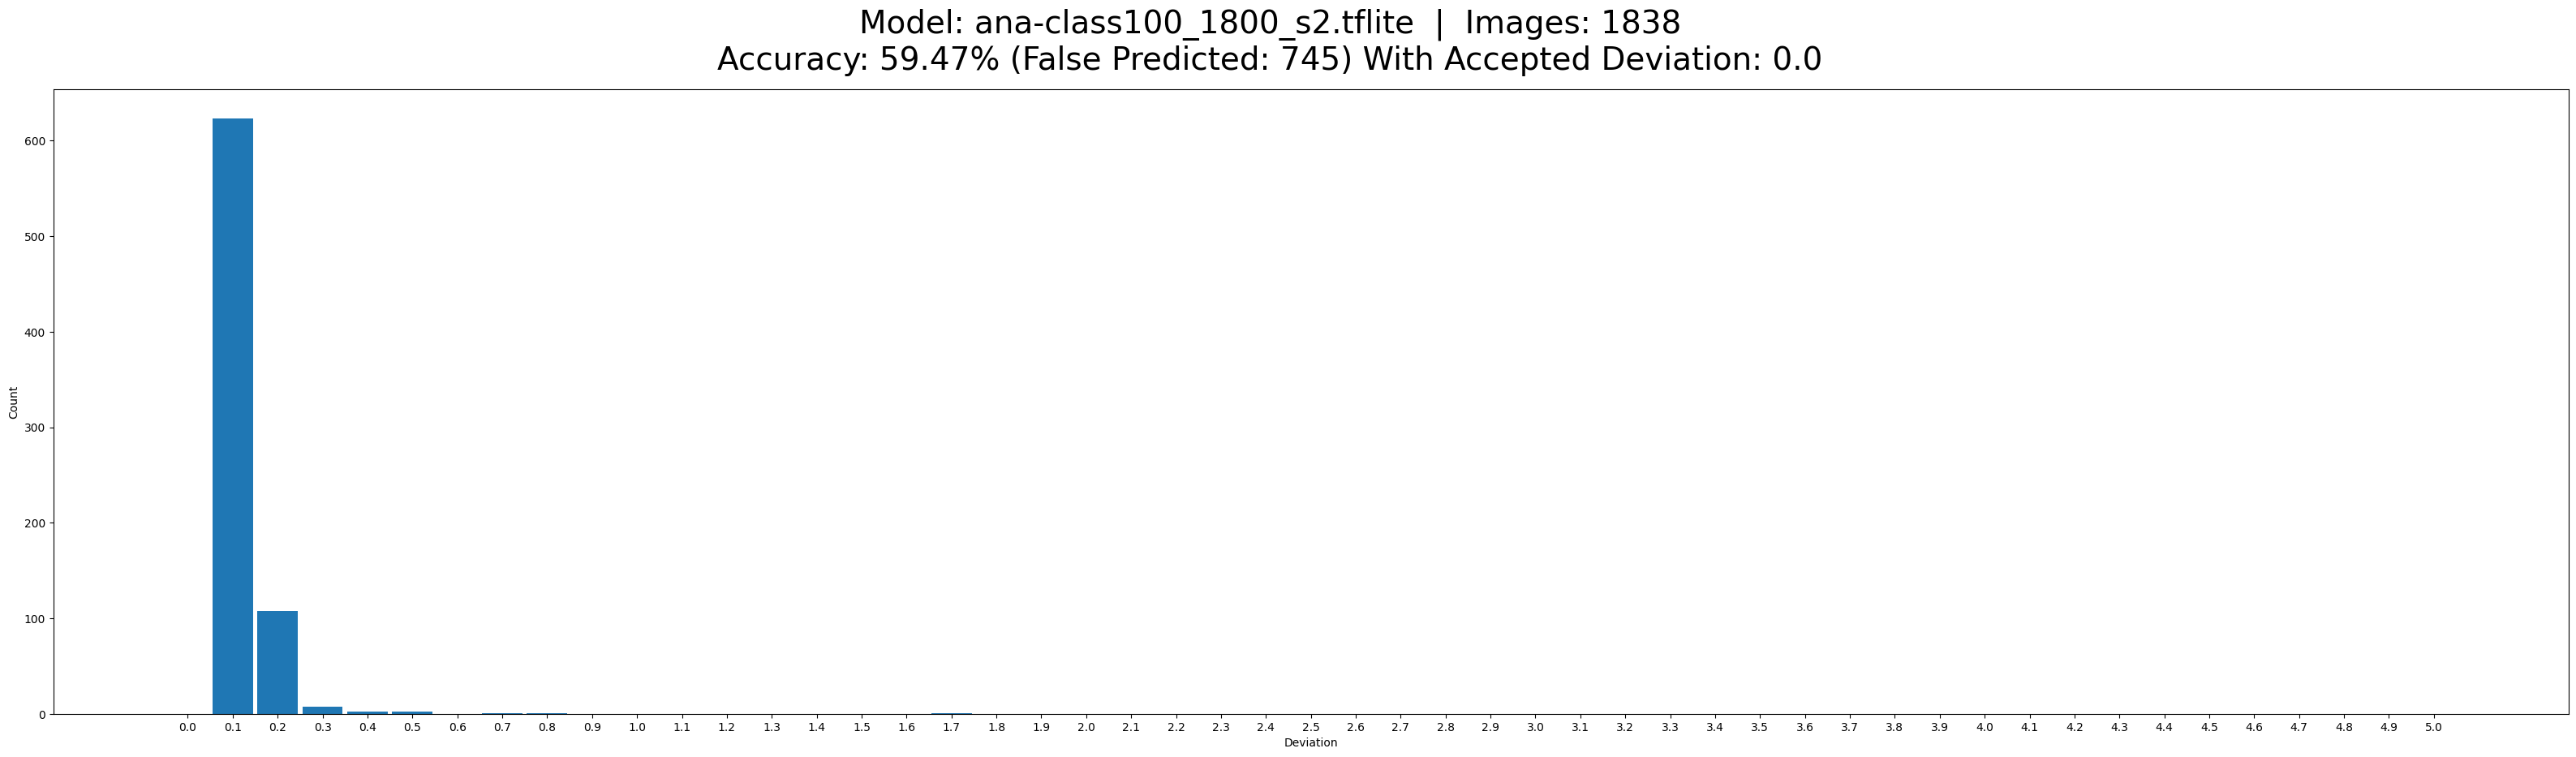

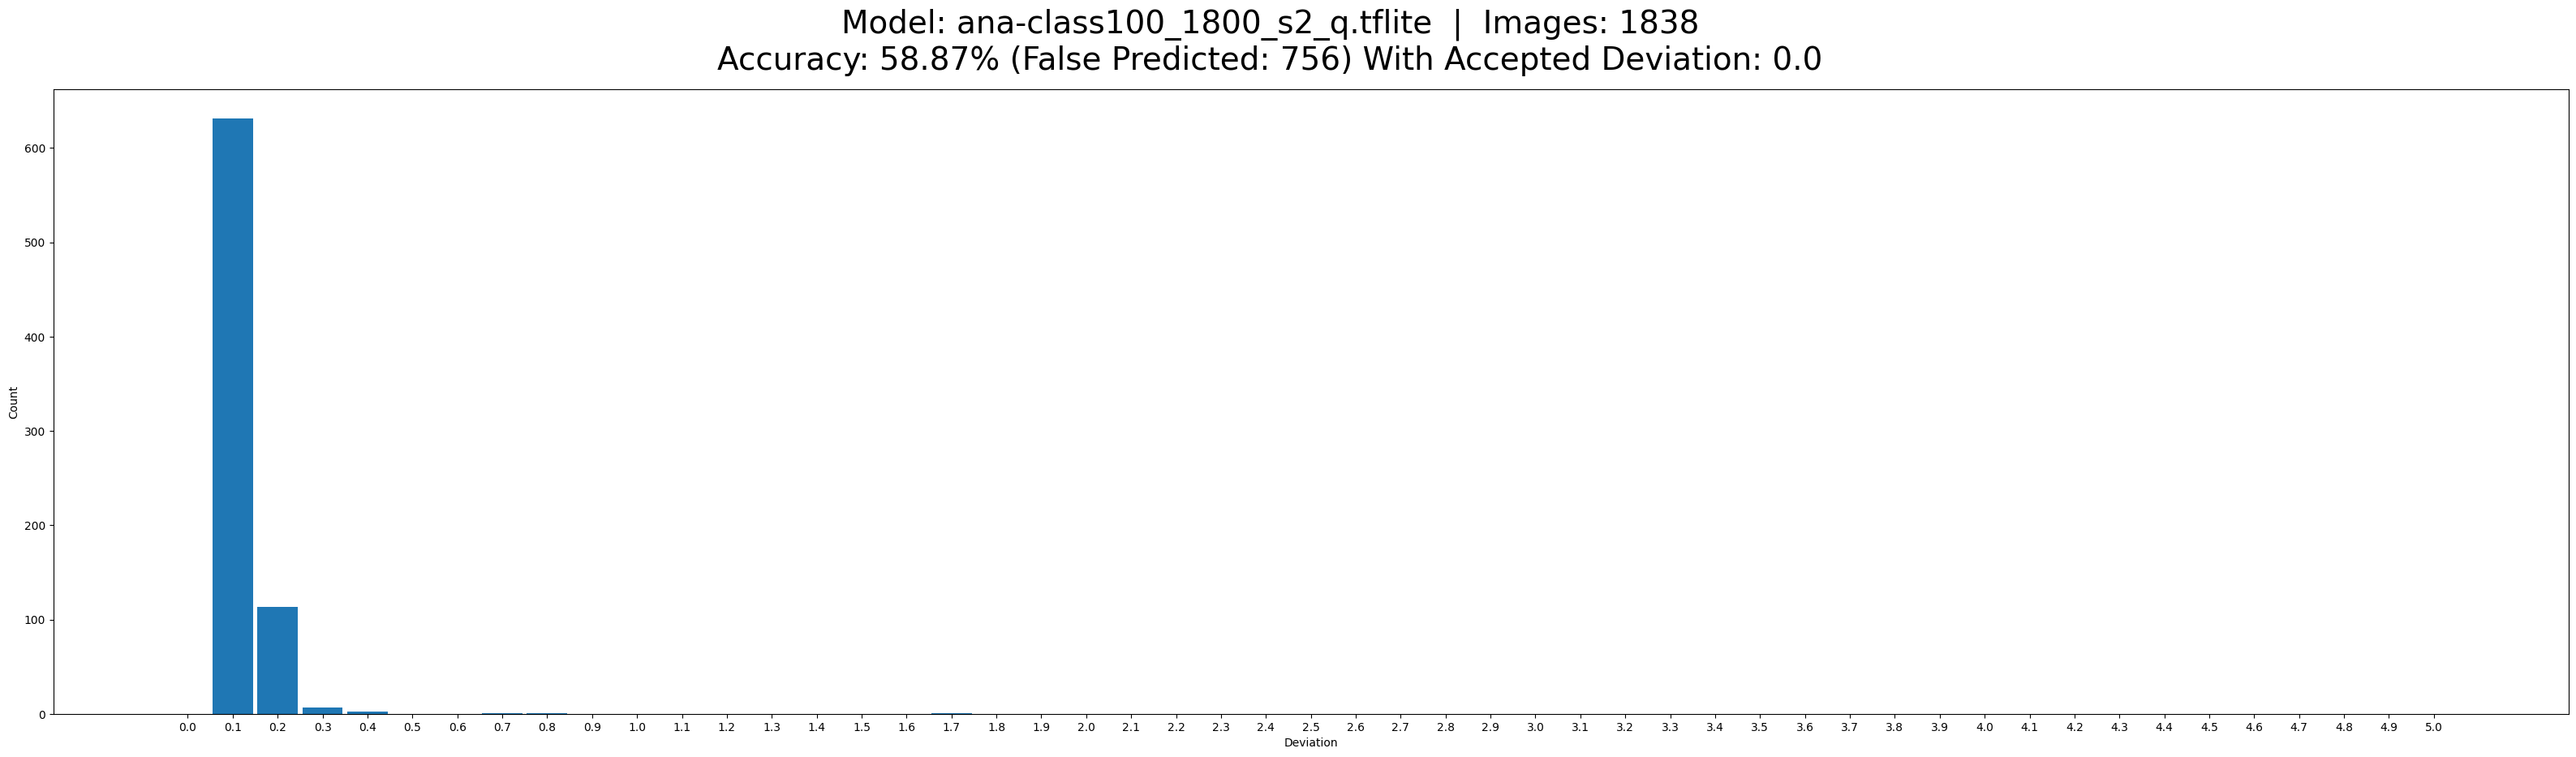

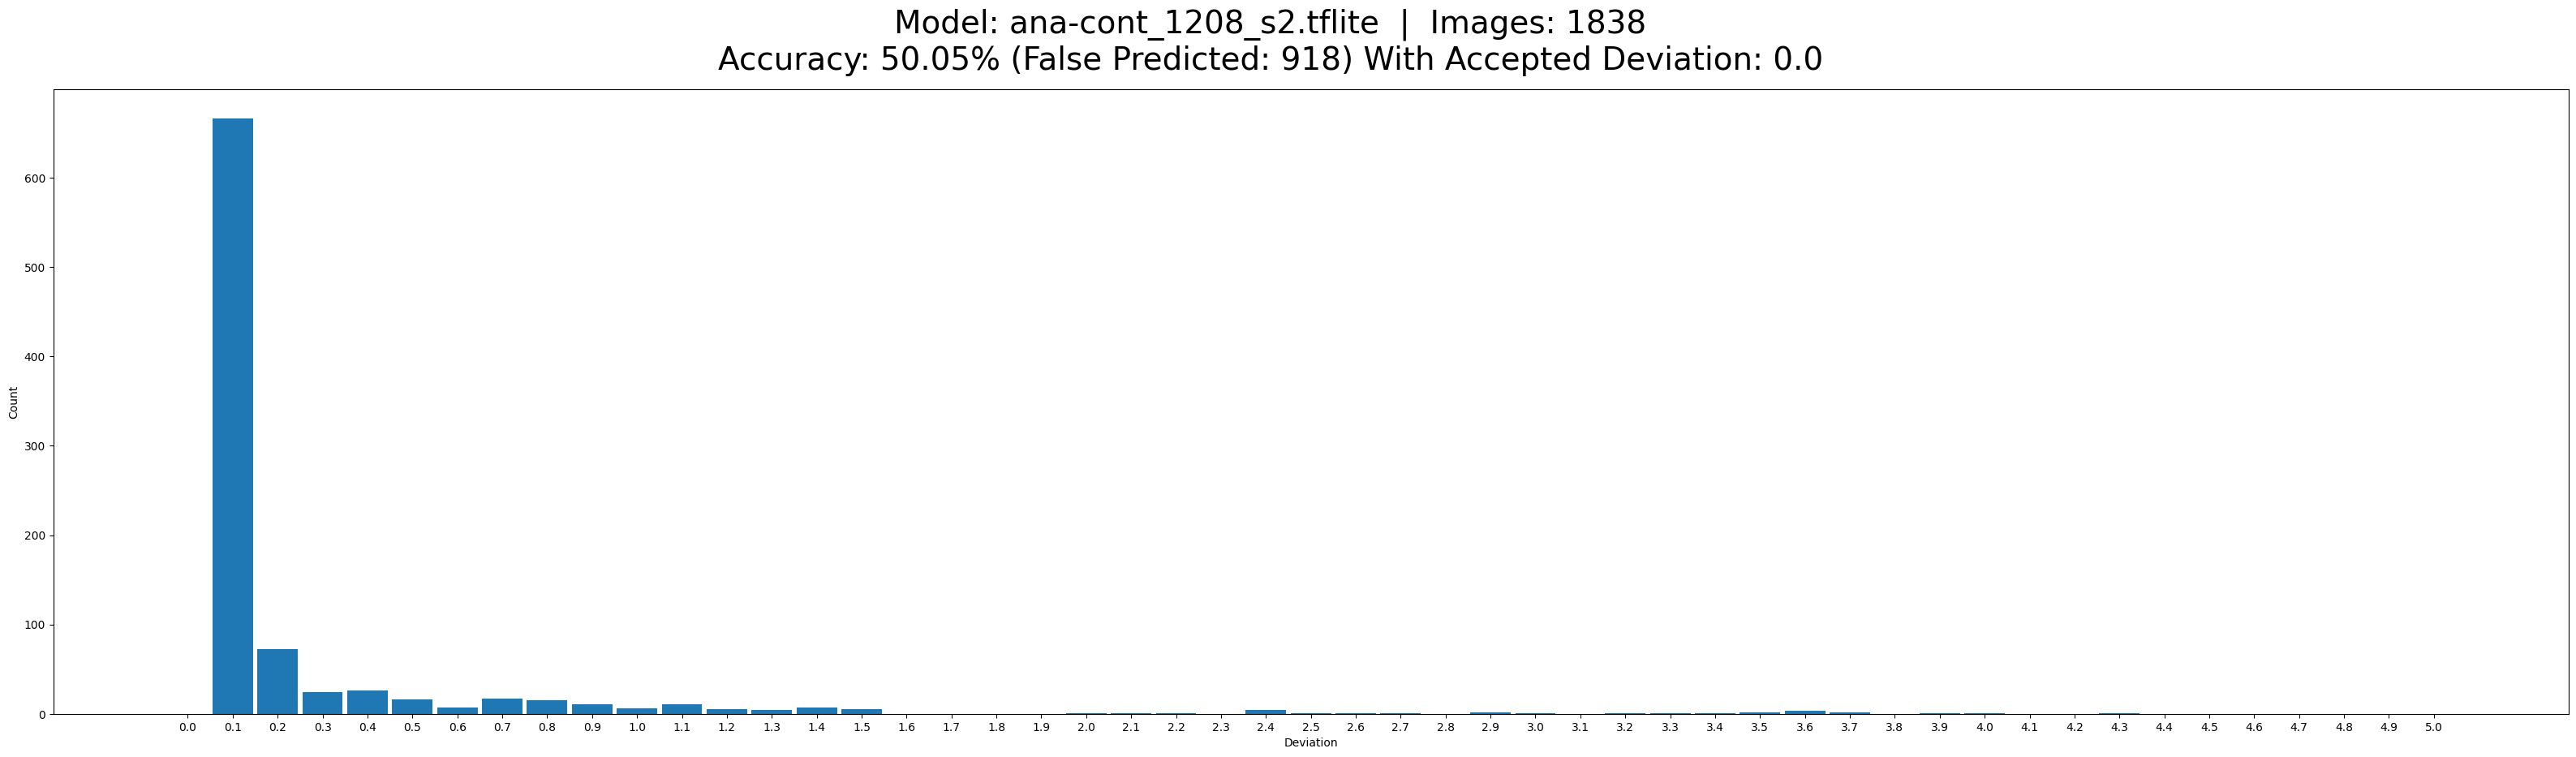

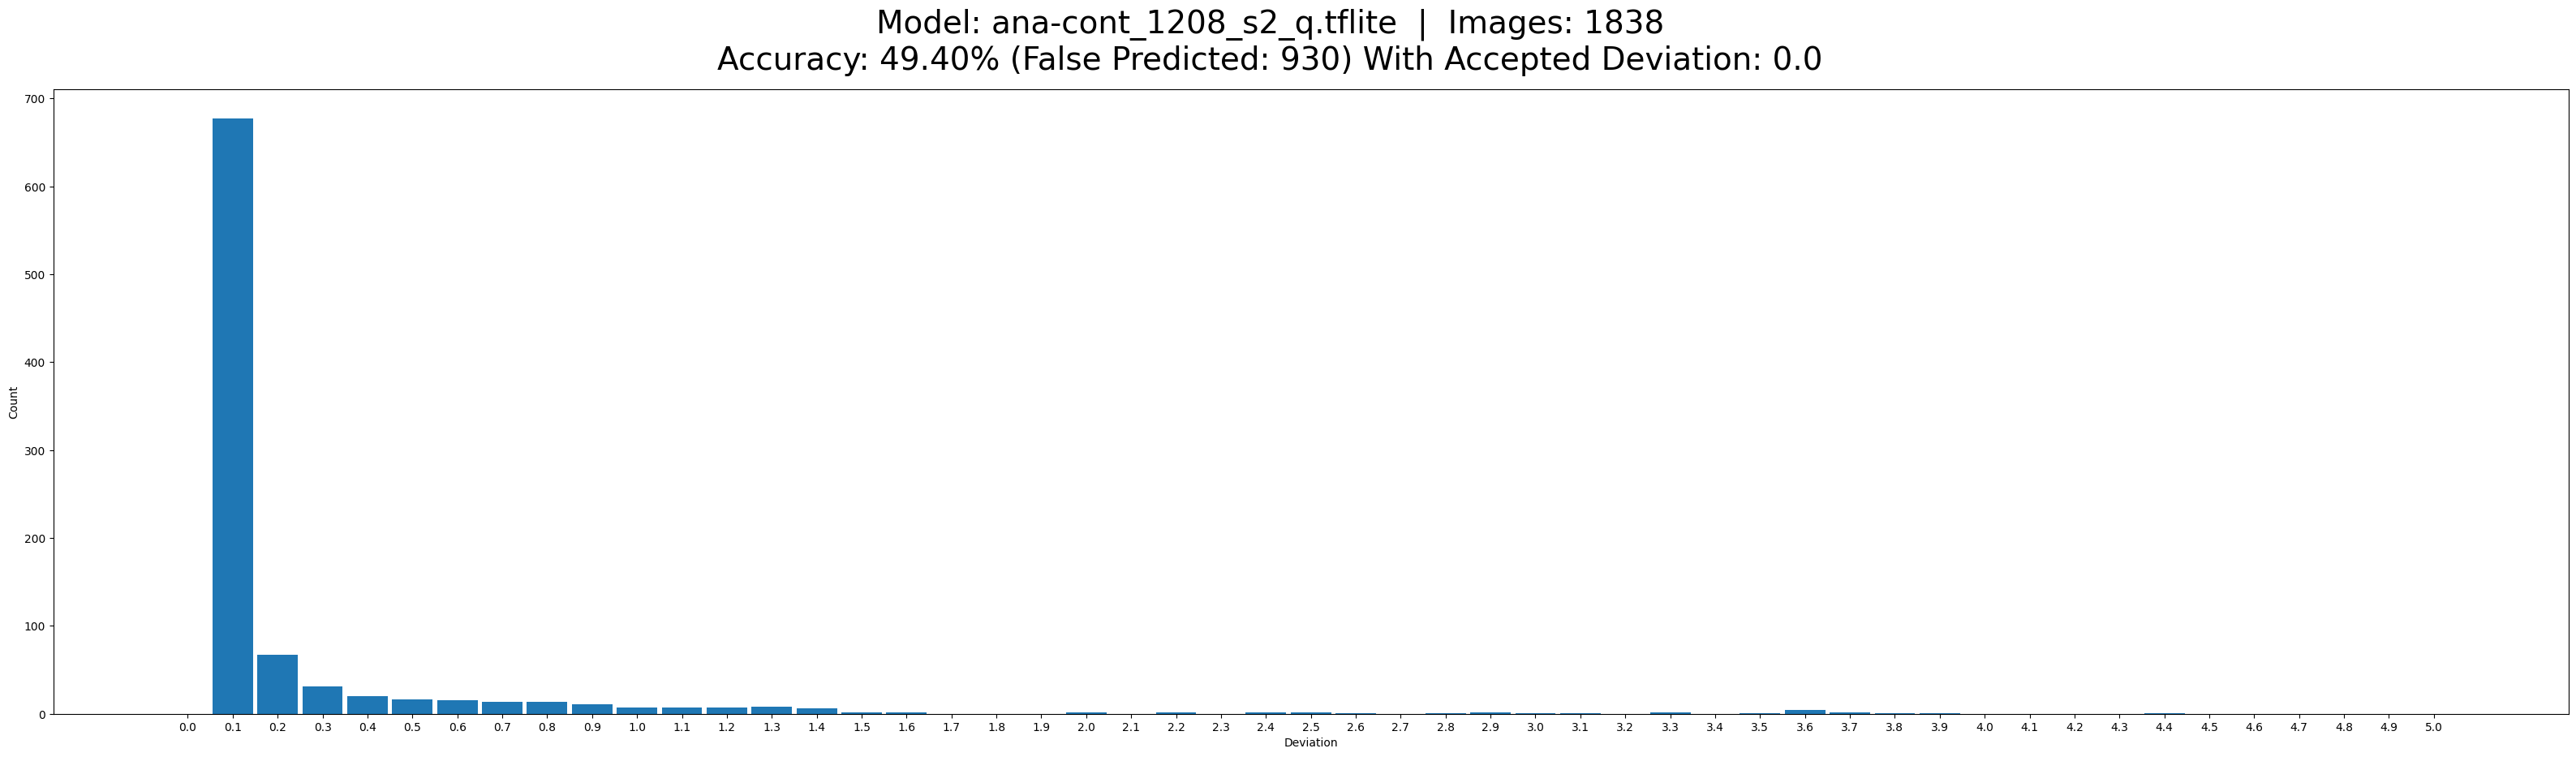

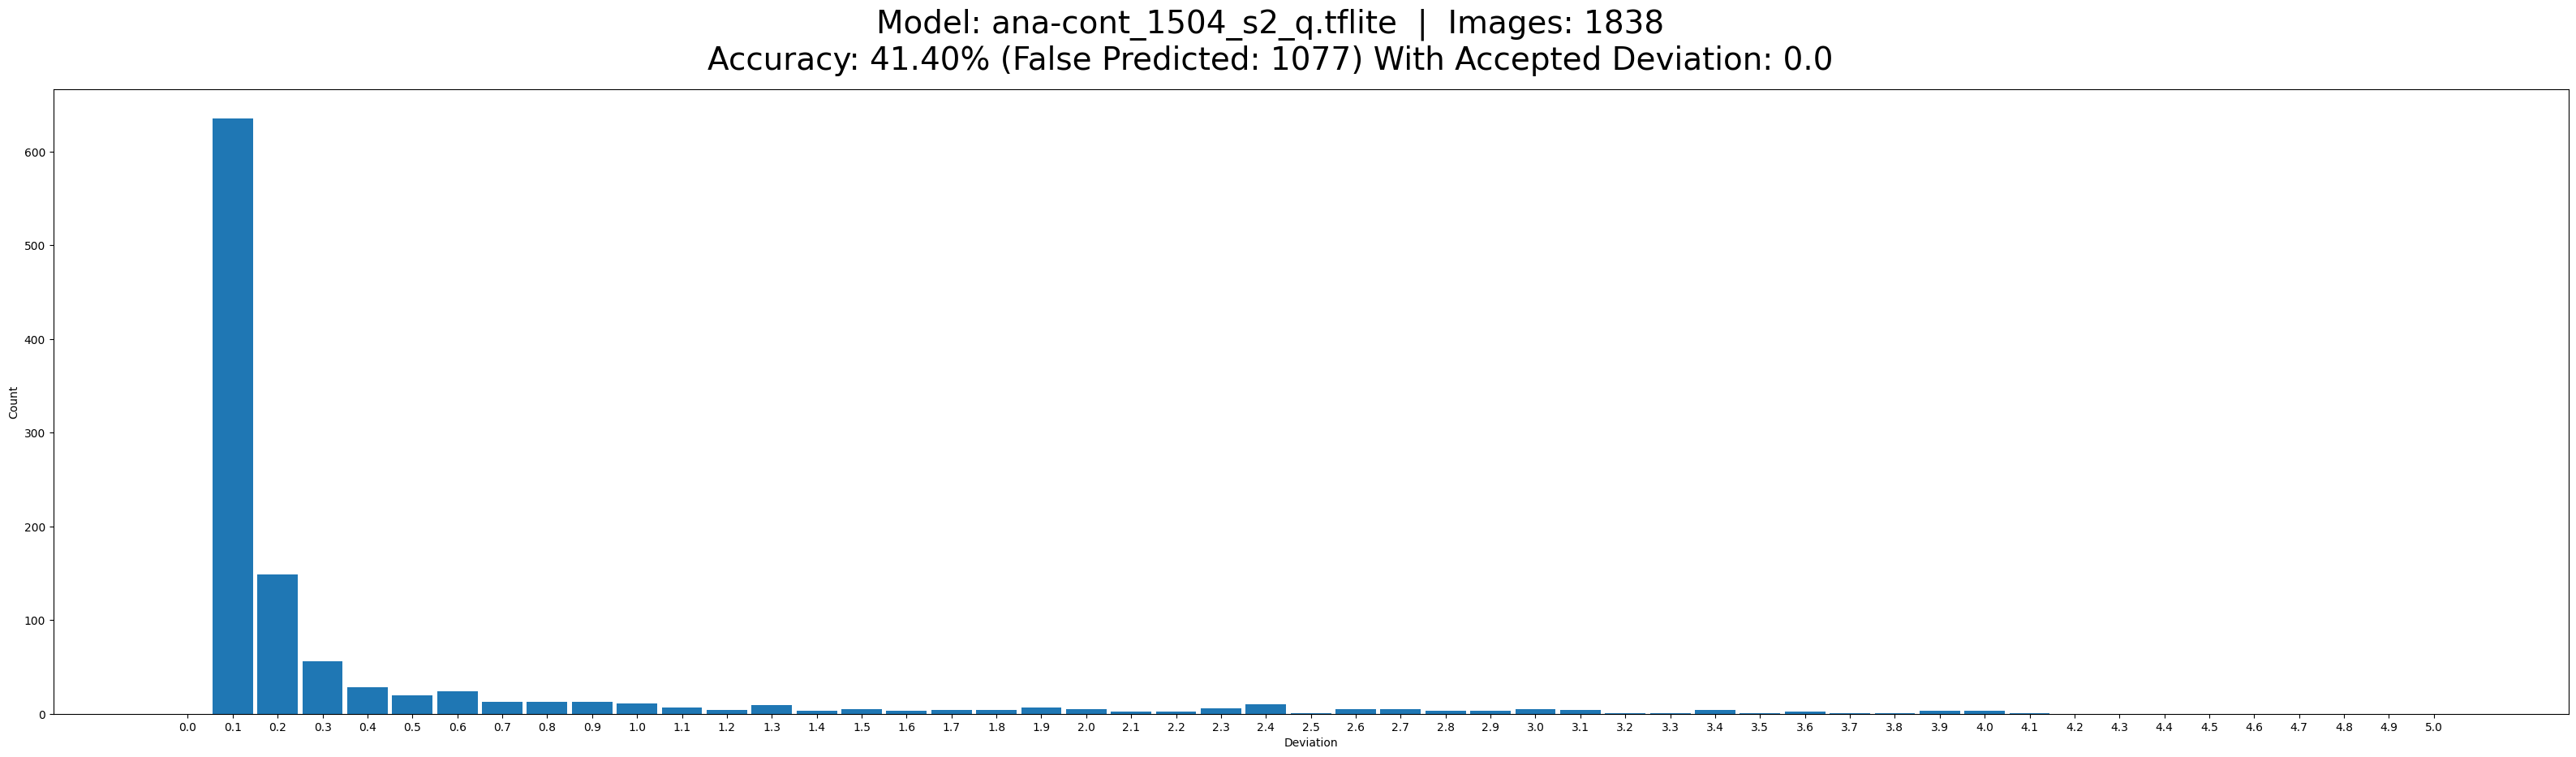

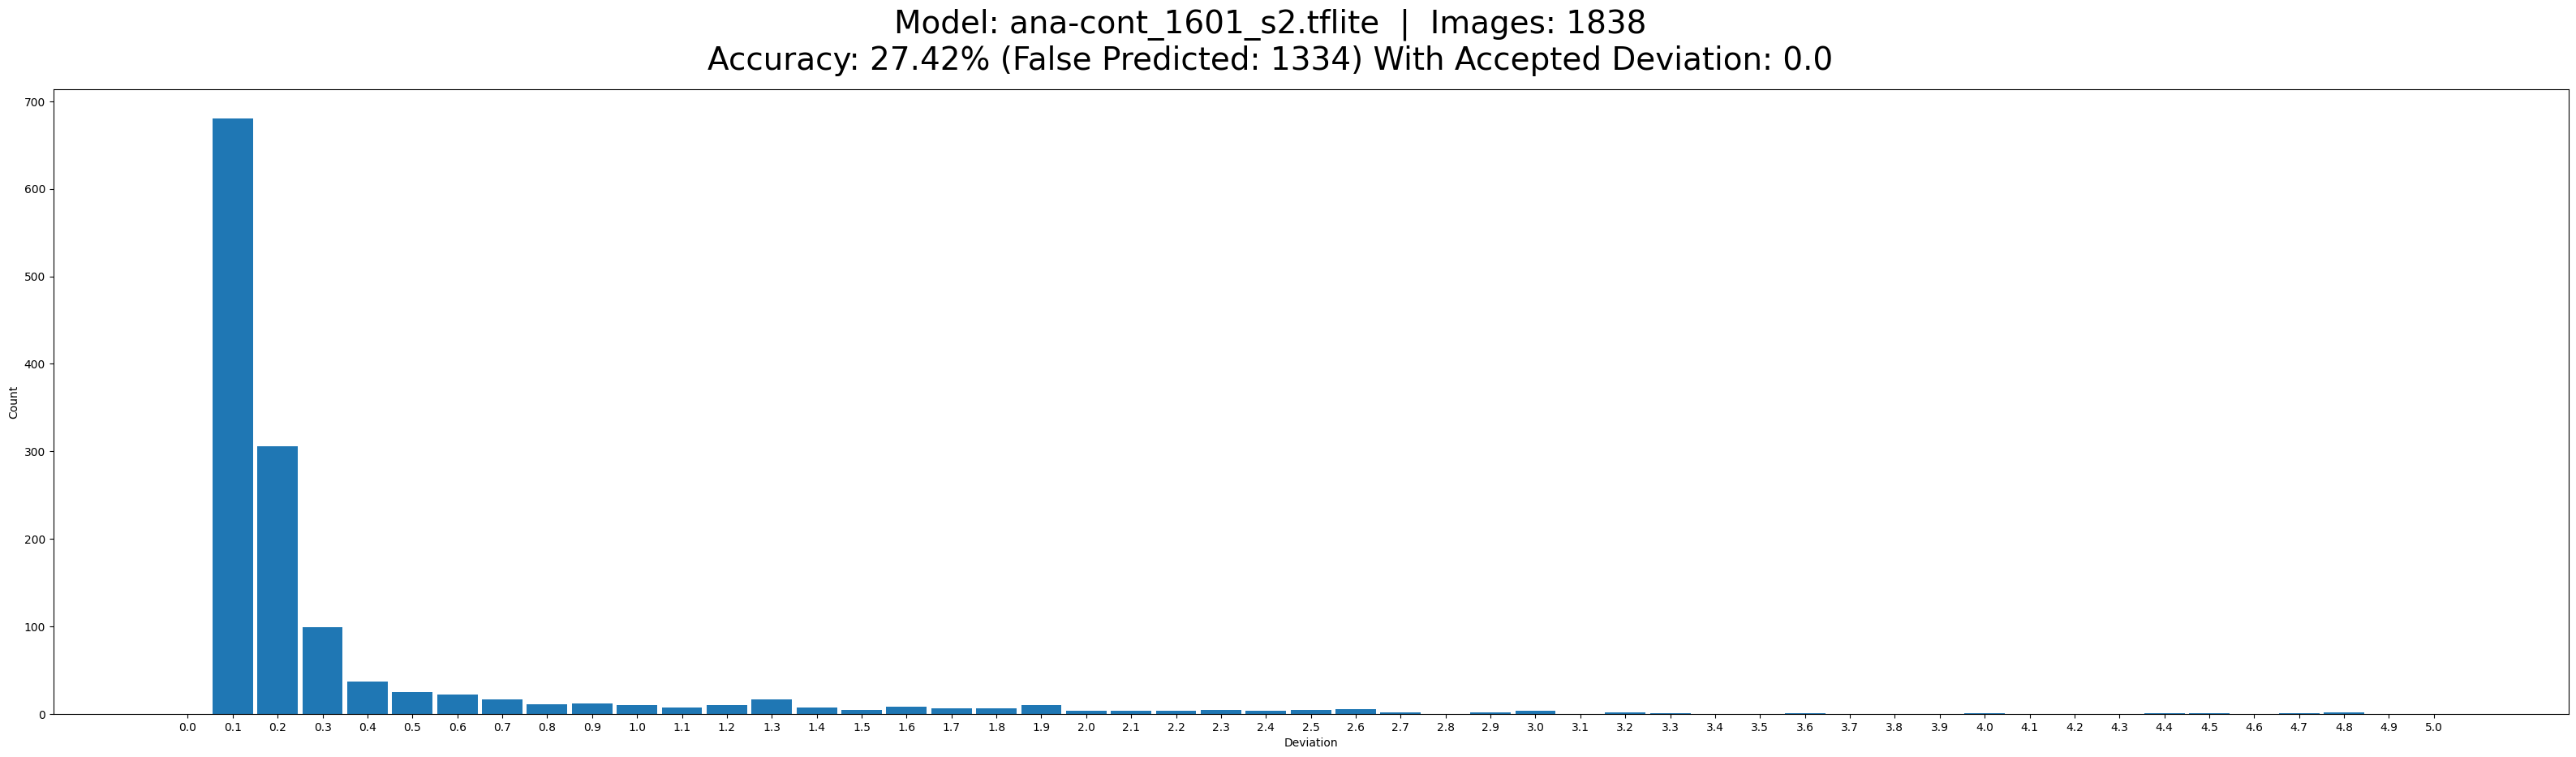

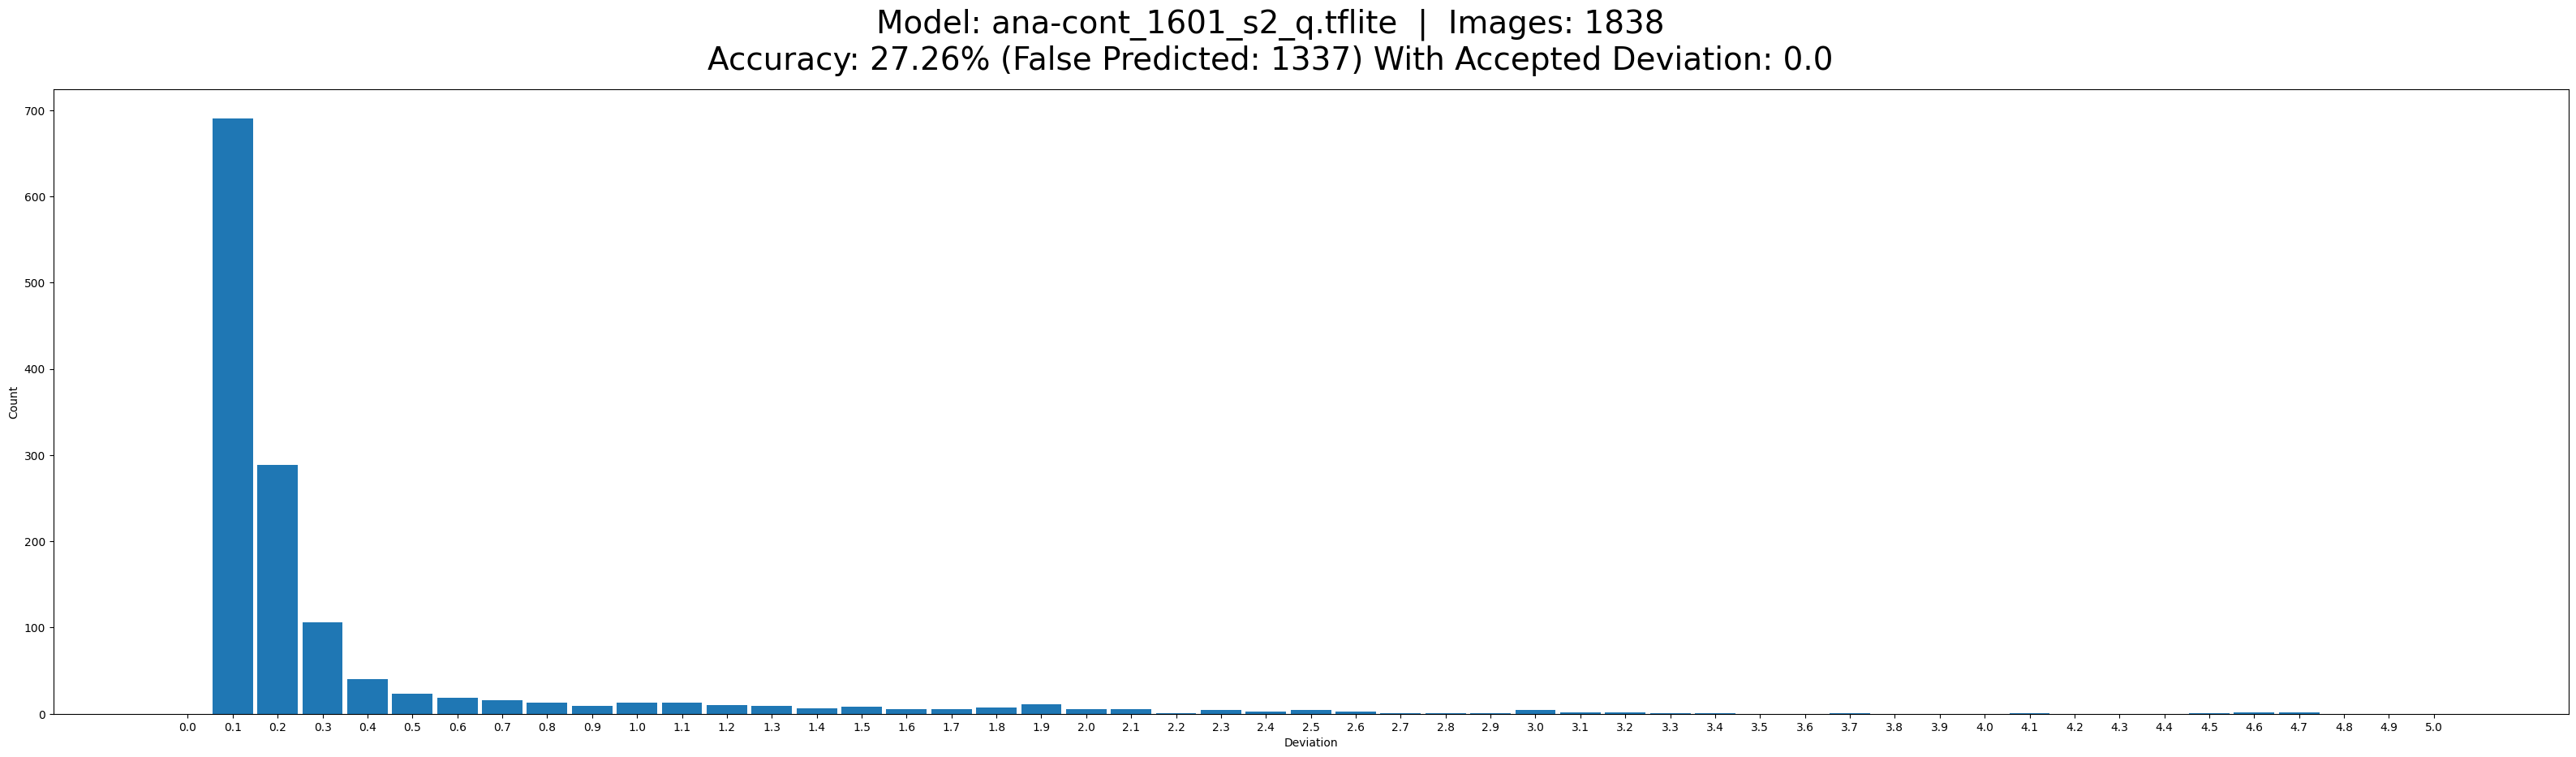

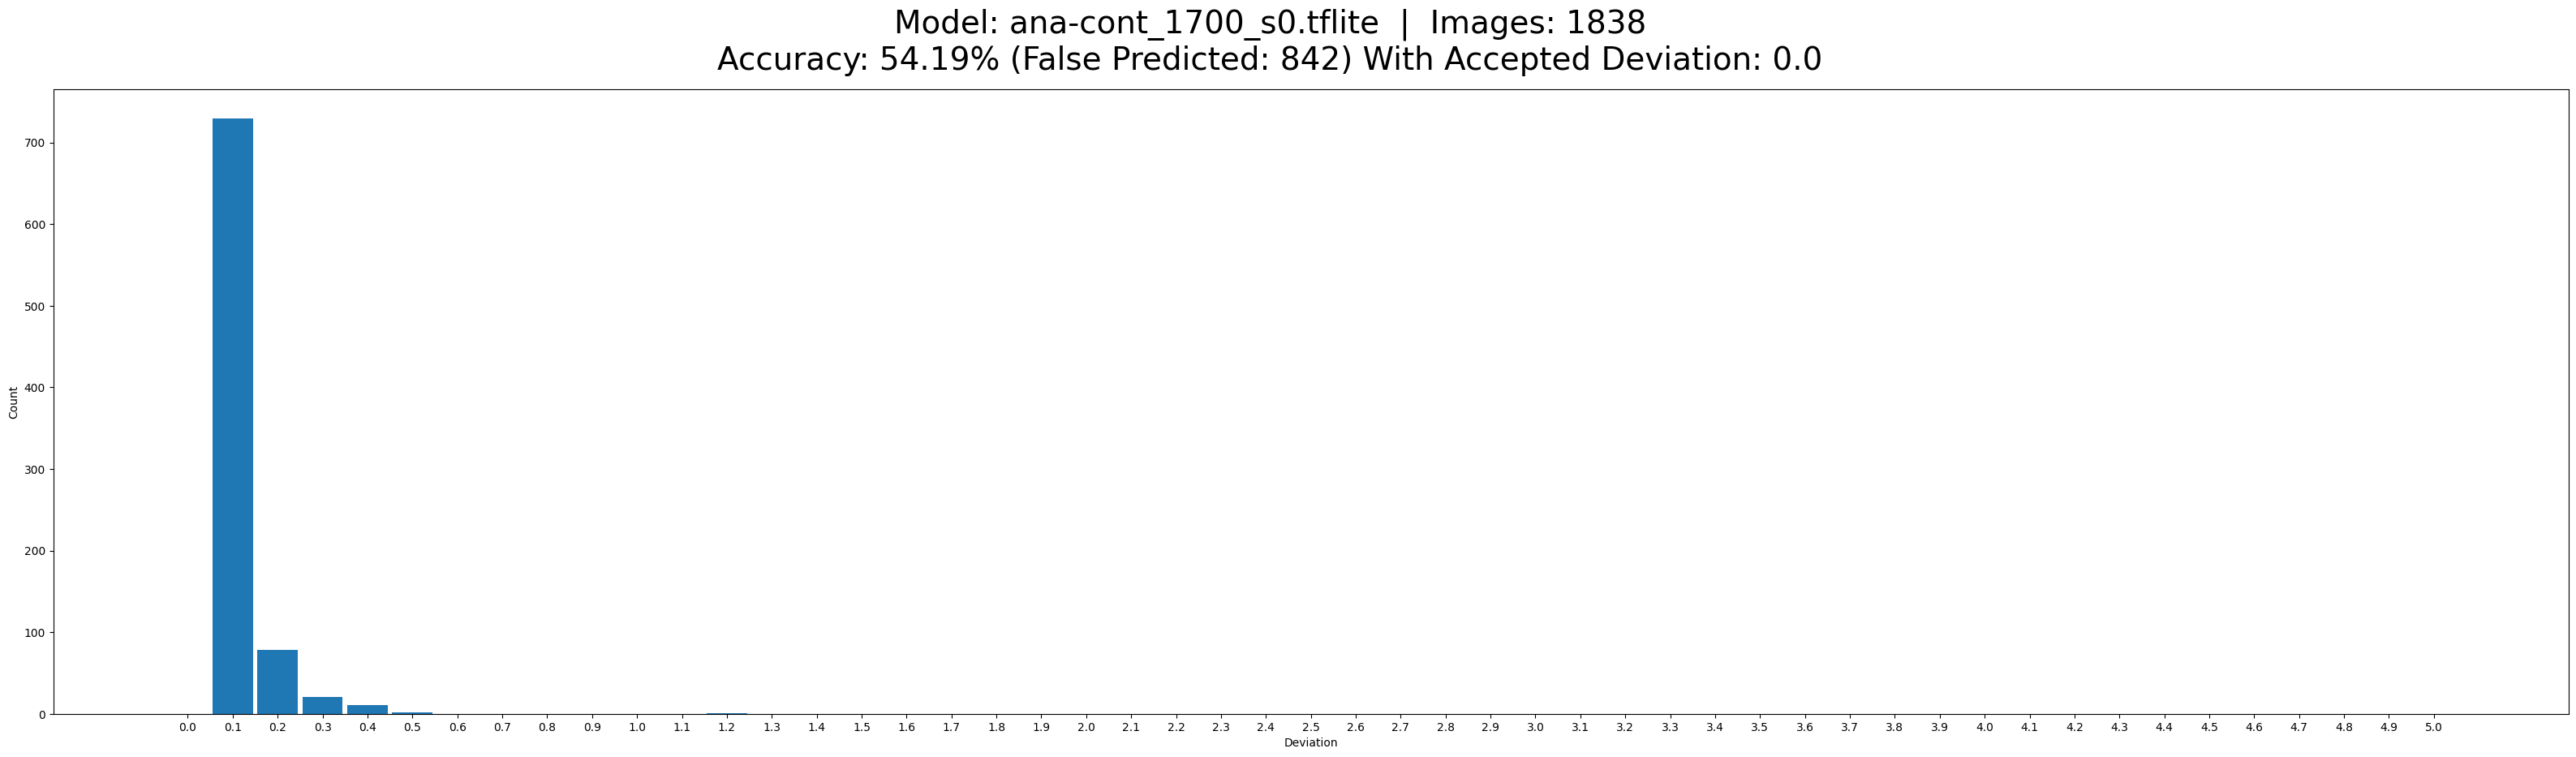

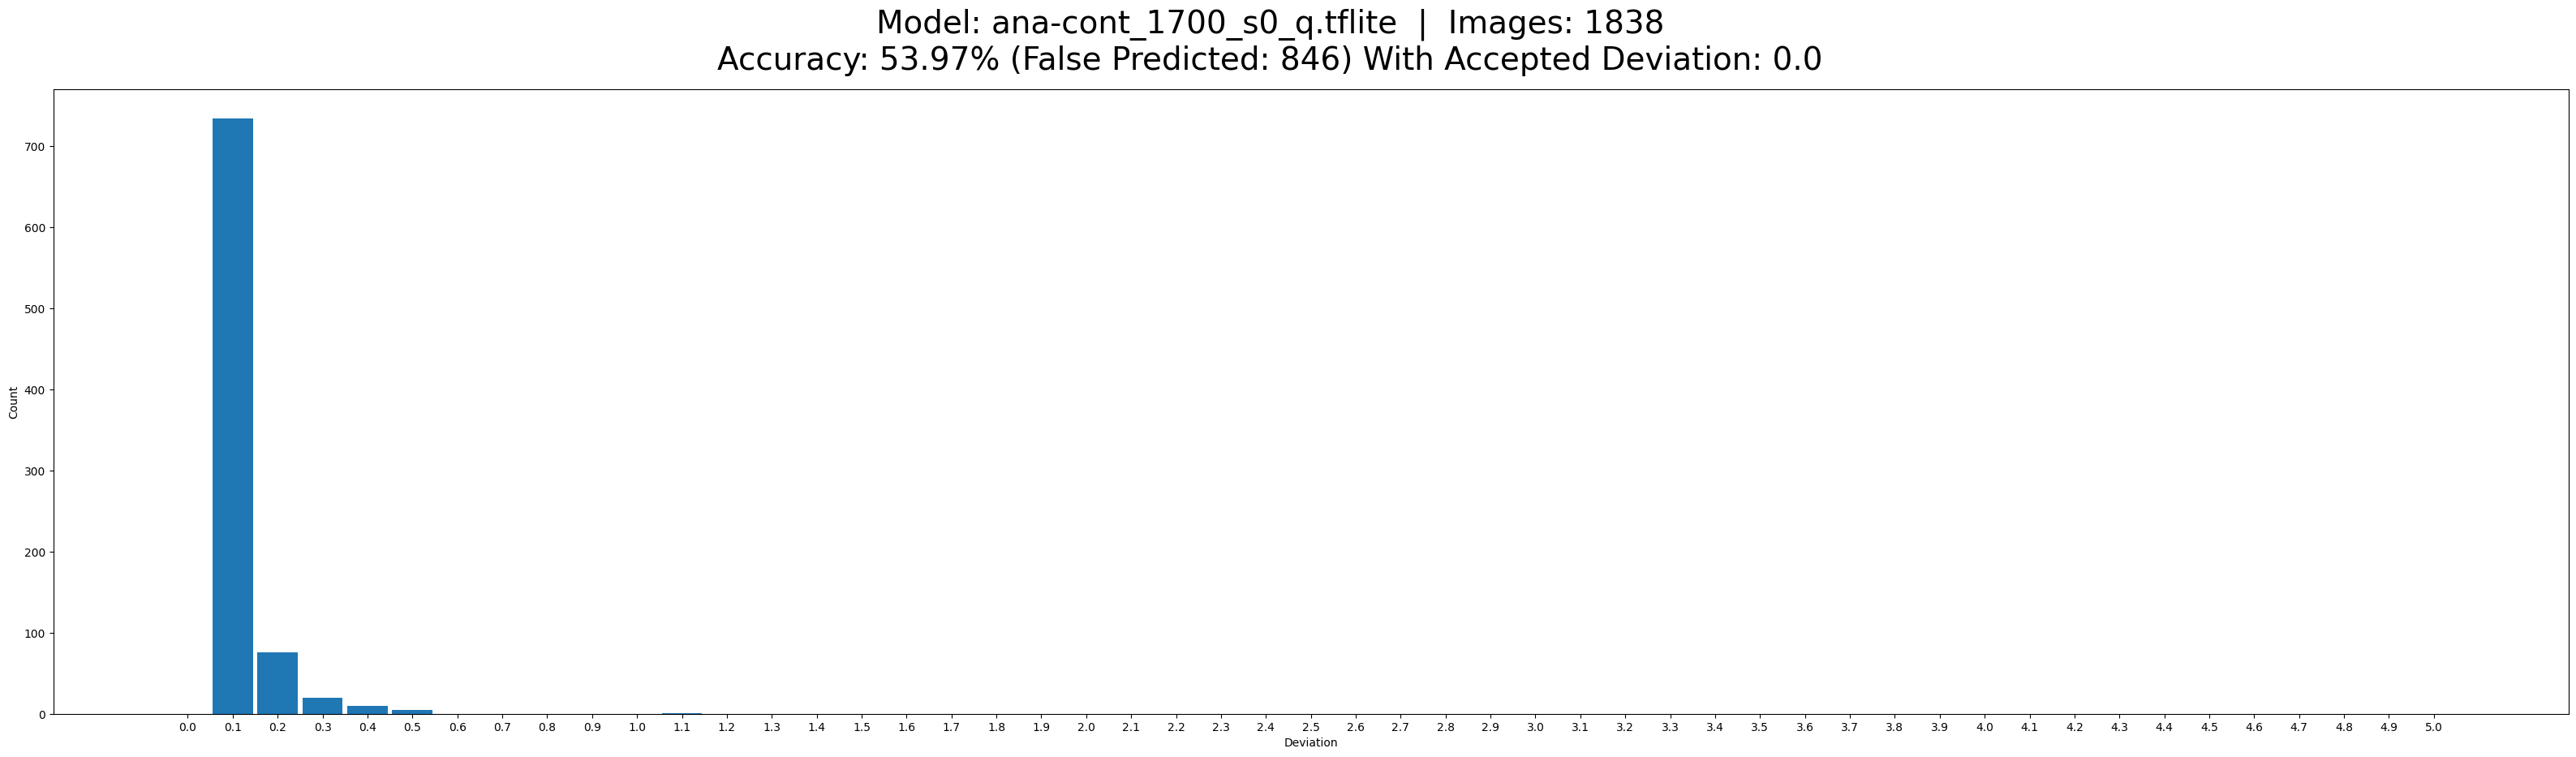

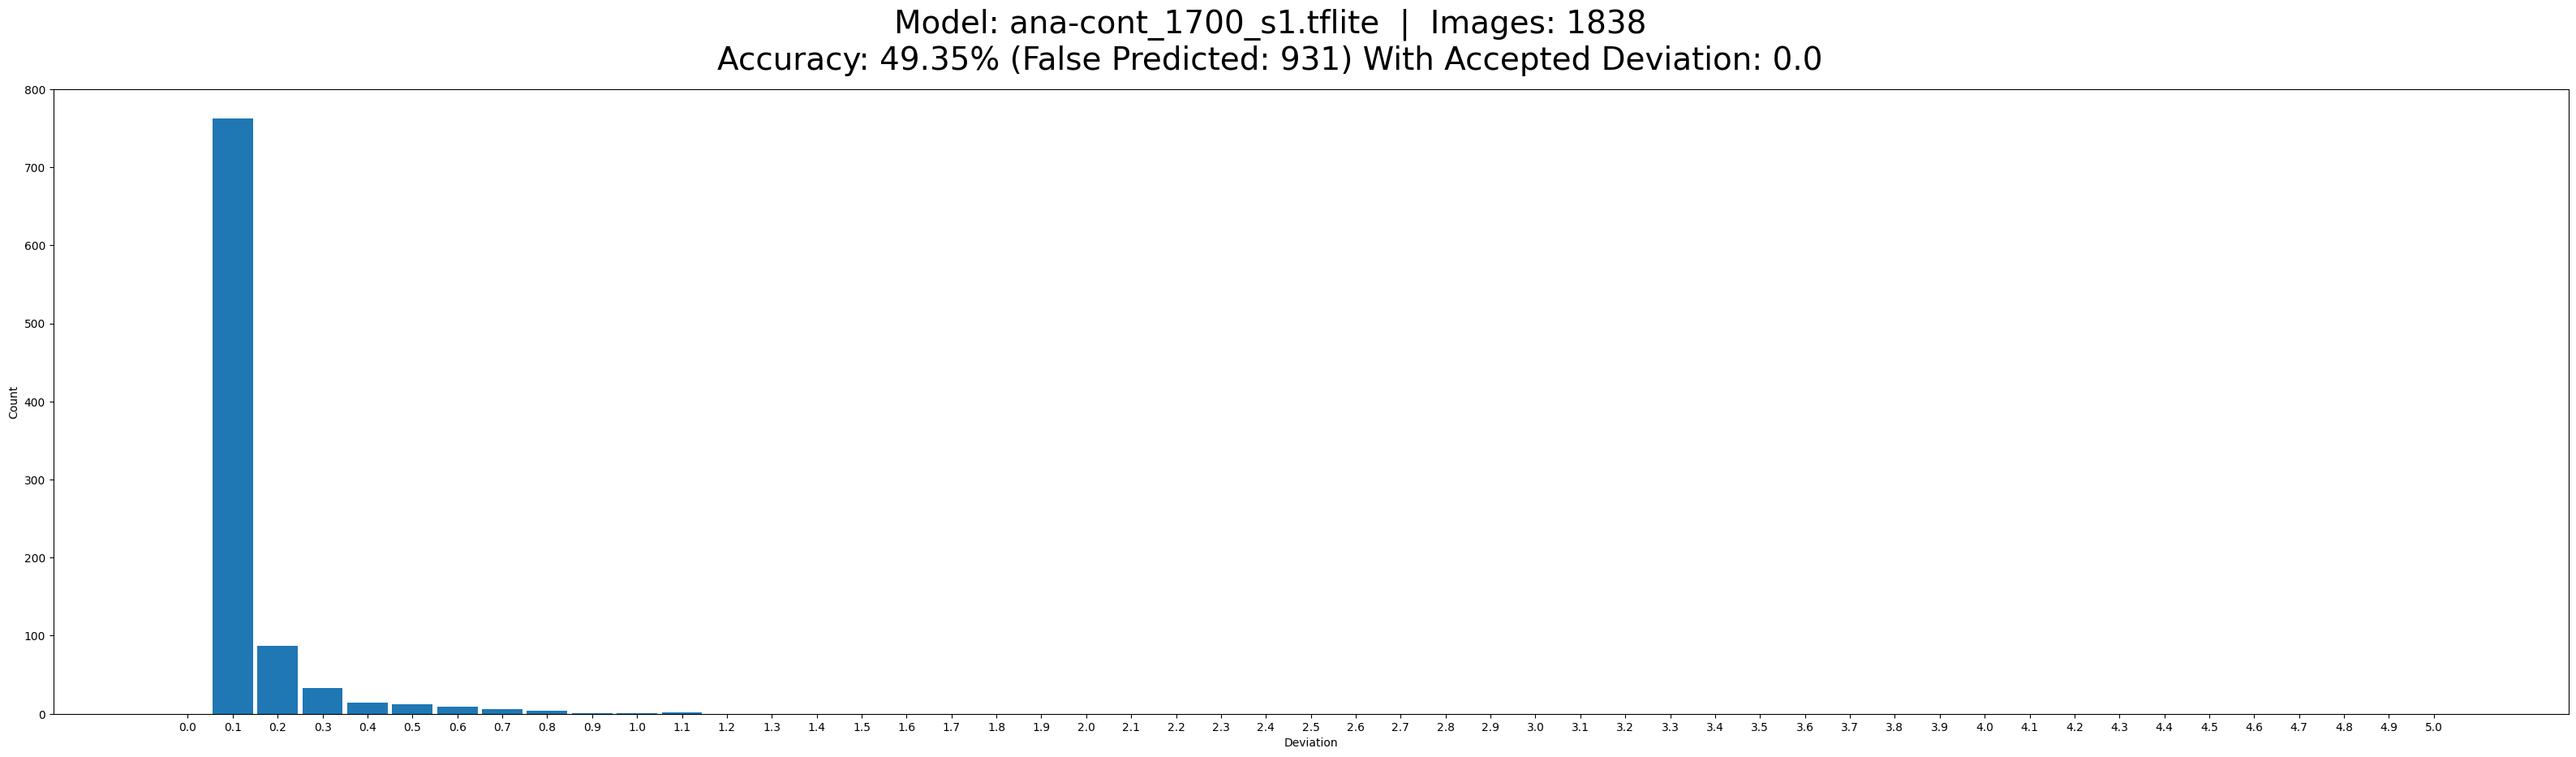

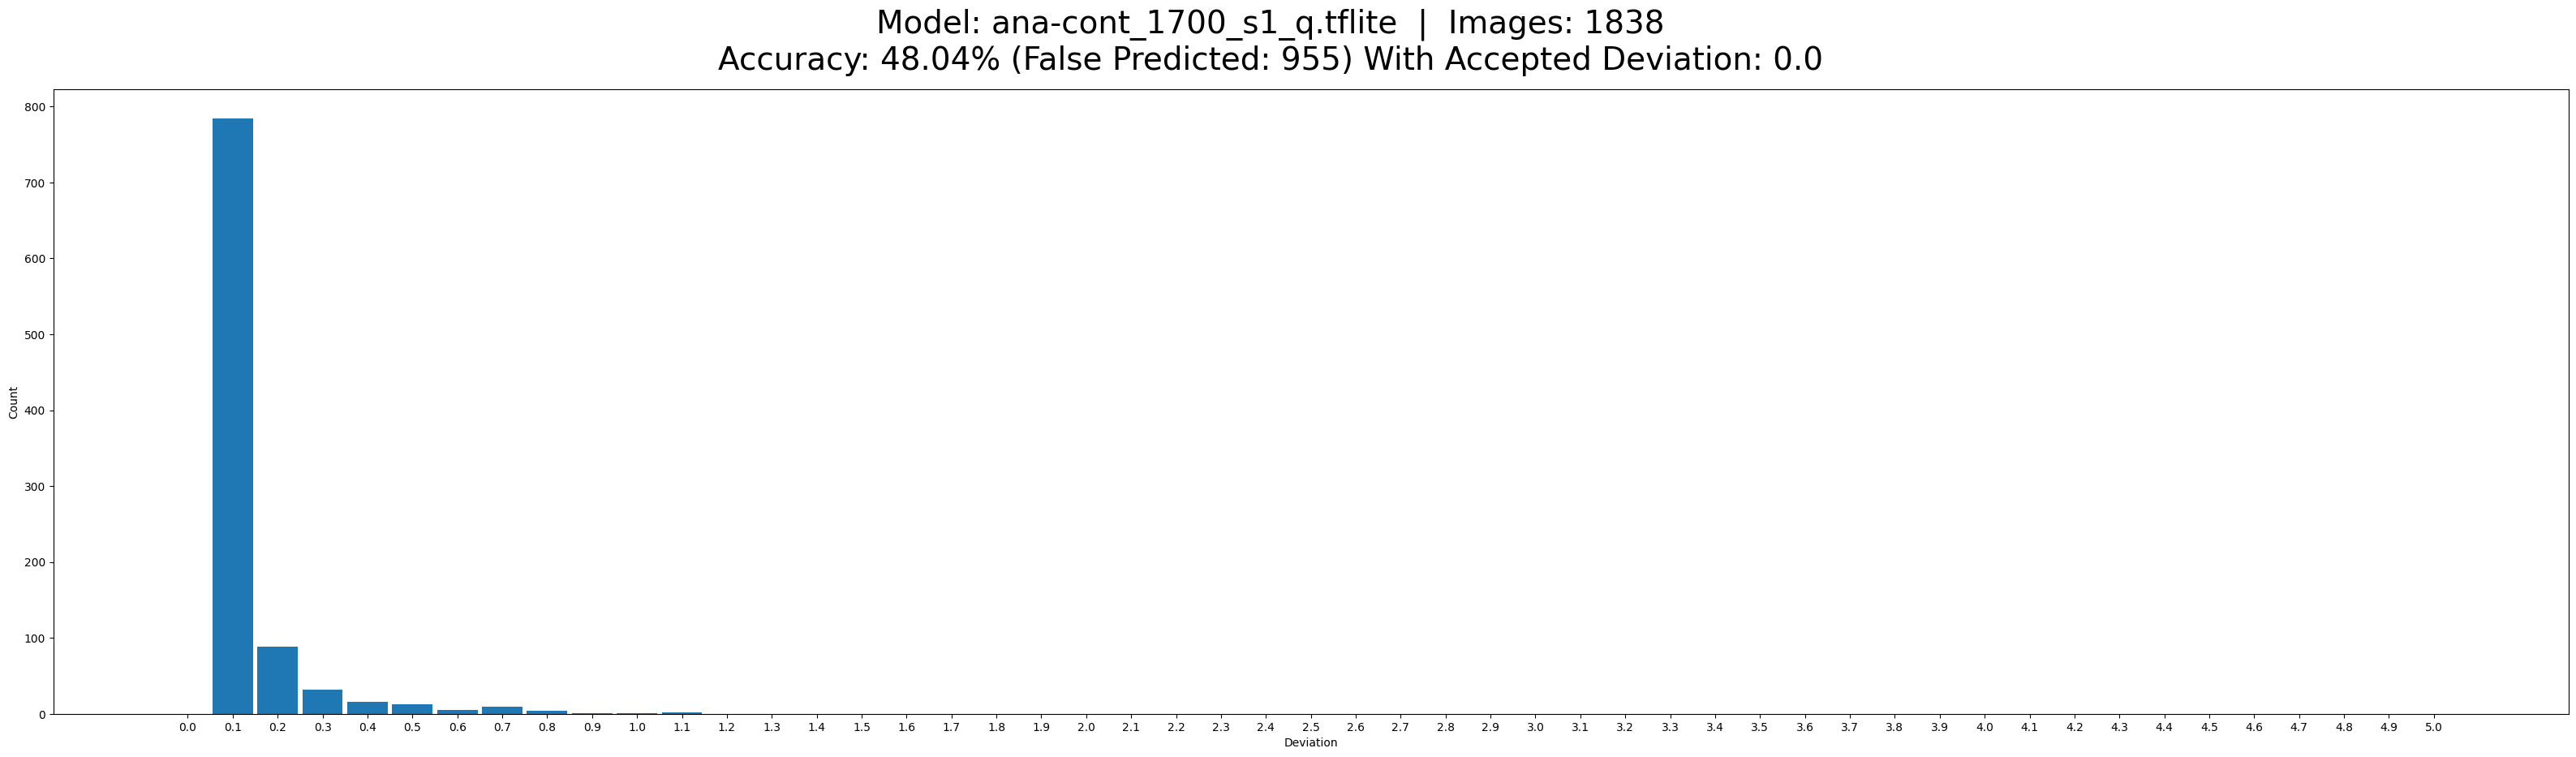

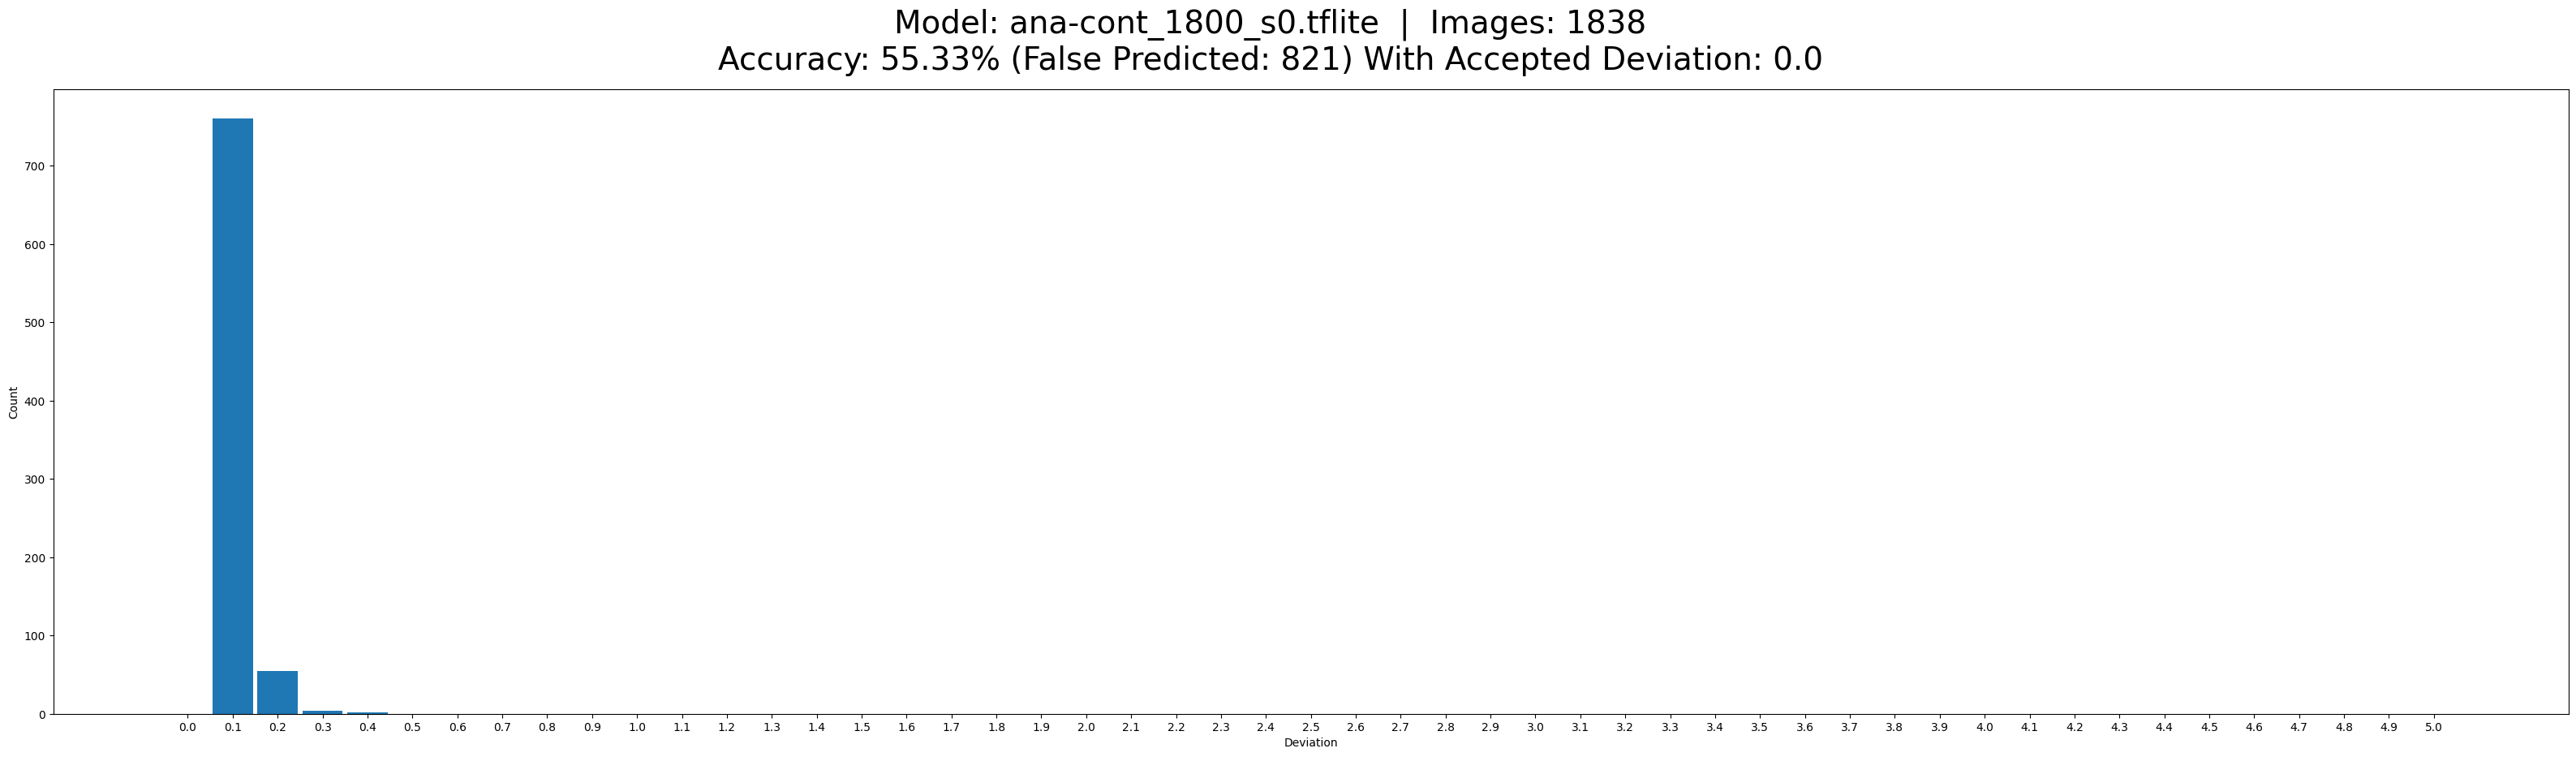

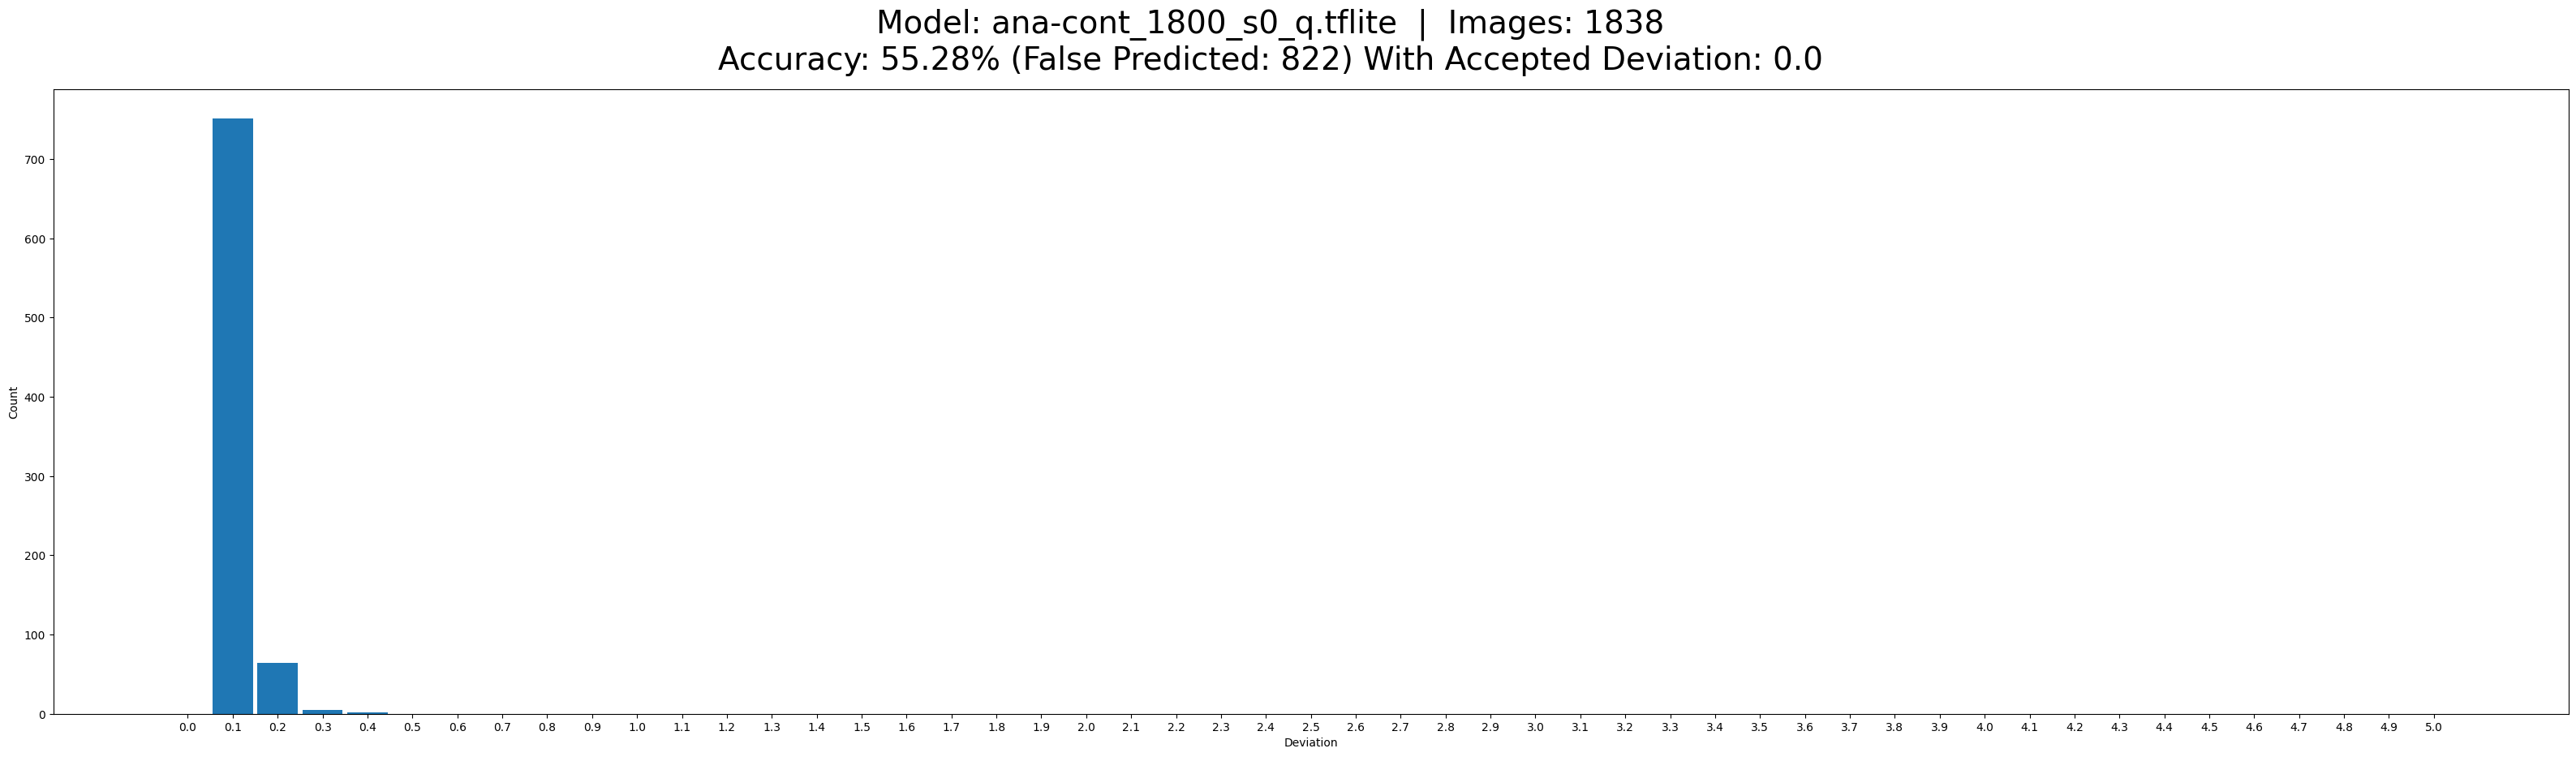

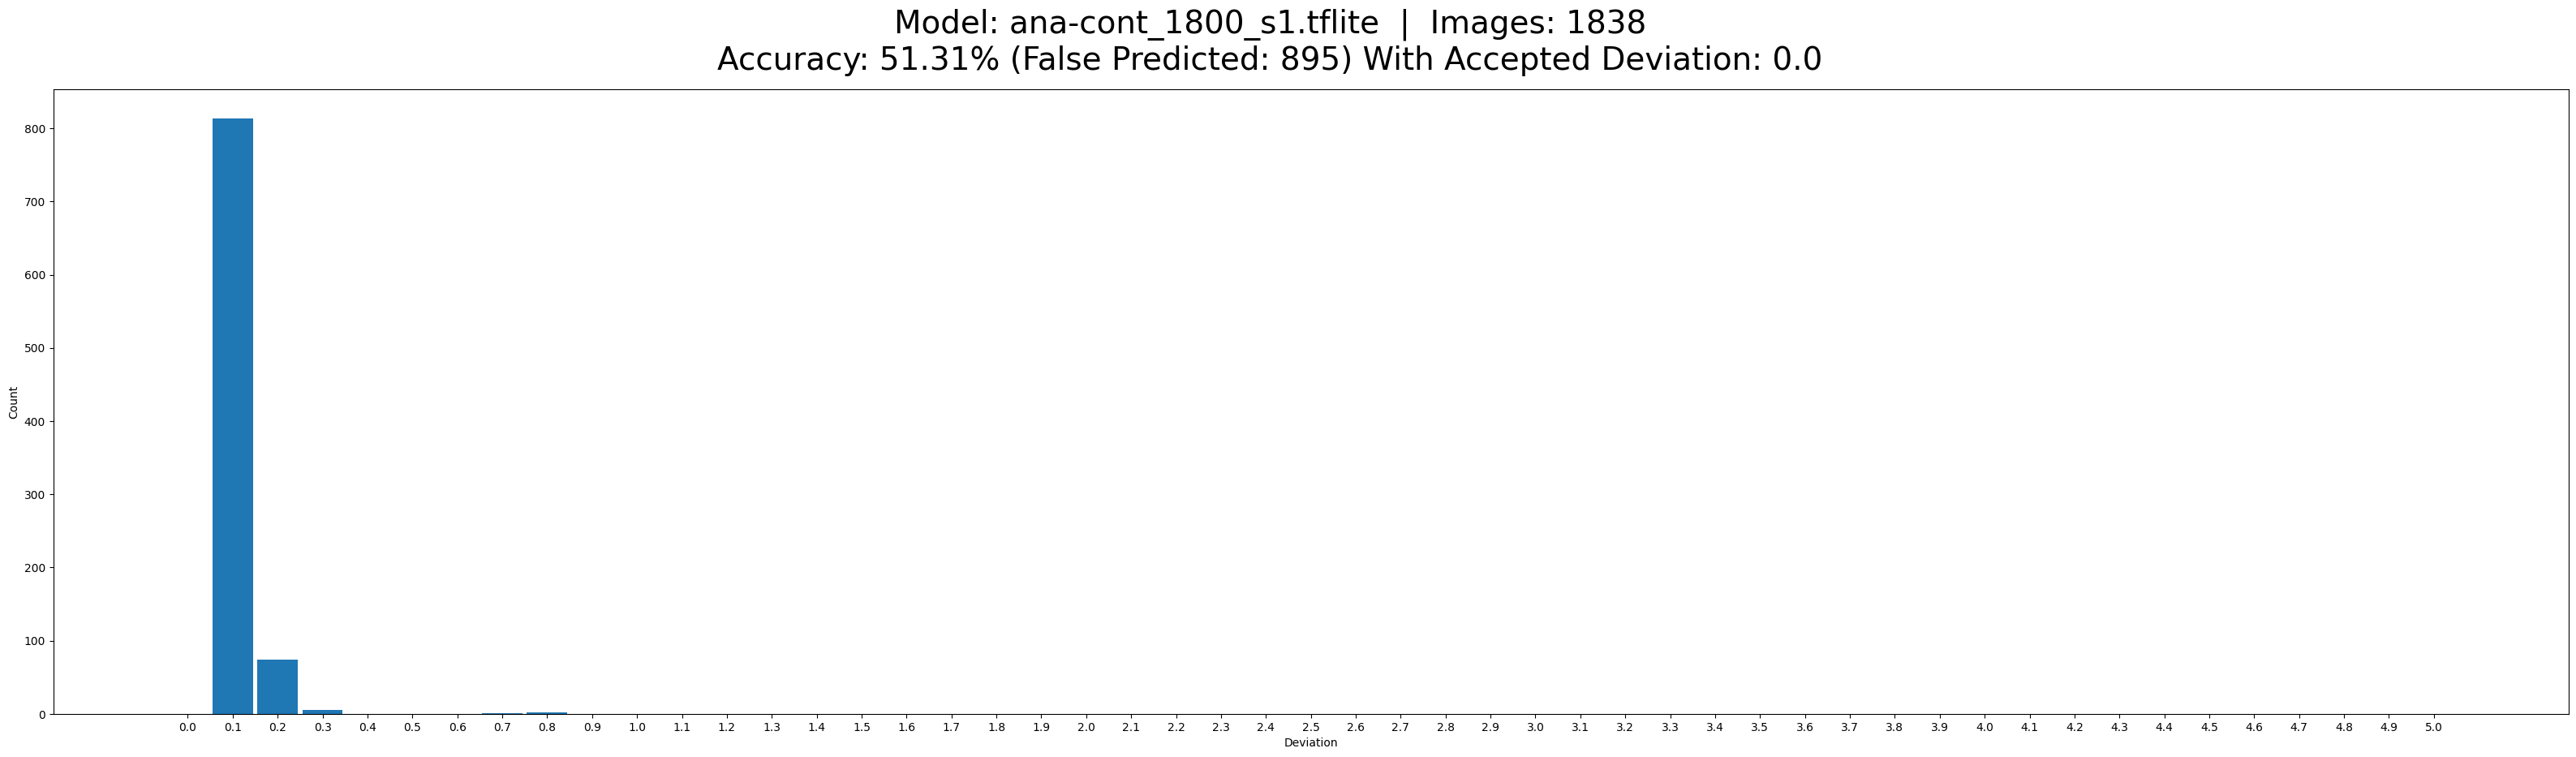

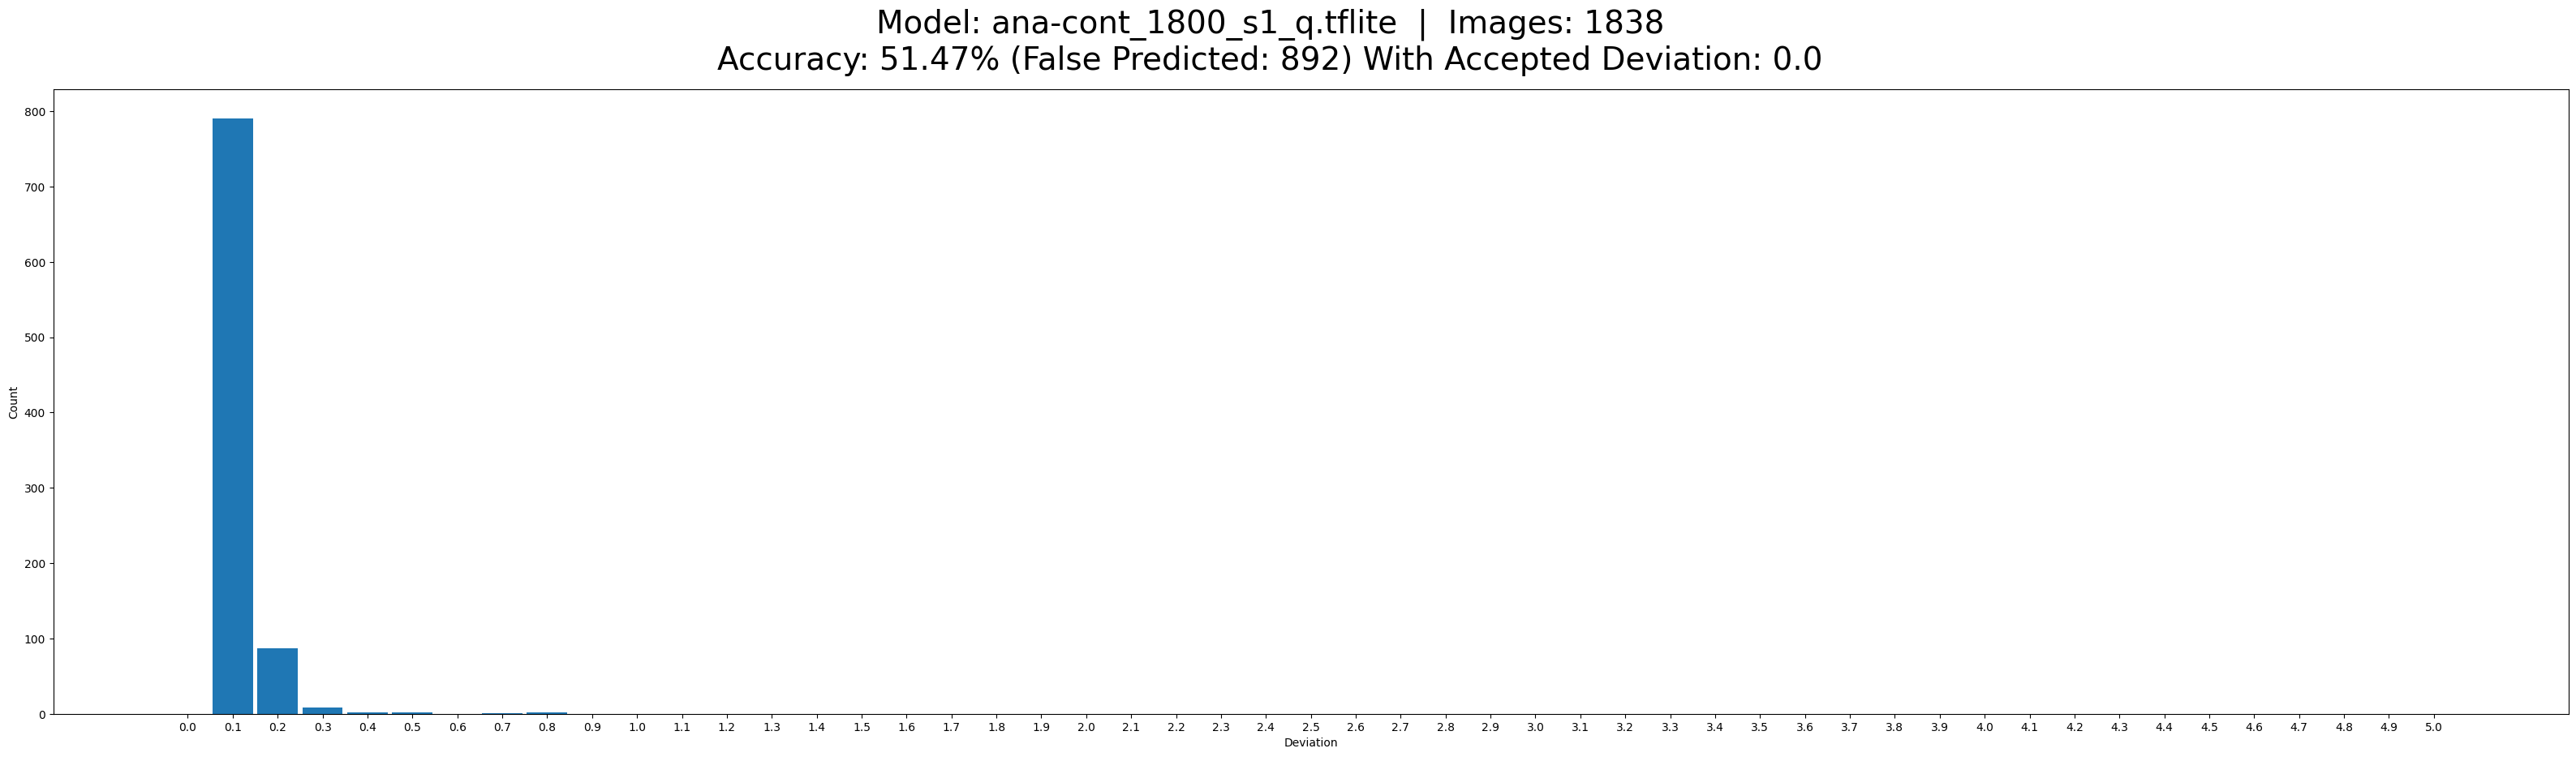

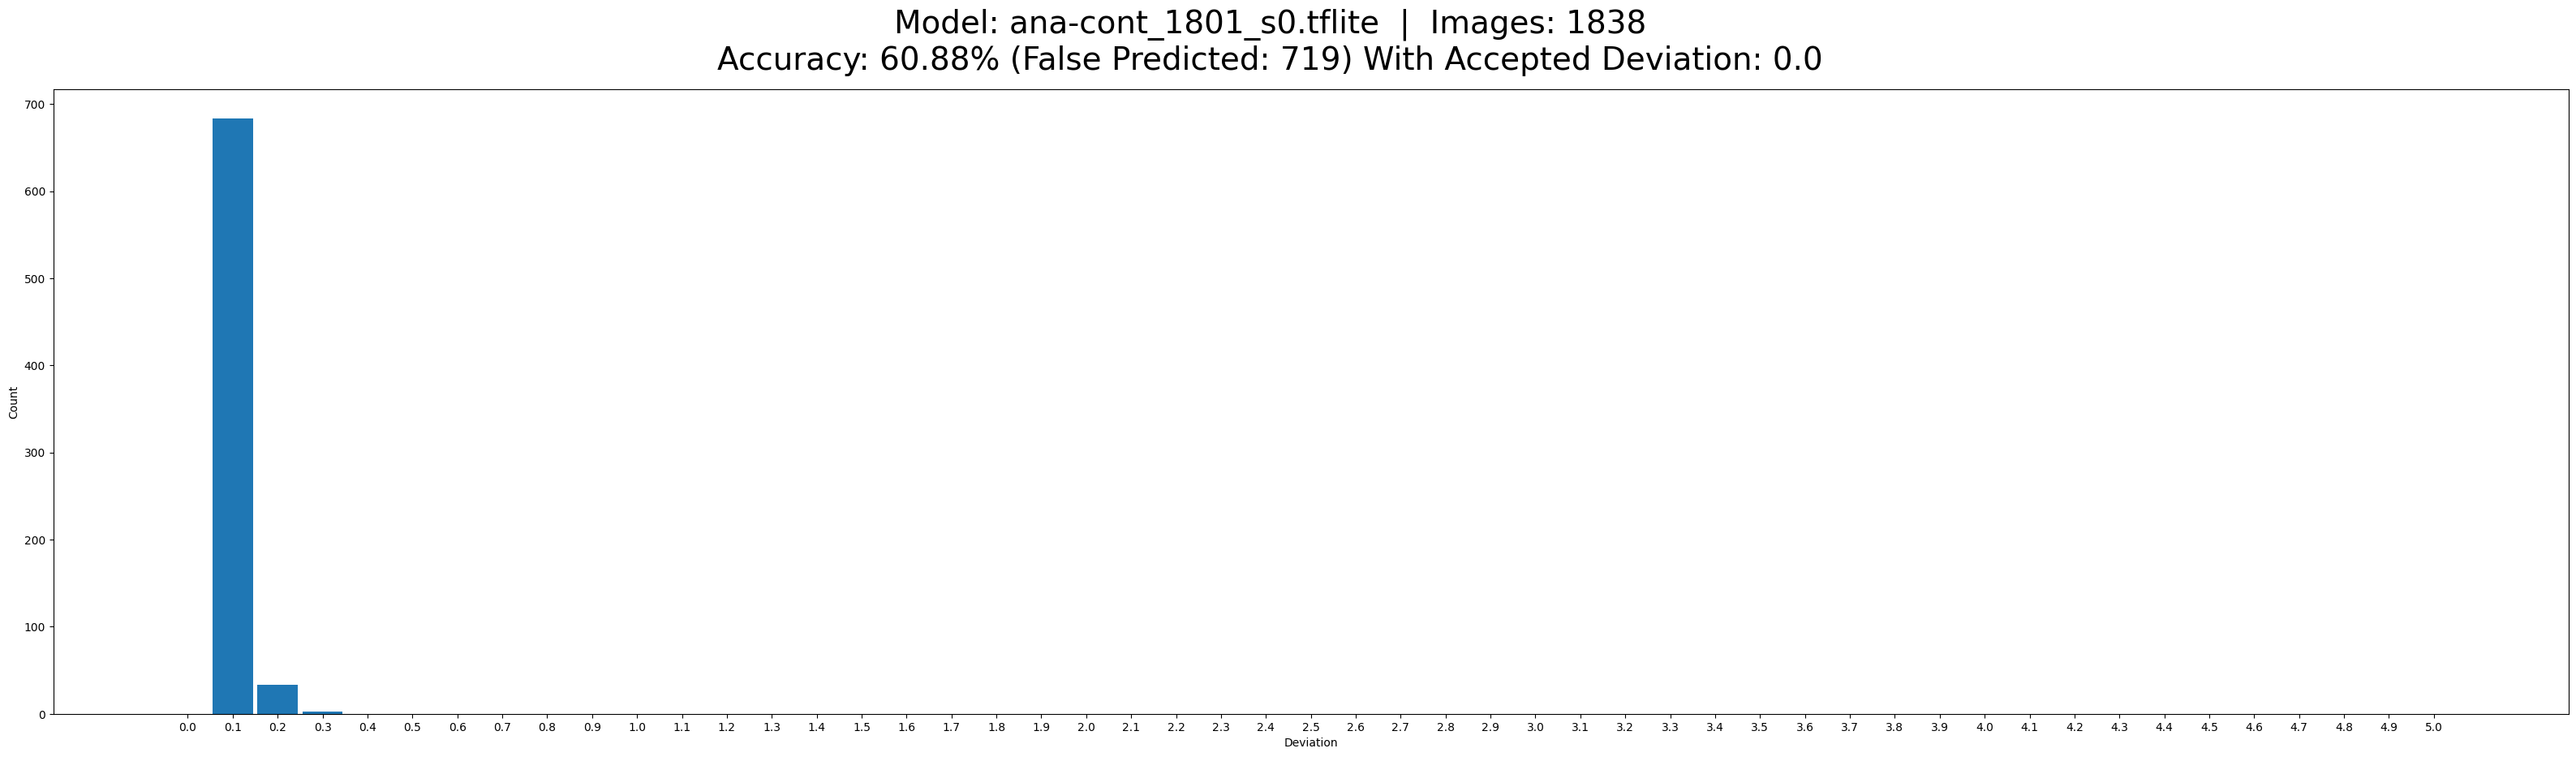

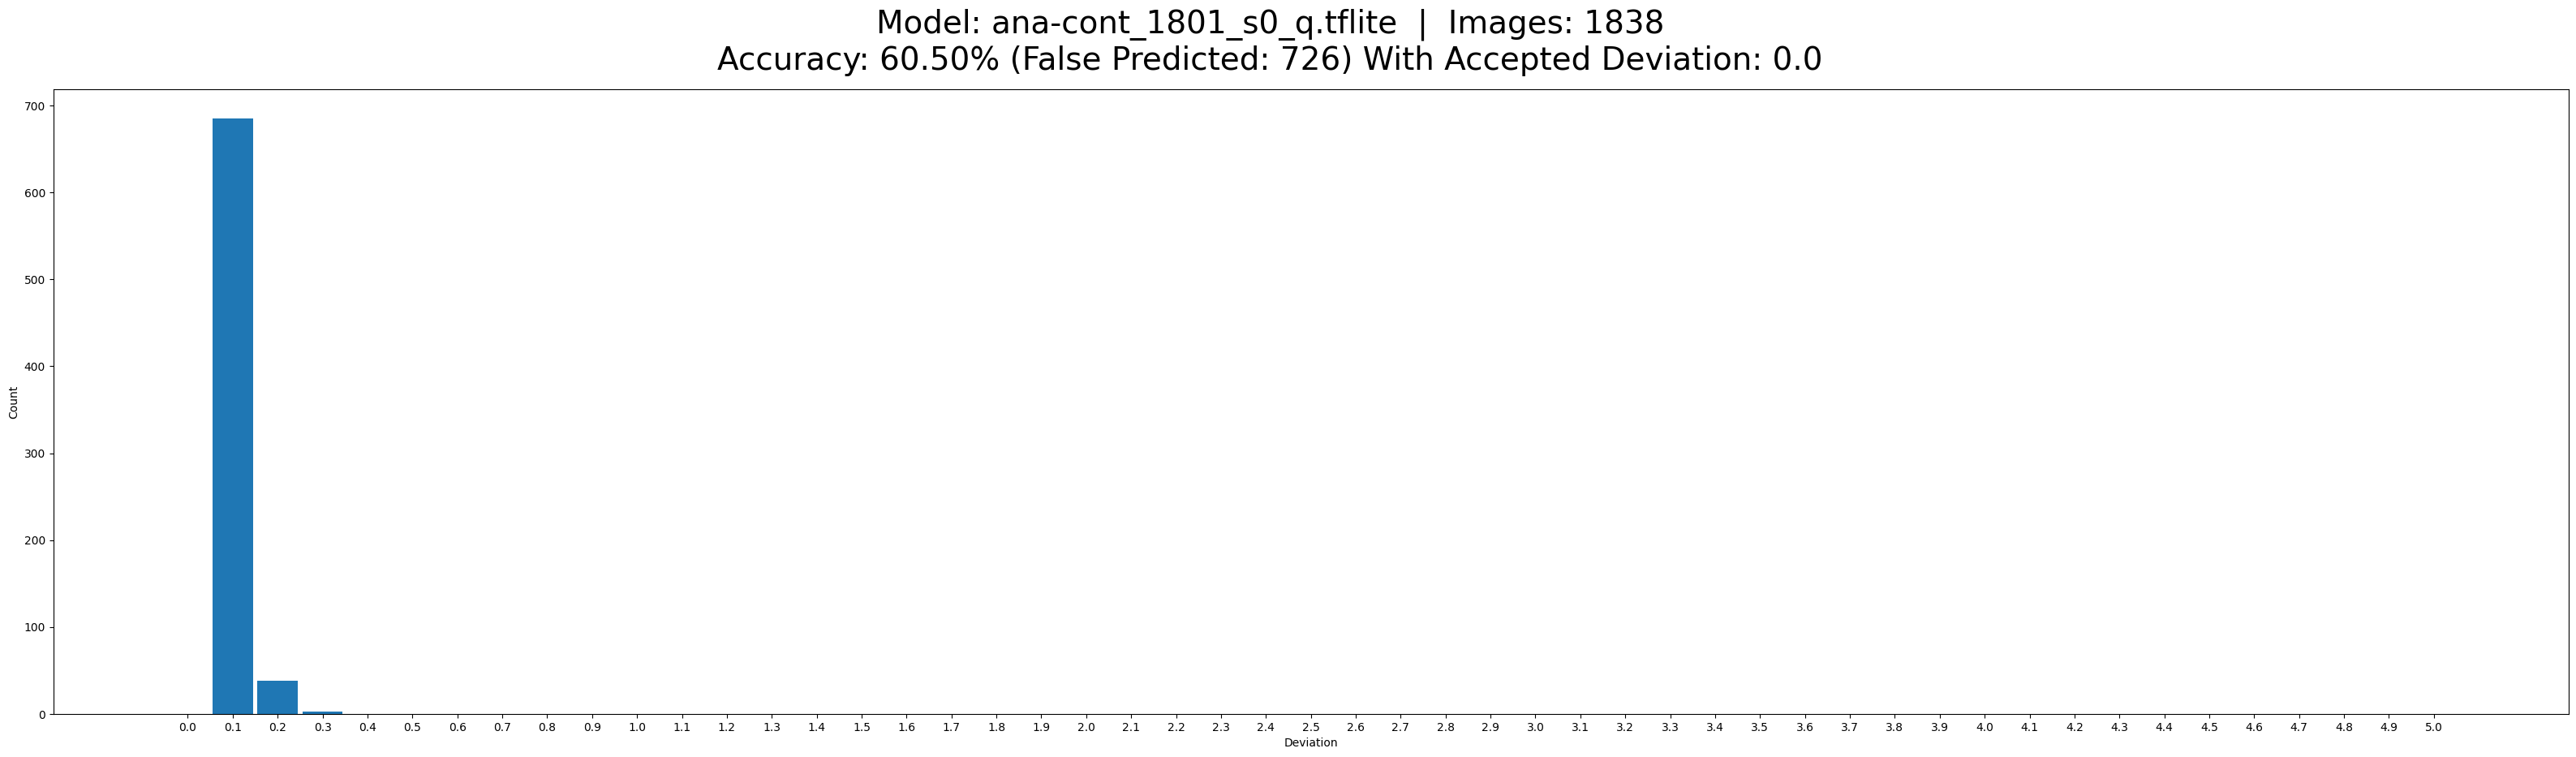

In [7]:
for modelfile in modelfiles:
    evaluate_model_accuracy(modelfile, x_data, y_data, f_data, title=modelfile, accepted_deviation=0.0)
    print(f" ")
    print(f" ")
